In [1]:
import oggm
from oggm import cfg, workflow, tasks, graphics, utils 
import oggm.core.massbalance as mbmods
from oggm.core.flowline import FluxBasedModel
from oggm.workflow import execute_entity_task
import geopandas as gpd
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import xarray as xr
import salem
import shapely.geometry as shpg
plt.rcParams['figure.figsize'] = (8,8)
import logging
log = logging.getLogger(__name__)

In [2]:
from collections import OrderedDict
import time

In [61]:
cfg.initialize()
cfg.PARAMS['continue_on_error'] = True
cfg.PATHS['working_dir'] = "/home/david/OGGM_WORKING_DIRECTORY/"
cfg.PARAMS['use_multiprocessing'] = True
PI_path = "/home/david/Desktop/CCSM4_midHolocene_data/pi.nc"
cfg.PARAMS['border'] = 200

2018-09-14 12:38:21: oggm.cfg: Parameter file: /home/david/oggm/oggm/params.cfg


In [62]:
entity = gpd.GeoDataFrame.from_file('/home/david/OGGM/rgi/RGIV5/06_rgi50_Iceland/06_rgi50_Iceland.shp')
gdirs = oggm.workflow.init_glacier_regions(entity)
gdirs = gdirs[:2]
gdirs

2018-09-14 12:38:22: oggm.workflow: Multiprocessing: using all available processors (N=12)


[<oggm.GlacierDirectory>
   RGI id: RGI50-06.00001
   Region: 06: Iceland
   Subregion: 06-00: Iceland
   Glacier type: Glacier
   Terminus type: Land-terminating
   Area: 4.903 km2
   Lon, Lat: (-23.7852, 64.8174)
   Grid (nx, ny): (118, 117)
   Grid (dx, dy): (41.0, -41.0), <oggm.GlacierDirectory>
   RGI id: RGI50-06.00002
   Region: 06: Iceland
   Subregion: 06-00: Iceland
   Glacier type: Ice cap
   Terminus type: Land-terminating
   Area: 1.897 km2
   Lon, Lat: (-23.7686, 64.7951)
   Grid (nx, ny): (98, 99)
   Grid (dx, dy): (29.0, -29.0)]

2018-09-14 12:38:22: oggm.core.gis: (RGI50-06.00002) glacier_masks
2018-09-14 12:38:22: oggm.core.gis: (RGI50-06.00001) glacier_masks
/home/david/anaconda3/envs/oggm_env/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/david/anaconda3/envs/oggm_env/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/david/anaconda3/envs/oggm_env/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `comple

In [63]:
# Preprocessing and climate tasks
task_list = [
    tasks.glacier_masks,
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.compute_downstream_line,
    tasks.compute_downstream_bedshape,
    tasks.catchment_area,
    tasks.catchment_intersections,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction,
    tasks.process_cru_data,
    tasks.local_mustar,
    tasks.apparent_mb,
]
for task in task_list:
    execute_entity_task(task, gdirs)

# Inversion tasks
execute_entity_task(tasks.prepare_for_inversion, gdirs)
# We use the default parameters for this run
execute_entity_task(tasks.mass_conservation_inversion, gdirs)
execute_entity_task(tasks.filter_inversion_output, gdirs)

# Final preparation for the run
execute_entity_task(tasks.init_present_time_glacier, gdirs)

In [64]:
gdir = gdirs[0]
mb = mbmods.ConstantMassBalance(gdir, y0=1951, halfsize=0, filename='cesm_data')
gdir

<oggm.GlacierDirectory>
  RGI id: RGI50-06.00001
  Region: 06: Iceland
  Subregion: 06-00: Iceland
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 4.903 km2
  Lon, Lat: (-23.7852, 64.8174)
  Grid (nx, ny): (118, 117)
  Grid (dx, dy): (41.0, -41.0)

In [57]:
fls = gdir.read_pickle('model_flowlines')
model = FluxBasedModel(fls, mb_model=mb, y0=1951, time_stepping='default')

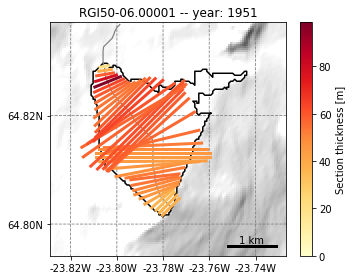

In [58]:
graphics.plot_modeloutput_map([gdir], model=model)

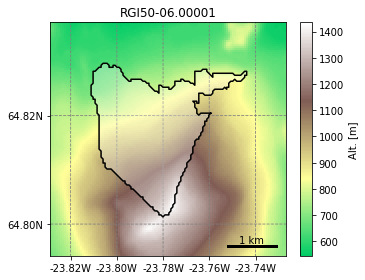

In [70]:
graphics.plot_domain(gdir)

In [59]:
model.volume_km3

0.25960416806958186

In [68]:
tasks.run_constant_climate(gdir, y0=1951, halfsize=0, climate_filename='cesm_data')

2018-09-14 12:42:04: oggm.core.flowline: (RGI50-06.00001) run_constant_climate
2018-09-14 12:42:04: oggm.core.flowline: (RGI50-06.00001) trying default time stepping scheme.
2018-09-14 12:42:05: oggm.core.flowline: (RGI50-06.00001) trying conservative time stepping scheme.
2018-09-14 12:42:07: oggm.core.flowline: (RGI50-06.00001) trying ultra-conservative time stepping scheme.
2018-09-14 12:42:08: oggm.core.flowline: RuntimeError occurred during task run_constant_climate on RGI50-06.00001: Glacier exceeds domain boundaries.


In [60]:
model.run_until_equilibrium()

RuntimeError: Glacier exceeds domain boundaries.

0.558931220260542

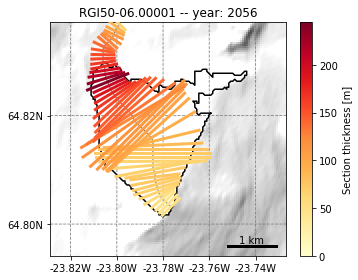

In [51]:
graphics.plot_modeloutput_map([gdir], model=model)
model.volume_km3

In [ ]:
def ccsm_custom_run(gdirs, filesuffix):
    """
    """
    log.info('Starting OGGM run')
    out_df = []
    for gdir in gdirs:
        log.info('(%s) starting run.', gdir.rgi_id)
        d = OrderedDict()
        d['rgi_id'] = gdir.rgi_id
        d['name'] = gdir.name
        d['cenlon'] = gdir.cenlon
        d['cenlat'] = gdir.cenlat
        d['rgi_area_km2'] = gdir.rgi_area_km2
        d['glacier_type'] = gdir.glacier_type
        d['terminus_type'] = gdir.terminus_type
        try:
            mb = mbmods.ConstantMassBalance(gdir, y0=1951, filename='cesm_data')
            fls = gdir.read_pickle('model_flowlines')
            model = FluxBasedModel(fls, mb_model=mb, y0=1951, time_stepping='default')
            d['initial_model_volume_km3'] = model.volume_km3
            d['initial_model_area_km2'] = model.area_km2
            d['initial_model_length_m'] = model.length_m
            model.run_until_equilibrium()
            # Easy stats - this should always be possible
            d['model_volume_km3'] = model.volume_km3
            d['model_area_km2'] = model.area_km2
            d['model_length_m'] = model.length_m
        except RuntimeError: 
            log.info('(%s) RuntimeError', gdir.rgi_id)
        except ValueError:
            log.info('(%s) ValueError', gdir.rgi_id)
        except FloatingPointError:
            log.info('(%s) FloatingPointError', gdir.rgi_id)
        except FileNotFoundError:
            log.info('(%s) FileNotFoundError', gdir.rgi_id)
        except ImportError:
            log.info('(%s) ImportError', gdir.rgi_id)
        out_df.append(d)
    out = pd.DataFrame(out_df).set_index('rgi_id')
    out.to_csv('/home/david/Desktop/CCSM4_midHolocene_data/Model_Results/' + filesuffix + '_glacier_characteristics.csv')

In [5]:
entity = gpd.GeoDataFrame.from_file('/home/david/OGGM/rgi/RGIV5/01_rgi50_Alaska/01_rgi50_Alaska.shp')
gdirs = oggm.workflow.init_glacier_regions(entity)
ccsm_custom_run(gdirs, "01")

2017-11-28 18:29:26: oggm.workflow: Multiprocessing: using all available processors (N=12)
2017-11-28 18:29:26: __main__: Starting OGGM run
2017-11-28 18:29:26: __main__: (RGI50-01.00001) starting run.
2017-11-28 18:29:27: __main__: (RGI50-01.00002) starting run.
2017-11-28 18:29:28: __main__: (RGI50-01.00003) starting run.
2017-11-28 18:29:31: __main__: (RGI50-01.00004) starting run.
2017-11-28 18:29:51: __main__: (RGI50-01.00005) starting run.
2017-11-28 18:30:00: __main__: (RGI50-01.00006) starting run.
2017-11-28 18:30:11: __main__: (RGI50-01.00007) starting run.
2017-11-28 18:30:13: __main__: (RGI50-01.00008) starting run.
2017-11-28 18:30:13: __main__: (RGI50-01.00009) starting run.
2017-11-28 18:30:15: __main__: (RGI50-01.00010) starting run.
2017-11-28 18:30:35: __main__: (RGI50-01.00010) RuntimeError
2017-11-28 18:30:35: __main__: (RGI50-01.00011) starting run.
2017-11-28 18:30:41: __main__: (RGI50-01.00012) starting run.
2017-11-28 18:30:54: __main__: (RGI50-01.00013) startin

2017-11-28 18:44:23: __main__: (RGI50-01.00096) starting run.
2017-11-28 18:44:27: __main__: (RGI50-01.00097) starting run.
2017-11-28 18:44:27: __main__: (RGI50-01.00098) starting run.
2017-11-28 18:44:29: __main__: (RGI50-01.00099) starting run.
2017-11-28 18:44:30: __main__: (RGI50-01.00100) starting run.
2017-11-28 18:44:30: __main__: (RGI50-01.00101) starting run.
2017-11-28 18:44:31: __main__: (RGI50-01.00102) starting run.
2017-11-28 18:44:33: __main__: (RGI50-01.00103) starting run.
2017-11-28 18:44:38: __main__: (RGI50-01.00104) starting run.
2017-11-28 18:44:39: __main__: (RGI50-01.00105) starting run.
2017-11-28 18:44:54: __main__: (RGI50-01.00105) RuntimeError
2017-11-28 18:44:54: __main__: (RGI50-01.00106) starting run.
2017-11-28 18:45:01: __main__: (RGI50-01.00106) RuntimeError
2017-11-28 18:45:01: __main__: (RGI50-01.00107) starting run.
2017-11-28 18:45:07: __main__: (RGI50-01.00108) starting run.
2017-11-28 18:45:09: __main__: (RGI50-01.00109) starting run.
2017-11-28

2017-11-28 18:53:33: __main__: (RGI50-01.00219) starting run.
2017-11-28 18:53:34: __main__: (RGI50-01.00220) starting run.
2017-11-28 18:53:36: __main__: (RGI50-01.00221) starting run.
2017-11-28 18:53:38: __main__: (RGI50-01.00222) starting run.
2017-11-28 18:53:40: __main__: (RGI50-01.00223) starting run.
2017-11-28 18:53:41: __main__: (RGI50-01.00224) starting run.
2017-11-28 18:53:46: __main__: (RGI50-01.00225) starting run.
2017-11-28 18:53:53: __main__: (RGI50-01.00225) RuntimeError
2017-11-28 18:53:53: __main__: (RGI50-01.00226) starting run.
2017-11-28 18:53:55: __main__: (RGI50-01.00227) starting run.
2017-11-28 18:54:00: __main__: (RGI50-01.00228) starting run.
2017-11-28 18:54:02: __main__: (RGI50-01.00229) starting run.
2017-11-28 18:54:04: __main__: (RGI50-01.00230) starting run.
2017-11-28 18:54:06: __main__: (RGI50-01.00231) starting run.
2017-11-28 18:54:07: __main__: (RGI50-01.00232) starting run.
2017-11-28 18:54:13: __main__: (RGI50-01.00233) starting run.
2017-11-2

2017-11-28 19:01:28: __main__: (RGI50-01.00347) starting run.
2017-11-28 19:01:34: __main__: (RGI50-01.00348) starting run.
2017-11-28 19:01:46: __main__: (RGI50-01.00349) starting run.
2017-11-28 19:01:49: __main__: (RGI50-01.00350) starting run.
2017-11-28 19:01:52: __main__: (RGI50-01.00351) starting run.
2017-11-28 19:01:57: __main__: (RGI50-01.00352) starting run.
2017-11-28 19:02:02: __main__: (RGI50-01.00353) starting run.
2017-11-28 19:02:08: __main__: (RGI50-01.00353) RuntimeError
2017-11-28 19:02:08: __main__: (RGI50-01.00354) starting run.
2017-11-28 19:02:09: __main__: (RGI50-01.00355) starting run.
2017-11-28 19:02:11: __main__: (RGI50-01.00356) starting run.
2017-11-28 19:02:13: __main__: (RGI50-01.00357) starting run.
2017-11-28 19:02:15: __main__: (RGI50-01.00358) starting run.
2017-11-28 19:02:17: __main__: (RGI50-01.00359) starting run.
2017-11-28 19:02:18: __main__: (RGI50-01.00360) starting run.
2017-11-28 19:02:20: __main__: (RGI50-01.00361) starting run.
2017-11-2

2017-11-28 19:08:05: __main__: (RGI50-01.00475) starting run.
2017-11-28 19:08:08: __main__: (RGI50-01.00476) starting run.
2017-11-28 19:08:15: __main__: (RGI50-01.00476) RuntimeError
2017-11-28 19:08:15: __main__: (RGI50-01.00477) starting run.
2017-11-28 19:08:27: __main__: (RGI50-01.00478) starting run.
2017-11-28 19:08:29: __main__: (RGI50-01.00479) starting run.
2017-11-28 19:08:30: __main__: (RGI50-01.00480) starting run.
2017-11-28 19:08:31: __main__: (RGI50-01.00481) starting run.
2017-11-28 19:08:33: __main__: (RGI50-01.00482) starting run.
2017-11-28 19:08:54: __main__: (RGI50-01.00482) RuntimeError
2017-11-28 19:08:54: __main__: (RGI50-01.00483) starting run.
2017-11-28 19:08:56: __main__: (RGI50-01.00484) starting run.
2017-11-28 19:08:57: __main__: (RGI50-01.00485) starting run.
2017-11-28 19:09:01: __main__: (RGI50-01.00486) starting run.
2017-11-28 19:09:07: __main__: (RGI50-01.00486) RuntimeError
2017-11-28 19:09:07: __main__: (RGI50-01.00487) starting run.
2017-11-28 

2017-11-28 19:24:05: __main__: (RGI50-01.00589) starting run.
2017-11-28 19:24:09: __main__: (RGI50-01.00590) starting run.
2017-11-28 19:24:23: __main__: (RGI50-01.00590) RuntimeError
2017-11-28 19:24:23: __main__: (RGI50-01.00591) starting run.
2017-11-28 19:24:28: __main__: (RGI50-01.00592) starting run.
2017-11-28 19:24:33: __main__: (RGI50-01.00593) starting run.
2017-11-28 19:24:41: __main__: (RGI50-01.00594) starting run.
2017-11-28 19:25:07: __main__: (RGI50-01.00595) starting run.
2017-11-28 19:25:14: __main__: (RGI50-01.00596) starting run.
2017-11-28 19:25:24: __main__: (RGI50-01.00597) starting run.
2017-11-28 19:25:30: __main__: (RGI50-01.00598) starting run.
2017-11-28 19:25:34: __main__: (RGI50-01.00599) starting run.
2017-11-28 19:25:36: __main__: (RGI50-01.00600) starting run.
2017-11-28 19:25:48: __main__: (RGI50-01.00601) starting run.
2017-11-28 19:25:50: __main__: (RGI50-01.00602) starting run.
2017-11-28 19:25:53: __main__: (RGI50-01.00603) starting run.
2017-11-2

2017-11-28 19:32:35: __main__: (RGI50-01.00707) starting run.
2017-11-28 19:32:36: __main__: (RGI50-01.00708) starting run.
2017-11-28 19:32:39: __main__: (RGI50-01.00709) starting run.
2017-11-28 19:32:39: __main__: (RGI50-01.00710) starting run.
2017-11-28 19:32:40: __main__: (RGI50-01.00711) starting run.
2017-11-28 19:32:44: __main__: (RGI50-01.00712) starting run.
2017-11-28 19:32:45: __main__: (RGI50-01.00713) starting run.
2017-11-28 19:32:46: __main__: (RGI50-01.00714) starting run.
2017-11-28 19:32:47: __main__: (RGI50-01.00715) starting run.
2017-11-28 19:32:49: __main__: (RGI50-01.00716) starting run.
2017-11-28 19:32:52: __main__: (RGI50-01.00717) starting run.
2017-11-28 19:32:54: __main__: (RGI50-01.00718) starting run.
2017-11-28 19:32:57: __main__: (RGI50-01.00719) starting run.
2017-11-28 19:32:59: __main__: (RGI50-01.00720) starting run.
2017-11-28 19:33:02: __main__: (RGI50-01.00721) starting run.
2017-11-28 19:33:03: __main__: (RGI50-01.00722) starting run.
2017-11-

2017-11-28 19:39:44: __main__: (RGI50-01.00830) starting run.
2017-11-28 19:39:45: __main__: (RGI50-01.00831) starting run.
2017-11-28 19:39:49: __main__: (RGI50-01.00831) RuntimeError
2017-11-28 19:39:49: __main__: (RGI50-01.00832) starting run.
2017-11-28 19:39:50: __main__: (RGI50-01.00833) starting run.
2017-11-28 19:39:52: __main__: (RGI50-01.00834) starting run.
2017-11-28 19:39:55: __main__: (RGI50-01.00835) starting run.
2017-11-28 19:39:59: __main__: (RGI50-01.00836) starting run.
2017-11-28 19:40:03: __main__: (RGI50-01.00837) starting run.
2017-11-28 19:40:03: __main__: (RGI50-01.00838) starting run.
2017-11-28 19:40:10: __main__: (RGI50-01.00839) starting run.
2017-11-28 19:40:12: __main__: (RGI50-01.00840) starting run.
2017-11-28 19:40:15: __main__: (RGI50-01.00841) starting run.
2017-11-28 19:40:26: __main__: (RGI50-01.00842) starting run.
2017-11-28 19:40:27: __main__: (RGI50-01.00843) starting run.
2017-11-28 19:40:29: __main__: (RGI50-01.00844) starting run.
2017-11-2

2017-11-28 19:46:31: __main__: (RGI50-01.00958) starting run.
2017-11-28 19:46:33: __main__: (RGI50-01.00959) starting run.
2017-11-28 19:46:34: __main__: (RGI50-01.00960) starting run.
2017-11-28 19:46:42: __main__: (RGI50-01.00961) starting run.
2017-11-28 19:46:44: __main__: (RGI50-01.00962) starting run.
2017-11-28 19:46:46: __main__: (RGI50-01.00963) starting run.
2017-11-28 19:46:55: __main__: (RGI50-01.00964) starting run.
2017-11-28 19:46:57: __main__: (RGI50-01.00965) starting run.
2017-11-28 19:47:00: __main__: (RGI50-01.00966) starting run.
2017-11-28 19:47:02: __main__: (RGI50-01.00967) starting run.
2017-11-28 19:47:04: __main__: (RGI50-01.00968) starting run.
2017-11-28 19:47:07: __main__: (RGI50-01.00969) starting run.
2017-11-28 19:47:08: __main__: (RGI50-01.00970) starting run.
2017-11-28 19:47:08: __main__: (RGI50-01.00971) starting run.
2017-11-28 19:47:10: __main__: (RGI50-01.00972) starting run.
2017-11-28 19:47:14: __main__: (RGI50-01.00973) starting run.
2017-11-

2017-11-28 19:52:11: __main__: (RGI50-01.01087) starting run.
2017-11-28 19:52:12: __main__: (RGI50-01.01088) starting run.
2017-11-28 19:52:15: __main__: (RGI50-01.01089) starting run.
2017-11-28 19:52:16: __main__: (RGI50-01.01090) starting run.
2017-11-28 19:52:17: __main__: (RGI50-01.01091) starting run.
2017-11-28 19:52:19: __main__: (RGI50-01.01092) starting run.
2017-11-28 19:52:40: __main__: (RGI50-01.01093) starting run.
2017-11-28 19:52:40: __main__: (RGI50-01.01094) starting run.
2017-11-28 19:52:42: __main__: (RGI50-01.01095) starting run.
2017-11-28 19:52:49: __main__: (RGI50-01.01096) starting run.
2017-11-28 19:52:50: __main__: (RGI50-01.01097) starting run.
2017-11-28 19:52:51: __main__: (RGI50-01.01098) starting run.
2017-11-28 19:52:57: __main__: (RGI50-01.01098) RuntimeError
2017-11-28 19:52:57: __main__: (RGI50-01.01099) starting run.
2017-11-28 19:53:03: __main__: (RGI50-01.01100) starting run.
2017-11-28 19:53:03: __main__: (RGI50-01.01101) starting run.
2017-11-2

2017-11-28 19:56:33: __main__: (RGI50-01.01215) starting run.
2017-11-28 19:56:35: __main__: (RGI50-01.01216) starting run.
2017-11-28 19:56:37: __main__: (RGI50-01.01217) starting run.
2017-11-28 19:56:46: __main__: (RGI50-01.01218) starting run.
2017-11-28 19:56:46: __main__: (RGI50-01.01219) starting run.
2017-11-28 19:56:48: __main__: (RGI50-01.01220) starting run.
2017-11-28 19:56:48: __main__: (RGI50-01.01221) starting run.
2017-11-28 19:56:49: __main__: (RGI50-01.01222) starting run.
2017-11-28 19:56:50: __main__: (RGI50-01.01223) starting run.
2017-11-28 19:56:51: __main__: (RGI50-01.01224) starting run.
2017-11-28 19:56:52: __main__: (RGI50-01.01225) starting run.
2017-11-28 19:56:52: __main__: (RGI50-01.01226) starting run.
2017-11-28 19:56:53: __main__: (RGI50-01.01227) starting run.
2017-11-28 19:56:55: __main__: (RGI50-01.01228) starting run.
2017-11-28 19:56:58: __main__: (RGI50-01.01229) starting run.
2017-11-28 19:56:59: __main__: (RGI50-01.01230) starting run.
2017-11-

2017-11-28 20:04:14: __main__: (RGI50-01.01344) starting run.
2017-11-28 20:04:15: __main__: (RGI50-01.01345) starting run.
2017-11-28 20:04:16: __main__: (RGI50-01.01346) starting run.
2017-11-28 20:04:17: __main__: (RGI50-01.01347) starting run.
2017-11-28 20:04:21: __main__: (RGI50-01.01348) starting run.
2017-11-28 20:04:22: __main__: (RGI50-01.01349) starting run.
2017-11-28 20:04:22: __main__: (RGI50-01.01350) starting run.
2017-11-28 20:04:23: __main__: (RGI50-01.01351) starting run.
2017-11-28 20:04:24: __main__: (RGI50-01.01352) starting run.
2017-11-28 20:04:27: __main__: (RGI50-01.01353) starting run.
2017-11-28 20:04:29: __main__: (RGI50-01.01354) starting run.
2017-11-28 20:04:32: __main__: (RGI50-01.01355) starting run.
2017-11-28 20:04:38: __main__: (RGI50-01.01355) RuntimeError
2017-11-28 20:04:38: __main__: (RGI50-01.01356) starting run.
2017-11-28 20:04:38: __main__: (RGI50-01.01357) starting run.
2017-11-28 20:04:42: __main__: (RGI50-01.01358) starting run.
2017-11-2

2017-11-28 20:08:08: __main__: (RGI50-01.01475) starting run.
2017-11-28 20:08:09: __main__: (RGI50-01.01476) starting run.
2017-11-28 20:08:15: __main__: (RGI50-01.01476) FloatingPointError
2017-11-28 20:08:15: __main__: (RGI50-01.01477) starting run.
2017-11-28 20:08:17: __main__: (RGI50-01.01478) starting run.
2017-11-28 20:08:17: __main__: (RGI50-01.01479) starting run.
2017-11-28 20:08:19: __main__: (RGI50-01.01480) starting run.
2017-11-28 20:08:22: __main__: (RGI50-01.01481) starting run.
2017-11-28 20:08:23: __main__: (RGI50-01.01482) starting run.
2017-11-28 20:08:27: __main__: (RGI50-01.01483) starting run.
2017-11-28 20:08:31: __main__: (RGI50-01.01484) starting run.
2017-11-28 20:08:46: __main__: (RGI50-01.01484) RuntimeError
2017-11-28 20:08:46: __main__: (RGI50-01.01485) starting run.
2017-11-28 20:08:48: __main__: (RGI50-01.01486) starting run.
2017-11-28 20:09:02: __main__: (RGI50-01.01487) starting run.
2017-11-28 20:09:06: __main__: (RGI50-01.01488) starting run.
2017

2017-11-28 20:13:25: __main__: (RGI50-01.01602) starting run.
2017-11-28 20:13:30: __main__: (RGI50-01.01603) starting run.
2017-11-28 20:13:31: __main__: (RGI50-01.01604) starting run.
2017-11-28 20:13:32: __main__: (RGI50-01.01605) starting run.
2017-11-28 20:13:33: __main__: (RGI50-01.01606) starting run.
2017-11-28 20:13:38: __main__: (RGI50-01.01607) starting run.
2017-11-28 20:13:40: __main__: (RGI50-01.01608) starting run.
2017-11-28 20:13:41: __main__: (RGI50-01.01609) starting run.
2017-11-28 20:13:41: __main__: (RGI50-01.01610) starting run.
2017-11-28 20:13:42: __main__: (RGI50-01.01611) starting run.
2017-11-28 20:13:43: __main__: (RGI50-01.01612) starting run.
2017-11-28 20:13:44: __main__: (RGI50-01.01613) starting run.
2017-11-28 20:13:44: __main__: (RGI50-01.01614) starting run.
2017-11-28 20:13:46: __main__: (RGI50-01.01615) starting run.
2017-11-28 20:13:53: __main__: (RGI50-01.01616) starting run.
2017-11-28 20:13:54: __main__: (RGI50-01.01617) starting run.
2017-11-

2017-11-28 20:18:55: __main__: (RGI50-01.01733) starting run.
2017-11-28 20:19:22: __main__: (RGI50-01.01734) starting run.
2017-11-28 20:19:25: __main__: (RGI50-01.01734) ValueError
2017-11-28 20:19:25: __main__: (RGI50-01.01735) starting run.
2017-11-28 20:19:42: __main__: (RGI50-01.01736) starting run.
2017-11-28 20:19:43: __main__: (RGI50-01.01737) starting run.
2017-11-28 20:19:43: __main__: (RGI50-01.01738) starting run.
2017-11-28 20:19:46: __main__: (RGI50-01.01739) starting run.
2017-11-28 20:19:52: __main__: (RGI50-01.01740) starting run.
2017-11-28 20:19:52: __main__: (RGI50-01.01741) starting run.
2017-11-28 20:20:14: __main__: (RGI50-01.01742) starting run.
2017-11-28 20:20:15: __main__: (RGI50-01.01743) starting run.
2017-11-28 20:20:34: __main__: (RGI50-01.01744) starting run.
2017-11-28 20:20:35: __main__: (RGI50-01.01745) starting run.
2017-11-28 20:20:40: __main__: (RGI50-01.01746) starting run.
2017-11-28 20:20:40: __main__: (RGI50-01.01747) starting run.
2017-11-28 

2017-11-28 20:27:03: __main__: (RGI50-01.01861) starting run.
2017-11-28 20:27:10: __main__: (RGI50-01.01862) starting run.
2017-11-28 20:27:18: __main__: (RGI50-01.01863) starting run.
2017-11-28 20:27:26: __main__: (RGI50-01.01863) RuntimeError
2017-11-28 20:27:26: __main__: (RGI50-01.01864) starting run.
2017-11-28 20:27:28: __main__: (RGI50-01.01865) starting run.
2017-11-28 20:27:31: __main__: (RGI50-01.01866) starting run.
2017-11-28 20:27:32: __main__: (RGI50-01.01867) starting run.
2017-11-28 20:27:33: __main__: (RGI50-01.01868) starting run.
2017-11-28 20:27:35: __main__: (RGI50-01.01869) starting run.
2017-11-28 20:27:36: __main__: (RGI50-01.01870) starting run.
2017-11-28 20:27:37: __main__: (RGI50-01.01871) starting run.
2017-11-28 20:27:38: __main__: (RGI50-01.01872) starting run.
2017-11-28 20:27:41: __main__: (RGI50-01.01873) starting run.
2017-11-28 20:27:42: __main__: (RGI50-01.01874) starting run.
2017-11-28 20:27:43: __main__: (RGI50-01.01875) starting run.
2017-11-2

2017-11-28 20:32:48: __main__: (RGI50-01.01986) starting run.
2017-11-28 20:32:55: __main__: (RGI50-01.01986) RuntimeError
2017-11-28 20:32:55: __main__: (RGI50-01.01987) starting run.
2017-11-28 20:33:00: __main__: (RGI50-01.01987) RuntimeError
2017-11-28 20:33:00: __main__: (RGI50-01.01988) starting run.
2017-11-28 20:33:01: __main__: (RGI50-01.01989) starting run.
2017-11-28 20:33:04: __main__: (RGI50-01.01990) starting run.
2017-11-28 20:33:06: __main__: (RGI50-01.01991) starting run.
2017-11-28 20:33:11: __main__: (RGI50-01.01992) starting run.
2017-11-28 20:33:12: __main__: (RGI50-01.01993) starting run.
2017-11-28 20:33:13: __main__: (RGI50-01.01994) starting run.
2017-11-28 20:33:16: __main__: (RGI50-01.01995) starting run.
2017-11-28 20:33:18: __main__: (RGI50-01.01996) starting run.
2017-11-28 20:33:19: __main__: (RGI50-01.01997) starting run.
2017-11-28 20:33:20: __main__: (RGI50-01.01998) starting run.
2017-11-28 20:33:21: __main__: (RGI50-01.01999) starting run.
2017-11-28

2017-11-28 20:38:18: __main__: (RGI50-01.02111) starting run.
2017-11-28 20:38:19: __main__: (RGI50-01.02112) starting run.
2017-11-28 20:38:19: __main__: (RGI50-01.02113) starting run.
2017-11-28 20:38:20: __main__: (RGI50-01.02114) starting run.
2017-11-28 20:38:22: __main__: (RGI50-01.02115) starting run.
2017-11-28 20:38:26: __main__: (RGI50-01.02116) starting run.
2017-11-28 20:38:34: __main__: (RGI50-01.02117) starting run.
2017-11-28 20:38:35: __main__: (RGI50-01.02118) starting run.
2017-11-28 20:38:39: __main__: (RGI50-01.02119) starting run.
2017-11-28 20:38:40: __main__: (RGI50-01.02120) starting run.
2017-11-28 20:38:41: __main__: (RGI50-01.02121) starting run.
2017-11-28 20:38:41: __main__: (RGI50-01.02122) starting run.
2017-11-28 20:38:41: __main__: (RGI50-01.02123) starting run.
2017-11-28 20:38:43: __main__: (RGI50-01.02124) starting run.
2017-11-28 20:38:46: __main__: (RGI50-01.02125) starting run.
2017-11-28 20:38:47: __main__: (RGI50-01.02126) starting run.
2017-11-

2017-11-28 20:44:46: __main__: (RGI50-01.02237) starting run.
2017-11-28 20:44:47: __main__: (RGI50-01.02238) starting run.
2017-11-28 20:44:54: __main__: (RGI50-01.02239) starting run.
2017-11-28 20:45:12: __main__: (RGI50-01.02240) starting run.
2017-11-28 20:45:13: __main__: (RGI50-01.02241) starting run.
2017-11-28 20:45:13: __main__: (RGI50-01.02242) starting run.
2017-11-28 20:45:14: __main__: (RGI50-01.02243) starting run.
2017-11-28 20:45:14: __main__: (RGI50-01.02244) starting run.
2017-11-28 20:45:20: __main__: (RGI50-01.02244) RuntimeError
2017-11-28 20:45:20: __main__: (RGI50-01.02245) starting run.
2017-11-28 20:45:25: __main__: (RGI50-01.02246) starting run.
2017-11-28 20:45:28: __main__: (RGI50-01.02247) starting run.
2017-11-28 20:45:30: __main__: (RGI50-01.02248) starting run.
2017-11-28 20:45:36: __main__: (RGI50-01.02249) starting run.
2017-11-28 20:45:37: __main__: (RGI50-01.02250) starting run.
2017-11-28 20:45:38: __main__: (RGI50-01.02251) starting run.
2017-11-2

2017-11-28 20:52:07: __main__: (RGI50-01.02360) starting run.
2017-11-28 20:52:17: __main__: (RGI50-01.02361) starting run.
2017-11-28 20:52:19: __main__: (RGI50-01.02362) starting run.
2017-11-28 20:52:24: __main__: (RGI50-01.02363) starting run.
2017-11-28 20:52:26: __main__: (RGI50-01.02364) starting run.
2017-11-28 20:52:27: __main__: (RGI50-01.02365) starting run.
2017-11-28 20:52:29: __main__: (RGI50-01.02366) starting run.
2017-11-28 20:52:33: __main__: (RGI50-01.02367) starting run.
2017-11-28 20:52:35: __main__: (RGI50-01.02368) starting run.
2017-11-28 20:52:39: __main__: (RGI50-01.02369) starting run.
2017-11-28 20:52:41: __main__: (RGI50-01.02370) starting run.
2017-11-28 20:52:41: __main__: (RGI50-01.02371) starting run.
2017-11-28 20:52:41: __main__: (RGI50-01.02372) starting run.
2017-11-28 20:52:43: __main__: (RGI50-01.02373) starting run.
2017-11-28 20:52:44: __main__: (RGI50-01.02374) starting run.
2017-11-28 20:52:45: __main__: (RGI50-01.02375) starting run.
2017-11-

2017-11-28 20:56:25: __main__: (RGI50-01.02493) starting run.
2017-11-28 20:56:25: __main__: (RGI50-01.02494) starting run.
2017-11-28 20:56:26: __main__: (RGI50-01.02495) starting run.
2017-11-28 20:56:27: __main__: (RGI50-01.02496) starting run.
2017-11-28 20:56:28: __main__: (RGI50-01.02497) starting run.
2017-11-28 20:56:30: __main__: (RGI50-01.02498) starting run.
2017-11-28 20:56:32: __main__: (RGI50-01.02499) starting run.
2017-11-28 20:56:34: __main__: (RGI50-01.02500) starting run.
2017-11-28 20:56:35: __main__: (RGI50-01.02501) starting run.
2017-11-28 20:56:35: __main__: (RGI50-01.02502) starting run.
2017-11-28 20:56:36: __main__: (RGI50-01.02503) starting run.
2017-11-28 20:56:37: __main__: (RGI50-01.02504) starting run.
2017-11-28 20:56:39: __main__: (RGI50-01.02505) starting run.
2017-11-28 20:56:40: __main__: (RGI50-01.02506) starting run.
2017-11-28 20:56:40: __main__: (RGI50-01.02507) starting run.
2017-11-28 20:56:41: __main__: (RGI50-01.02508) starting run.
2017-11-

2017-11-28 20:59:40: __main__: (RGI50-01.02620) starting run.
2017-11-28 20:59:40: __main__: (RGI50-01.02621) starting run.
2017-11-28 20:59:41: __main__: (RGI50-01.02622) starting run.
2017-11-28 20:59:42: __main__: (RGI50-01.02623) starting run.
2017-11-28 20:59:43: __main__: (RGI50-01.02624) starting run.
2017-11-28 20:59:43: __main__: (RGI50-01.02625) starting run.
2017-11-28 20:59:44: __main__: (RGI50-01.02626) starting run.
2017-11-28 20:59:45: __main__: (RGI50-01.02627) starting run.
2017-11-28 20:59:45: __main__: (RGI50-01.02628) starting run.
2017-11-28 20:59:46: __main__: (RGI50-01.02629) starting run.
2017-11-28 21:00:22: __main__: (RGI50-01.02629) RuntimeError
2017-11-28 21:00:23: __main__: (RGI50-01.02630) starting run.
2017-11-28 21:00:23: __main__: (RGI50-01.02631) starting run.
2017-11-28 21:00:24: __main__: (RGI50-01.02632) starting run.
2017-11-28 21:00:24: __main__: (RGI50-01.02633) starting run.
2017-11-28 21:00:24: __main__: (RGI50-01.02634) starting run.
2017-11-2

2017-11-28 21:03:27: __main__: (RGI50-01.02748) starting run.
2017-11-28 21:03:28: __main__: (RGI50-01.02749) starting run.
2017-11-28 21:03:29: __main__: (RGI50-01.02750) starting run.
2017-11-28 21:03:30: __main__: (RGI50-01.02751) starting run.
2017-11-28 21:03:33: __main__: (RGI50-01.02752) starting run.
2017-11-28 21:03:33: __main__: (RGI50-01.02753) starting run.
2017-11-28 21:03:34: __main__: (RGI50-01.02754) starting run.
2017-11-28 21:03:35: __main__: (RGI50-01.02755) starting run.
2017-11-28 21:03:37: __main__: (RGI50-01.02756) starting run.
2017-11-28 21:03:40: __main__: (RGI50-01.02757) starting run.
2017-11-28 21:03:41: __main__: (RGI50-01.02758) starting run.
2017-11-28 21:03:42: __main__: (RGI50-01.02759) starting run.
2017-11-28 21:03:47: __main__: (RGI50-01.02760) starting run.
2017-11-28 21:03:47: __main__: (RGI50-01.02761) starting run.
2017-11-28 21:03:47: __main__: (RGI50-01.02762) starting run.
2017-11-28 21:03:49: __main__: (RGI50-01.02763) starting run.
2017-11-

2017-11-28 21:08:16: __main__: (RGI50-01.02880) starting run.
2017-11-28 21:08:18: __main__: (RGI50-01.02881) starting run.
2017-11-28 21:08:19: __main__: (RGI50-01.02882) starting run.
2017-11-28 21:08:21: __main__: (RGI50-01.02883) starting run.
2017-11-28 21:08:22: __main__: (RGI50-01.02884) starting run.
2017-11-28 21:08:23: __main__: (RGI50-01.02885) starting run.
2017-11-28 21:08:28: __main__: (RGI50-01.02886) starting run.
2017-11-28 21:08:29: __main__: (RGI50-01.02887) starting run.
2017-11-28 21:08:30: __main__: (RGI50-01.02888) starting run.
2017-11-28 21:08:32: __main__: (RGI50-01.02889) starting run.
2017-11-28 21:08:33: __main__: (RGI50-01.02890) starting run.
2017-11-28 21:08:34: __main__: (RGI50-01.02891) starting run.
2017-11-28 21:08:35: __main__: (RGI50-01.02892) starting run.
2017-11-28 21:08:36: __main__: (RGI50-01.02893) starting run.
2017-11-28 21:08:41: __main__: (RGI50-01.02894) starting run.
2017-11-28 21:08:42: __main__: (RGI50-01.02895) starting run.
2017-11-

2017-11-28 21:12:51: __main__: (RGI50-01.03009) starting run.
2017-11-28 21:12:52: __main__: (RGI50-01.03010) starting run.
2017-11-28 21:12:53: __main__: (RGI50-01.03011) starting run.
2017-11-28 21:12:54: __main__: (RGI50-01.03012) starting run.
2017-11-28 21:12:56: __main__: (RGI50-01.03013) starting run.
2017-11-28 21:12:58: __main__: (RGI50-01.03014) starting run.
2017-11-28 21:13:04: __main__: (RGI50-01.03015) starting run.
2017-11-28 21:13:05: __main__: (RGI50-01.03016) starting run.
2017-11-28 21:13:06: __main__: (RGI50-01.03017) starting run.
2017-11-28 21:13:08: __main__: (RGI50-01.03018) starting run.
2017-11-28 21:13:08: __main__: (RGI50-01.03019) starting run.
2017-11-28 21:13:09: __main__: (RGI50-01.03020) starting run.
2017-11-28 21:13:09: __main__: (RGI50-01.03021) starting run.
2017-11-28 21:13:13: __main__: (RGI50-01.03022) starting run.
2017-11-28 21:13:30: __main__: (RGI50-01.03023) starting run.
2017-11-28 21:13:50: __main__: (RGI50-01.03023) RuntimeError
2017-11-2

2017-11-28 21:18:01: __main__: (RGI50-01.03141) starting run.
2017-11-28 21:18:04: __main__: (RGI50-01.03142) starting run.
2017-11-28 21:18:05: __main__: (RGI50-01.03143) starting run.
2017-11-28 21:18:07: __main__: (RGI50-01.03144) starting run.
2017-11-28 21:18:09: __main__: (RGI50-01.03145) starting run.
2017-11-28 21:18:12: __main__: (RGI50-01.03146) starting run.
2017-11-28 21:18:13: __main__: (RGI50-01.03147) starting run.
2017-11-28 21:18:13: __main__: (RGI50-01.03148) starting run.
2017-11-28 21:18:21: __main__: (RGI50-01.03149) starting run.
2017-11-28 21:18:25: __main__: (RGI50-01.03150) starting run.
2017-11-28 21:18:25: __main__: (RGI50-01.03151) starting run.
2017-11-28 21:18:28: __main__: (RGI50-01.03152) starting run.
2017-11-28 21:18:29: __main__: (RGI50-01.03153) starting run.
2017-11-28 21:18:29: __main__: (RGI50-01.03154) starting run.
2017-11-28 21:18:30: __main__: (RGI50-01.03155) starting run.
2017-11-28 21:18:30: __main__: (RGI50-01.03156) starting run.
2017-11-

2017-11-28 21:23:40: __main__: (RGI50-01.03272) starting run.
2017-11-28 21:23:42: __main__: (RGI50-01.03273) starting run.
2017-11-28 21:23:42: __main__: (RGI50-01.03274) starting run.
2017-11-28 21:23:43: __main__: (RGI50-01.03275) starting run.
2017-11-28 21:23:44: __main__: (RGI50-01.03276) starting run.
2017-11-28 21:23:47: __main__: (RGI50-01.03277) starting run.
2017-11-28 21:23:52: __main__: (RGI50-01.03278) starting run.
2017-11-28 21:23:52: __main__: (RGI50-01.03279) starting run.
2017-11-28 21:24:02: __main__: (RGI50-01.03280) starting run.
2017-11-28 21:24:17: __main__: (RGI50-01.03281) starting run.
2017-11-28 21:24:18: __main__: (RGI50-01.03282) starting run.
2017-11-28 21:24:19: __main__: (RGI50-01.03283) starting run.
2017-11-28 21:24:20: __main__: (RGI50-01.03284) starting run.
2017-11-28 21:24:21: __main__: (RGI50-01.03285) starting run.
2017-11-28 21:24:23: __main__: (RGI50-01.03286) starting run.
2017-11-28 21:24:24: __main__: (RGI50-01.03287) starting run.
2017-11-

2017-11-28 21:28:11: __main__: (RGI50-01.03404) starting run.
2017-11-28 21:28:12: __main__: (RGI50-01.03405) starting run.
2017-11-28 21:28:14: __main__: (RGI50-01.03406) starting run.
2017-11-28 21:28:23: __main__: (RGI50-01.03407) starting run.
2017-11-28 21:28:24: __main__: (RGI50-01.03408) starting run.
2017-11-28 21:28:25: __main__: (RGI50-01.03409) starting run.
2017-11-28 21:28:35: __main__: (RGI50-01.03410) starting run.
2017-11-28 21:28:41: __main__: (RGI50-01.03411) starting run.
2017-11-28 21:28:42: __main__: (RGI50-01.03412) starting run.
2017-11-28 21:28:45: __main__: (RGI50-01.03413) starting run.
2017-11-28 21:28:46: __main__: (RGI50-01.03414) starting run.
2017-11-28 21:28:47: __main__: (RGI50-01.03415) starting run.
2017-11-28 21:28:48: __main__: (RGI50-01.03416) starting run.
2017-11-28 21:28:50: __main__: (RGI50-01.03417) starting run.
2017-11-28 21:28:51: __main__: (RGI50-01.03418) starting run.
2017-11-28 21:28:53: __main__: (RGI50-01.03419) starting run.
2017-11-

2017-11-28 21:31:43: __main__: (RGI50-01.03528) starting run.
2017-11-28 21:31:45: __main__: (RGI50-01.03529) starting run.
2017-11-28 21:31:51: __main__: (RGI50-01.03530) starting run.
2017-11-28 21:31:55: __main__: (RGI50-01.03531) starting run.
2017-11-28 21:31:59: __main__: (RGI50-01.03532) starting run.
2017-11-28 21:32:11: __main__: (RGI50-01.03533) starting run.
2017-11-28 21:32:12: __main__: (RGI50-01.03534) starting run.
2017-11-28 21:32:13: __main__: (RGI50-01.03535) starting run.
2017-11-28 21:32:27: __main__: (RGI50-01.03536) starting run.
2017-11-28 21:32:28: __main__: (RGI50-01.03537) starting run.
2017-11-28 21:32:28: __main__: (RGI50-01.03538) starting run.
2017-11-28 21:32:30: __main__: (RGI50-01.03539) starting run.
2017-11-28 21:32:36: __main__: (RGI50-01.03539) RuntimeError
2017-11-28 21:32:36: __main__: (RGI50-01.03540) starting run.
2017-11-28 21:32:40: __main__: (RGI50-01.03541) starting run.
2017-11-28 21:32:50: __main__: (RGI50-01.03541) FloatingPointError
2017

2017-11-28 21:36:42: __main__: (RGI50-01.03657) starting run.
2017-11-28 21:36:42: __main__: (RGI50-01.03658) starting run.
2017-11-28 21:36:42: __main__: (RGI50-01.03659) starting run.
2017-11-28 21:36:43: __main__: (RGI50-01.03660) starting run.
2017-11-28 21:36:43: __main__: (RGI50-01.03661) starting run.
2017-11-28 21:36:44: __main__: (RGI50-01.03662) starting run.
2017-11-28 21:36:45: __main__: (RGI50-01.03663) starting run.
2017-11-28 21:36:46: __main__: (RGI50-01.03664) starting run.
2017-11-28 21:36:46: __main__: (RGI50-01.03665) starting run.
2017-11-28 21:36:55: __main__: (RGI50-01.03666) starting run.
2017-11-28 21:36:59: __main__: (RGI50-01.03667) starting run.
2017-11-28 21:36:59: __main__: (RGI50-01.03668) starting run.
2017-11-28 21:37:00: __main__: (RGI50-01.03669) starting run.
2017-11-28 21:37:01: __main__: (RGI50-01.03670) starting run.
2017-11-28 21:37:02: __main__: (RGI50-01.03671) starting run.
2017-11-28 21:37:03: __main__: (RGI50-01.03672) starting run.
2017-11-

2017-11-28 21:40:57: __main__: (RGI50-01.03786) starting run.
2017-11-28 21:40:58: __main__: (RGI50-01.03787) starting run.
2017-11-28 21:41:01: __main__: (RGI50-01.03788) starting run.
2017-11-28 21:41:03: __main__: (RGI50-01.03789) starting run.
2017-11-28 21:41:10: __main__: (RGI50-01.03790) starting run.
2017-11-28 21:41:24: __main__: (RGI50-01.03790) RuntimeError
2017-11-28 21:41:24: __main__: (RGI50-01.03791) starting run.
2017-11-28 21:41:24: __main__: (RGI50-01.03792) starting run.
2017-11-28 21:41:38: __main__: (RGI50-01.03792) RuntimeError
2017-11-28 21:41:38: __main__: (RGI50-01.03793) starting run.
2017-11-28 21:41:51: __main__: (RGI50-01.03793) RuntimeError
2017-11-28 21:41:51: __main__: (RGI50-01.03794) starting run.
2017-11-28 21:41:51: __main__: (RGI50-01.03795) starting run.
2017-11-28 21:41:55: __main__: (RGI50-01.03796) starting run.
2017-11-28 21:41:56: __main__: (RGI50-01.03797) starting run.
2017-11-28 21:41:58: __main__: (RGI50-01.03798) starting run.
2017-11-28 

2017-11-28 21:46:14: __main__: (RGI50-01.03909) starting run.
2017-11-28 21:46:17: __main__: (RGI50-01.03910) starting run.
2017-11-28 21:46:21: __main__: (RGI50-01.03911) starting run.
2017-11-28 21:46:23: __main__: (RGI50-01.03912) starting run.
2017-11-28 21:46:24: __main__: (RGI50-01.03913) starting run.
2017-11-28 21:46:36: __main__: (RGI50-01.03914) starting run.
2017-11-28 21:46:38: __main__: (RGI50-01.03915) starting run.
2017-11-28 21:46:39: __main__: (RGI50-01.03916) starting run.
2017-11-28 21:46:43: __main__: (RGI50-01.03917) starting run.
2017-11-28 21:46:44: __main__: (RGI50-01.03918) starting run.
2017-11-28 21:46:47: __main__: (RGI50-01.03919) starting run.
2017-11-28 21:46:48: __main__: (RGI50-01.03920) starting run.
2017-11-28 21:46:50: __main__: (RGI50-01.03921) starting run.
2017-11-28 21:46:53: __main__: (RGI50-01.03922) starting run.
2017-11-28 21:46:54: __main__: (RGI50-01.03923) starting run.
2017-11-28 21:46:56: __main__: (RGI50-01.03924) starting run.
2017-11-

2017-11-28 21:50:17: __main__: (RGI50-01.04040) starting run.
2017-11-28 21:50:17: __main__: (RGI50-01.04041) starting run.
2017-11-28 21:50:18: __main__: (RGI50-01.04042) starting run.
2017-11-28 21:50:20: __main__: (RGI50-01.04043) starting run.
2017-11-28 21:50:20: __main__: (RGI50-01.04044) starting run.
2017-11-28 21:50:20: __main__: (RGI50-01.04045) starting run.
2017-11-28 21:50:20: __main__: (RGI50-01.04046) starting run.
2017-11-28 21:50:20: __main__: (RGI50-01.04047) starting run.
2017-11-28 21:50:22: __main__: (RGI50-01.04048) starting run.
2017-11-28 21:50:24: __main__: (RGI50-01.04049) starting run.
2017-11-28 21:50:31: __main__: (RGI50-01.04050) starting run.
2017-11-28 21:50:31: __main__: (RGI50-01.04051) starting run.
2017-11-28 21:50:31: __main__: (RGI50-01.04052) starting run.
2017-11-28 21:50:32: __main__: (RGI50-01.04053) starting run.
2017-11-28 21:50:32: __main__: (RGI50-01.04054) starting run.
2017-11-28 21:50:32: __main__: (RGI50-01.04055) starting run.
2017-11-

2017-11-28 21:52:35: __main__: (RGI50-01.04170) starting run.
2017-11-28 21:52:36: __main__: (RGI50-01.04171) starting run.
2017-11-28 21:52:41: __main__: (RGI50-01.04172) starting run.
2017-11-28 21:52:42: __main__: (RGI50-01.04173) starting run.
2017-11-28 21:52:43: __main__: (RGI50-01.04174) starting run.
2017-11-28 21:52:51: __main__: (RGI50-01.04175) starting run.
2017-11-28 21:52:52: __main__: (RGI50-01.04176) starting run.
2017-11-28 21:52:53: __main__: (RGI50-01.04177) starting run.
2017-11-28 21:52:57: __main__: (RGI50-01.04178) starting run.
2017-11-28 21:52:59: __main__: (RGI50-01.04179) starting run.
2017-11-28 21:52:59: __main__: (RGI50-01.04180) starting run.
2017-11-28 21:53:00: __main__: (RGI50-01.04181) starting run.
2017-11-28 21:53:00: __main__: (RGI50-01.04182) starting run.
2017-11-28 21:53:01: __main__: (RGI50-01.04183) starting run.
2017-11-28 21:53:02: __main__: (RGI50-01.04184) starting run.
2017-11-28 21:53:04: __main__: (RGI50-01.04185) starting run.
2017-11-

2017-11-28 21:55:23: __main__: (RGI50-01.04300) starting run.
2017-11-28 21:55:25: __main__: (RGI50-01.04301) starting run.
2017-11-28 21:55:26: __main__: (RGI50-01.04302) starting run.
2017-11-28 21:55:27: __main__: (RGI50-01.04303) starting run.
2017-11-28 21:55:28: __main__: (RGI50-01.04304) starting run.
2017-11-28 21:55:29: __main__: (RGI50-01.04305) starting run.
2017-11-28 21:55:30: __main__: (RGI50-01.04306) starting run.
2017-11-28 21:55:30: __main__: (RGI50-01.04307) starting run.
2017-11-28 21:55:31: __main__: (RGI50-01.04308) starting run.
2017-11-28 21:55:32: __main__: (RGI50-01.04309) starting run.
2017-11-28 21:55:33: __main__: (RGI50-01.04310) starting run.
2017-11-28 21:55:33: __main__: (RGI50-01.04311) starting run.
2017-11-28 21:55:35: __main__: (RGI50-01.04312) starting run.
2017-11-28 21:55:40: __main__: (RGI50-01.04313) starting run.
2017-11-28 21:55:41: __main__: (RGI50-01.04314) starting run.
2017-11-28 21:55:42: __main__: (RGI50-01.04315) starting run.
2017-11-

2017-11-28 21:59:27: __main__: (RGI50-01.04427) starting run.
2017-11-28 21:59:29: __main__: (RGI50-01.04428) starting run.
2017-11-28 21:59:30: __main__: (RGI50-01.04429) starting run.
2017-11-28 21:59:30: __main__: (RGI50-01.04430) starting run.
2017-11-28 21:59:32: __main__: (RGI50-01.04431) starting run.
2017-11-28 21:59:33: __main__: (RGI50-01.04432) starting run.
2017-11-28 21:59:34: __main__: (RGI50-01.04433) starting run.
2017-11-28 21:59:39: __main__: (RGI50-01.04434) starting run.
2017-11-28 21:59:40: __main__: (RGI50-01.04435) starting run.
2017-11-28 21:59:42: __main__: (RGI50-01.04436) starting run.
2017-11-28 21:59:44: __main__: (RGI50-01.04437) starting run.
2017-11-28 21:59:44: __main__: (RGI50-01.04438) starting run.
2017-11-28 21:59:46: __main__: (RGI50-01.04439) starting run.
2017-11-28 21:59:51: __main__: (RGI50-01.04440) starting run.
2017-11-28 21:59:58: __main__: (RGI50-01.04441) starting run.
2017-11-28 21:59:59: __main__: (RGI50-01.04442) starting run.
2017-11-

2017-11-28 22:03:09: __main__: (RGI50-01.04556) starting run.
2017-11-28 22:03:11: __main__: (RGI50-01.04557) starting run.
2017-11-28 22:03:14: __main__: (RGI50-01.04558) starting run.
2017-11-28 22:03:16: __main__: (RGI50-01.04559) starting run.
2017-11-28 22:03:19: __main__: (RGI50-01.04560) starting run.
2017-11-28 22:03:21: __main__: (RGI50-01.04561) starting run.
2017-11-28 22:03:22: __main__: (RGI50-01.04562) starting run.
2017-11-28 22:03:23: __main__: (RGI50-01.04563) starting run.
2017-11-28 22:03:25: __main__: (RGI50-01.04564) starting run.
2017-11-28 22:03:38: __main__: (RGI50-01.04564) FloatingPointError
2017-11-28 22:03:38: __main__: (RGI50-01.04565) starting run.
2017-11-28 22:03:38: __main__: (RGI50-01.04566) starting run.
2017-11-28 22:03:39: __main__: (RGI50-01.04567) starting run.
2017-11-28 22:03:44: __main__: (RGI50-01.04568) starting run.
2017-11-28 22:03:44: __main__: (RGI50-01.04569) starting run.
2017-11-28 22:03:45: __main__: (RGI50-01.04570) starting run.
201

2017-11-28 22:08:02: __main__: (RGI50-01.04682) RuntimeError
2017-11-28 22:08:02: __main__: (RGI50-01.04683) starting run.
2017-11-28 22:08:06: __main__: (RGI50-01.04683) RuntimeError
2017-11-28 22:08:06: __main__: (RGI50-01.04684) starting run.
2017-11-28 22:08:09: __main__: (RGI50-01.04685) starting run.
2017-11-28 22:08:10: __main__: (RGI50-01.04686) starting run.
2017-11-28 22:08:11: __main__: (RGI50-01.04687) starting run.
2017-11-28 22:08:19: __main__: (RGI50-01.04688) starting run.
2017-11-28 22:08:21: __main__: (RGI50-01.04689) starting run.
2017-11-28 22:08:22: __main__: (RGI50-01.04690) starting run.
2017-11-28 22:08:24: __main__: (RGI50-01.04691) starting run.
2017-11-28 22:08:26: __main__: (RGI50-01.04692) starting run.
2017-11-28 22:08:28: __main__: (RGI50-01.04693) starting run.
2017-11-28 22:08:28: __main__: (RGI50-01.04694) starting run.
2017-11-28 22:08:29: __main__: (RGI50-01.04695) starting run.
2017-11-28 22:08:49: __main__: (RGI50-01.04695) RuntimeError
2017-11-28 

2017-11-28 22:14:01: __main__: (RGI50-01.04810) starting run.
2017-11-28 22:14:02: __main__: (RGI50-01.04811) starting run.
2017-11-28 22:14:04: __main__: (RGI50-01.04812) starting run.
2017-11-28 22:14:05: __main__: (RGI50-01.04813) starting run.
2017-11-28 22:14:05: __main__: (RGI50-01.04814) starting run.
2017-11-28 22:14:12: __main__: (RGI50-01.04815) starting run.
2017-11-28 22:14:13: __main__: (RGI50-01.04816) starting run.
2017-11-28 22:14:19: __main__: (RGI50-01.04817) starting run.
2017-11-28 22:14:20: __main__: (RGI50-01.04818) starting run.
2017-11-28 22:14:22: __main__: (RGI50-01.04819) starting run.
2017-11-28 22:14:23: __main__: (RGI50-01.04820) starting run.
2017-11-28 22:14:25: __main__: (RGI50-01.04821) starting run.
2017-11-28 22:14:27: __main__: (RGI50-01.04822) starting run.
2017-11-28 22:14:28: __main__: (RGI50-01.04823) starting run.
2017-11-28 22:14:32: __main__: (RGI50-01.04824) starting run.
2017-11-28 22:14:33: __main__: (RGI50-01.04825) starting run.
2017-11-

2017-11-28 22:18:44: __main__: (RGI50-01.04937) starting run.
2017-11-28 22:18:48: __main__: (RGI50-01.04938) starting run.
2017-11-28 22:18:57: __main__: (RGI50-01.04939) starting run.
2017-11-28 22:18:58: __main__: (RGI50-01.04940) starting run.
2017-11-28 22:19:07: __main__: (RGI50-01.04941) starting run.
2017-11-28 22:19:07: __main__: (RGI50-01.04942) starting run.
2017-11-28 22:19:08: __main__: (RGI50-01.04943) starting run.
2017-11-28 22:19:09: __main__: (RGI50-01.04944) starting run.
2017-11-28 22:19:10: __main__: (RGI50-01.04945) starting run.
2017-11-28 22:19:15: __main__: (RGI50-01.04946) starting run.
2017-11-28 22:19:16: __main__: (RGI50-01.04947) starting run.
2017-11-28 22:19:22: __main__: (RGI50-01.04947) RuntimeError
2017-11-28 22:19:22: __main__: (RGI50-01.04948) starting run.
2017-11-28 22:19:22: __main__: (RGI50-01.04949) starting run.
2017-11-28 22:19:23: __main__: (RGI50-01.04950) starting run.
2017-11-28 22:19:23: __main__: (RGI50-01.04951) starting run.
2017-11-2

2017-11-28 22:23:34: __main__: (RGI50-01.05067) RuntimeError
2017-11-28 22:23:34: __main__: (RGI50-01.05068) starting run.
2017-11-28 22:23:35: __main__: (RGI50-01.05069) starting run.
2017-11-28 22:23:35: __main__: (RGI50-01.05070) starting run.
2017-11-28 22:23:37: __main__: (RGI50-01.05071) starting run.
2017-11-28 22:23:37: __main__: (RGI50-01.05072) starting run.
2017-11-28 22:23:38: __main__: (RGI50-01.05073) starting run.
2017-11-28 22:23:39: __main__: (RGI50-01.05074) starting run.
2017-11-28 22:23:39: __main__: (RGI50-01.05075) starting run.
2017-11-28 22:23:39: __main__: (RGI50-01.05076) starting run.
2017-11-28 22:23:43: __main__: (RGI50-01.05077) starting run.
2017-11-28 22:23:45: __main__: (RGI50-01.05078) starting run.
2017-11-28 22:23:49: __main__: (RGI50-01.05079) starting run.
2017-11-28 22:23:49: __main__: (RGI50-01.05080) starting run.
2017-11-28 22:24:04: __main__: (RGI50-01.05081) starting run.
2017-11-28 22:24:04: __main__: (RGI50-01.05082) starting run.
2017-11-2

2017-11-28 22:30:43: __main__: (RGI50-01.05196) starting run.
2017-11-28 22:30:46: __main__: (RGI50-01.05197) starting run.
2017-11-28 22:30:46: __main__: (RGI50-01.05198) starting run.
2017-11-28 22:30:52: __main__: (RGI50-01.05199) starting run.
2017-11-28 22:30:55: __main__: (RGI50-01.05200) starting run.
2017-11-28 22:30:57: __main__: (RGI50-01.05201) starting run.
2017-11-28 22:30:58: __main__: (RGI50-01.05202) starting run.
2017-11-28 22:30:59: __main__: (RGI50-01.05203) starting run.
2017-11-28 22:31:00: __main__: (RGI50-01.05204) starting run.
2017-11-28 22:31:03: __main__: (RGI50-01.05205) starting run.
2017-11-28 22:31:04: __main__: (RGI50-01.05206) starting run.
2017-11-28 22:31:09: __main__: (RGI50-01.05206) RuntimeError
2017-11-28 22:31:09: __main__: (RGI50-01.05207) starting run.
2017-11-28 22:31:11: __main__: (RGI50-01.05208) starting run.
2017-11-28 22:31:12: __main__: (RGI50-01.05209) starting run.
2017-11-28 22:31:14: __main__: (RGI50-01.05210) starting run.
2017-11-2

2017-11-28 22:36:11: __main__: (RGI50-01.05326) starting run.
2017-11-28 22:36:16: __main__: (RGI50-01.05327) starting run.
2017-11-28 22:36:17: __main__: (RGI50-01.05328) starting run.
2017-11-28 22:36:17: __main__: (RGI50-01.05329) starting run.
2017-11-28 22:36:22: __main__: (RGI50-01.05329) RuntimeError
2017-11-28 22:36:22: __main__: (RGI50-01.05330) starting run.
2017-11-28 22:36:22: __main__: (RGI50-01.05331) starting run.
2017-11-28 22:36:25: __main__: (RGI50-01.05332) starting run.
2017-11-28 22:36:26: __main__: (RGI50-01.05333) starting run.
2017-11-28 22:36:27: __main__: (RGI50-01.05334) starting run.
2017-11-28 22:36:30: __main__: (RGI50-01.05335) starting run.
2017-11-28 22:36:31: __main__: (RGI50-01.05336) starting run.
2017-11-28 22:36:32: __main__: (RGI50-01.05337) starting run.
2017-11-28 22:36:32: __main__: (RGI50-01.05338) starting run.
2017-11-28 22:36:33: __main__: (RGI50-01.05339) starting run.
2017-11-28 22:36:38: __main__: (RGI50-01.05340) starting run.
2017-11-2

2017-11-28 22:41:26: __main__: (RGI50-01.05458) starting run.
2017-11-28 22:41:27: __main__: (RGI50-01.05459) starting run.
2017-11-28 22:41:30: __main__: (RGI50-01.05460) starting run.
2017-11-28 22:41:32: __main__: (RGI50-01.05461) starting run.
2017-11-28 22:41:43: __main__: (RGI50-01.05461) RuntimeError
2017-11-28 22:41:43: __main__: (RGI50-01.05462) starting run.
2017-11-28 22:41:45: __main__: (RGI50-01.05463) starting run.
2017-11-28 22:41:46: __main__: (RGI50-01.05464) starting run.
2017-11-28 22:41:55: __main__: (RGI50-01.05465) starting run.
2017-11-28 22:41:57: __main__: (RGI50-01.05466) starting run.
2017-11-28 22:41:58: __main__: (RGI50-01.05467) starting run.
2017-11-28 22:41:59: __main__: (RGI50-01.05468) starting run.
2017-11-28 22:41:59: __main__: (RGI50-01.05469) starting run.
2017-11-28 22:42:00: __main__: (RGI50-01.05470) starting run.
2017-11-28 22:42:02: __main__: (RGI50-01.05471) starting run.
2017-11-28 22:42:48: __main__: (RGI50-01.05471) RuntimeError
2017-11-28

2017-11-28 22:48:41: __main__: (RGI50-01.05583) starting run.
2017-11-28 22:48:42: __main__: (RGI50-01.05584) starting run.
2017-11-28 22:48:46: __main__: (RGI50-01.05585) starting run.
2017-11-28 22:48:49: __main__: (RGI50-01.05586) starting run.
2017-11-28 22:48:50: __main__: (RGI50-01.05587) starting run.
2017-11-28 22:48:51: __main__: (RGI50-01.05588) starting run.
2017-11-28 22:48:54: __main__: (RGI50-01.05589) starting run.
2017-11-28 22:48:57: __main__: (RGI50-01.05590) starting run.
2017-11-28 22:48:58: __main__: (RGI50-01.05591) starting run.
2017-11-28 22:49:02: __main__: (RGI50-01.05592) starting run.
2017-11-28 22:49:03: __main__: (RGI50-01.05593) starting run.
2017-11-28 22:49:03: __main__: (RGI50-01.05594) starting run.
2017-11-28 22:49:04: __main__: (RGI50-01.05595) starting run.
2017-11-28 22:49:06: __main__: (RGI50-01.05596) starting run.
2017-11-28 22:49:06: __main__: (RGI50-01.05597) starting run.
2017-11-28 22:49:08: __main__: (RGI50-01.05598) starting run.
2017-11-

2017-11-28 22:53:33: __main__: (RGI50-01.05710) starting run.
2017-11-28 22:53:34: __main__: (RGI50-01.05711) starting run.
2017-11-28 22:53:36: __main__: (RGI50-01.05712) starting run.
2017-11-28 22:53:43: __main__: (RGI50-01.05713) starting run.
2017-11-28 22:53:45: __main__: (RGI50-01.05714) starting run.
2017-11-28 22:53:47: __main__: (RGI50-01.05715) starting run.
2017-11-28 22:53:47: __main__: (RGI50-01.05716) starting run.
2017-11-28 22:53:49: __main__: (RGI50-01.05717) starting run.
2017-11-28 22:53:50: __main__: (RGI50-01.05718) starting run.
2017-11-28 22:53:51: __main__: (RGI50-01.05719) starting run.
2017-11-28 22:53:53: __main__: (RGI50-01.05720) starting run.
2017-11-28 22:54:01: __main__: (RGI50-01.05721) starting run.
2017-11-28 22:54:02: __main__: (RGI50-01.05722) starting run.
2017-11-28 22:54:03: __main__: (RGI50-01.05723) starting run.
2017-11-28 22:54:04: __main__: (RGI50-01.05724) starting run.
2017-11-28 22:54:04: __main__: (RGI50-01.05725) starting run.
2017-11-

2017-11-28 23:00:19: __main__: (RGI50-01.05838) starting run.
2017-11-28 23:00:45: __main__: (RGI50-01.05838) RuntimeError
2017-11-28 23:00:45: __main__: (RGI50-01.05839) starting run.
2017-11-28 23:00:46: __main__: (RGI50-01.05840) starting run.
2017-11-28 23:00:47: __main__: (RGI50-01.05841) starting run.
2017-11-28 23:00:53: __main__: (RGI50-01.05842) starting run.
2017-11-28 23:00:53: __main__: (RGI50-01.05843) starting run.
2017-11-28 23:00:56: __main__: (RGI50-01.05844) starting run.
2017-11-28 23:00:58: __main__: (RGI50-01.05845) starting run.
2017-11-28 23:01:00: __main__: (RGI50-01.05846) starting run.
2017-11-28 23:01:01: __main__: (RGI50-01.05847) starting run.
2017-11-28 23:01:01: __main__: (RGI50-01.05848) starting run.
2017-11-28 23:01:03: __main__: (RGI50-01.05849) starting run.
2017-11-28 23:01:04: __main__: (RGI50-01.05850) starting run.
2017-11-28 23:01:05: __main__: (RGI50-01.05851) starting run.
2017-11-28 23:01:15: __main__: (RGI50-01.05852) starting run.
2017-11-2

2017-11-28 23:07:32: __main__: (RGI50-01.05968) starting run.
2017-11-28 23:07:33: __main__: (RGI50-01.05969) starting run.
2017-11-28 23:07:34: __main__: (RGI50-01.05970) starting run.
2017-11-28 23:07:36: __main__: (RGI50-01.05971) starting run.
2017-11-28 23:07:40: __main__: (RGI50-01.05972) starting run.
2017-11-28 23:07:40: __main__: (RGI50-01.05973) starting run.
2017-11-28 23:07:45: __main__: (RGI50-01.05974) starting run.
2017-11-28 23:07:50: __main__: (RGI50-01.05975) starting run.
2017-11-28 23:07:52: __main__: (RGI50-01.05976) starting run.
2017-11-28 23:08:21: __main__: (RGI50-01.05977) starting run.
2017-11-28 23:08:21: __main__: (RGI50-01.05978) starting run.
2017-11-28 23:08:23: __main__: (RGI50-01.05979) starting run.
2017-11-28 23:08:23: __main__: (RGI50-01.05980) starting run.
2017-11-28 23:08:24: __main__: (RGI50-01.05981) starting run.
2017-11-28 23:08:28: __main__: (RGI50-01.05982) starting run.
2017-11-28 23:08:28: __main__: (RGI50-01.05983) starting run.
2017-11-

2017-11-28 23:16:05: __main__: (RGI50-01.06093) starting run.
2017-11-28 23:16:06: __main__: (RGI50-01.06094) starting run.
2017-11-28 23:16:07: __main__: (RGI50-01.06095) starting run.
2017-11-28 23:16:09: __main__: (RGI50-01.06096) starting run.
2017-11-28 23:16:14: __main__: (RGI50-01.06097) starting run.
2017-11-28 23:16:16: __main__: (RGI50-01.06098) starting run.
2017-11-28 23:16:29: __main__: (RGI50-01.06098) RuntimeError
2017-11-28 23:16:29: __main__: (RGI50-01.06099) starting run.
2017-11-28 23:16:30: __main__: (RGI50-01.06100) starting run.
2017-11-28 23:16:50: __main__: (RGI50-01.06100) RuntimeError
2017-11-28 23:16:50: __main__: (RGI50-01.06101) starting run.
2017-11-28 23:16:52: __main__: (RGI50-01.06102) starting run.
2017-11-28 23:16:57: __main__: (RGI50-01.06103) starting run.
2017-11-28 23:17:00: __main__: (RGI50-01.06104) starting run.
2017-11-28 23:17:02: __main__: (RGI50-01.06105) starting run.
2017-11-28 23:17:07: __main__: (RGI50-01.06106) starting run.
2017-11-28

2017-11-28 23:25:01: __main__: (RGI50-01.06207) RuntimeError
2017-11-28 23:25:01: __main__: (RGI50-01.06208) starting run.
2017-11-28 23:25:09: __main__: (RGI50-01.06209) starting run.
2017-11-28 23:25:13: __main__: (RGI50-01.06210) starting run.
2017-11-28 23:25:25: __main__: (RGI50-01.06211) starting run.
2017-11-28 23:25:32: __main__: (RGI50-01.06211) RuntimeError
2017-11-28 23:25:32: __main__: (RGI50-01.06212) starting run.
2017-11-28 23:25:48: __main__: (RGI50-01.06213) starting run.
2017-11-28 23:25:52: __main__: (RGI50-01.06214) starting run.
2017-11-28 23:25:53: __main__: (RGI50-01.06215) starting run.
2017-11-28 23:25:55: __main__: (RGI50-01.06216) starting run.
2017-11-28 23:25:56: __main__: (RGI50-01.06217) starting run.
2017-11-28 23:26:00: __main__: (RGI50-01.06218) starting run.
2017-11-28 23:26:10: __main__: (RGI50-01.06219) starting run.
2017-11-28 23:26:11: __main__: (RGI50-01.06220) starting run.
2017-11-28 23:26:15: __main__: (RGI50-01.06221) starting run.
2017-11-28

2017-11-28 23:31:25: __main__: (RGI50-01.06323) starting run.
2017-11-28 23:31:29: __main__: (RGI50-01.06324) starting run.
2017-11-28 23:31:33: __main__: (RGI50-01.06325) starting run.
2017-11-28 23:31:35: __main__: (RGI50-01.06326) starting run.
2017-11-28 23:31:36: __main__: (RGI50-01.06327) starting run.
2017-11-28 23:31:38: __main__: (RGI50-01.06328) starting run.
2017-11-28 23:31:41: __main__: (RGI50-01.06329) starting run.
2017-11-28 23:31:44: __main__: (RGI50-01.06330) starting run.
2017-11-28 23:31:48: __main__: (RGI50-01.06331) starting run.
2017-11-28 23:31:51: __main__: (RGI50-01.06332) starting run.
2017-11-28 23:31:54: __main__: (RGI50-01.06333) starting run.
2017-11-28 23:31:56: __main__: (RGI50-01.06334) starting run.
2017-11-28 23:32:00: __main__: (RGI50-01.06335) starting run.
2017-11-28 23:32:01: __main__: (RGI50-01.06336) starting run.
2017-11-28 23:32:03: __main__: (RGI50-01.06337) starting run.
2017-11-28 23:32:04: __main__: (RGI50-01.06338) starting run.
2017-11-

2017-11-28 23:37:07: __main__: (RGI50-01.06452) RuntimeError
2017-11-28 23:37:07: __main__: (RGI50-01.06453) starting run.
2017-11-28 23:37:08: __main__: (RGI50-01.06454) starting run.
2017-11-28 23:37:09: __main__: (RGI50-01.06455) starting run.
2017-11-28 23:37:11: __main__: (RGI50-01.06456) starting run.
2017-11-28 23:37:12: __main__: (RGI50-01.06457) starting run.
2017-11-28 23:37:12: __main__: (RGI50-01.06458) starting run.
2017-11-28 23:37:13: __main__: (RGI50-01.06459) starting run.
2017-11-28 23:37:14: __main__: (RGI50-01.06460) starting run.
2017-11-28 23:37:15: __main__: (RGI50-01.06461) starting run.
2017-11-28 23:37:15: __main__: (RGI50-01.06462) starting run.
2017-11-28 23:37:17: __main__: (RGI50-01.06463) starting run.
2017-11-28 23:37:21: __main__: (RGI50-01.06464) starting run.
2017-11-28 23:37:22: __main__: (RGI50-01.06465) starting run.
2017-11-28 23:37:22: __main__: (RGI50-01.06466) starting run.
2017-11-28 23:37:23: __main__: (RGI50-01.06467) starting run.
2017-11-2

2017-11-28 23:41:31: __main__: (RGI50-01.06582) starting run.
2017-11-28 23:41:33: __main__: (RGI50-01.06583) starting run.
2017-11-28 23:41:34: __main__: (RGI50-01.06584) starting run.
2017-11-28 23:41:35: __main__: (RGI50-01.06585) starting run.
2017-11-28 23:41:37: __main__: (RGI50-01.06586) starting run.
2017-11-28 23:41:38: __main__: (RGI50-01.06587) starting run.
2017-11-28 23:41:48: __main__: (RGI50-01.06588) starting run.
2017-11-28 23:41:50: __main__: (RGI50-01.06589) starting run.
2017-11-28 23:41:55: __main__: (RGI50-01.06590) starting run.
2017-11-28 23:41:56: __main__: (RGI50-01.06591) starting run.
2017-11-28 23:41:57: __main__: (RGI50-01.06592) starting run.
2017-11-28 23:41:59: __main__: (RGI50-01.06593) starting run.
2017-11-28 23:42:00: __main__: (RGI50-01.06594) starting run.
2017-11-28 23:42:02: __main__: (RGI50-01.06595) starting run.
2017-11-28 23:42:07: __main__: (RGI50-01.06596) starting run.
2017-11-28 23:42:09: __main__: (RGI50-01.06597) starting run.
2017-11-

2017-11-28 23:47:58: __main__: (RGI50-01.06704) starting run.
2017-11-28 23:48:02: __main__: (RGI50-01.06705) starting run.
2017-11-28 23:48:05: __main__: (RGI50-01.06706) starting run.
2017-11-28 23:48:05: __main__: (RGI50-01.06707) starting run.
2017-11-28 23:48:08: __main__: (RGI50-01.06708) starting run.
2017-11-28 23:48:09: __main__: (RGI50-01.06709) starting run.
2017-11-28 23:48:13: __main__: (RGI50-01.06710) starting run.
2017-11-28 23:48:16: __main__: (RGI50-01.06711) starting run.
2017-11-28 23:48:23: __main__: (RGI50-01.06712) starting run.
2017-11-28 23:48:25: __main__: (RGI50-01.06713) starting run.
2017-11-28 23:48:26: __main__: (RGI50-01.06714) starting run.
2017-11-28 23:48:32: __main__: (RGI50-01.06715) starting run.
2017-11-28 23:48:33: __main__: (RGI50-01.06716) starting run.
2017-11-28 23:48:36: __main__: (RGI50-01.06717) starting run.
2017-11-28 23:48:42: __main__: (RGI50-01.06717) RuntimeError
2017-11-28 23:48:42: __main__: (RGI50-01.06718) starting run.
2017-11-2

2017-11-28 23:55:49: __main__: (RGI50-01.06824) starting run.
2017-11-28 23:55:52: __main__: (RGI50-01.06825) starting run.
2017-11-28 23:55:56: __main__: (RGI50-01.06825) RuntimeError
2017-11-28 23:55:56: __main__: (RGI50-01.06826) starting run.
2017-11-28 23:55:59: __main__: (RGI50-01.06827) starting run.
2017-11-28 23:56:08: __main__: (RGI50-01.06828) starting run.
2017-11-28 23:56:14: __main__: (RGI50-01.06828) RuntimeError
2017-11-28 23:56:14: __main__: (RGI50-01.06829) starting run.
2017-11-28 23:56:18: __main__: (RGI50-01.06830) starting run.
2017-11-28 23:56:22: __main__: (RGI50-01.06831) starting run.
2017-11-28 23:56:25: __main__: (RGI50-01.06832) starting run.
2017-11-28 23:56:31: __main__: (RGI50-01.06832) RuntimeError
2017-11-28 23:56:31: __main__: (RGI50-01.06833) starting run.
2017-11-28 23:56:34: __main__: (RGI50-01.06834) starting run.
2017-11-28 23:56:36: __main__: (RGI50-01.06835) starting run.
2017-11-28 23:56:38: __main__: (RGI50-01.06836) starting run.
2017-11-28 

2017-11-29 00:03:07: __main__: (RGI50-01.06936) starting run.
2017-11-29 00:03:08: __main__: (RGI50-01.06937) starting run.
2017-11-29 00:03:10: __main__: (RGI50-01.06938) starting run.
2017-11-29 00:03:10: __main__: (RGI50-01.06939) starting run.
2017-11-29 00:03:11: __main__: (RGI50-01.06940) starting run.
2017-11-29 00:03:12: __main__: (RGI50-01.06941) starting run.
2017-11-29 00:03:15: __main__: (RGI50-01.06942) starting run.
2017-11-29 00:03:15: __main__: (RGI50-01.06943) starting run.
2017-11-29 00:03:17: __main__: (RGI50-01.06944) starting run.
2017-11-29 00:03:20: __main__: (RGI50-01.06945) starting run.
2017-11-29 00:03:20: __main__: (RGI50-01.06946) starting run.
2017-11-29 00:03:21: __main__: (RGI50-01.06947) starting run.
2017-11-29 00:03:23: __main__: (RGI50-01.06948) starting run.
2017-11-29 00:03:24: __main__: (RGI50-01.06949) starting run.
2017-11-29 00:03:30: __main__: (RGI50-01.06950) starting run.
2017-11-29 00:03:30: __main__: (RGI50-01.06951) starting run.
2017-11-

2017-11-29 00:07:04: __main__: (RGI50-01.07066) starting run.
2017-11-29 00:07:05: __main__: (RGI50-01.07067) starting run.
2017-11-29 00:07:07: __main__: (RGI50-01.07068) starting run.
2017-11-29 00:07:20: __main__: (RGI50-01.07069) starting run.
2017-11-29 00:07:21: __main__: (RGI50-01.07070) starting run.
2017-11-29 00:07:22: __main__: (RGI50-01.07071) starting run.
2017-11-29 00:07:22: __main__: (RGI50-01.07072) starting run.
2017-11-29 00:07:22: __main__: (RGI50-01.07073) starting run.
2017-11-29 00:07:24: __main__: (RGI50-01.07074) starting run.
2017-11-29 00:07:24: __main__: (RGI50-01.07075) starting run.
2017-11-29 00:07:30: __main__: (RGI50-01.07076) starting run.
2017-11-29 00:07:31: __main__: (RGI50-01.07077) starting run.
2017-11-29 00:07:33: __main__: (RGI50-01.07078) starting run.
2017-11-29 00:07:34: __main__: (RGI50-01.07079) starting run.
2017-11-29 00:07:37: __main__: (RGI50-01.07080) starting run.
2017-11-29 00:07:37: __main__: (RGI50-01.07081) starting run.
2017-11-

2017-11-29 00:10:28: __main__: (RGI50-01.07196) starting run.
2017-11-29 00:10:33: __main__: (RGI50-01.07197) starting run.
2017-11-29 00:10:35: __main__: (RGI50-01.07198) starting run.
2017-11-29 00:10:37: __main__: (RGI50-01.07199) starting run.
2017-11-29 00:10:39: __main__: (RGI50-01.07200) starting run.
2017-11-29 00:10:41: __main__: (RGI50-01.07201) starting run.
2017-11-29 00:10:42: __main__: (RGI50-01.07202) starting run.
2017-11-29 00:10:42: __main__: (RGI50-01.07203) starting run.
2017-11-29 00:10:43: __main__: (RGI50-01.07204) starting run.
2017-11-29 00:10:44: __main__: (RGI50-01.07205) starting run.
2017-11-29 00:10:45: __main__: (RGI50-01.07206) starting run.
2017-11-29 00:10:45: __main__: (RGI50-01.07207) starting run.
2017-11-29 00:10:49: __main__: (RGI50-01.07208) starting run.
2017-11-29 00:10:53: __main__: (RGI50-01.07209) starting run.
2017-11-29 00:10:56: __main__: (RGI50-01.07210) starting run.
2017-11-29 00:10:57: __main__: (RGI50-01.07211) starting run.
2017-11-

2017-11-29 00:14:15: __main__: (RGI50-01.07323) starting run.
2017-11-29 00:14:16: __main__: (RGI50-01.07324) starting run.
2017-11-29 00:14:18: __main__: (RGI50-01.07325) starting run.
2017-11-29 00:14:18: __main__: (RGI50-01.07326) starting run.
2017-11-29 00:14:19: __main__: (RGI50-01.07327) starting run.
2017-11-29 00:14:19: __main__: (RGI50-01.07328) starting run.
2017-11-29 00:14:19: __main__: (RGI50-01.07329) starting run.
2017-11-29 00:14:19: __main__: (RGI50-01.07330) starting run.
2017-11-29 00:14:19: __main__: (RGI50-01.07331) starting run.
2017-11-29 00:14:20: __main__: (RGI50-01.07332) starting run.
2017-11-29 00:14:20: __main__: (RGI50-01.07333) starting run.
2017-11-29 00:14:20: __main__: (RGI50-01.07334) starting run.
2017-11-29 00:14:20: __main__: (RGI50-01.07335) starting run.
2017-11-29 00:14:21: __main__: (RGI50-01.07336) starting run.
2017-11-29 00:14:24: __main__: (RGI50-01.07337) starting run.
2017-11-29 00:14:24: __main__: (RGI50-01.07338) starting run.
2017-11-

2017-11-29 00:18:23: __main__: (RGI50-01.07447) starting run.
2017-11-29 00:18:26: __main__: (RGI50-01.07448) starting run.
2017-11-29 00:18:28: __main__: (RGI50-01.07449) starting run.
2017-11-29 00:18:29: __main__: (RGI50-01.07450) starting run.
2017-11-29 00:18:29: __main__: (RGI50-01.07451) starting run.
2017-11-29 00:18:29: __main__: (RGI50-01.07452) starting run.
2017-11-29 00:18:30: __main__: (RGI50-01.07453) starting run.
2017-11-29 00:18:30: __main__: (RGI50-01.07454) starting run.
2017-11-29 00:18:33: __main__: (RGI50-01.07455) starting run.
2017-11-29 00:18:35: __main__: (RGI50-01.07456) starting run.
2017-11-29 00:18:37: __main__: (RGI50-01.07457) starting run.
2017-11-29 00:18:38: __main__: (RGI50-01.07458) starting run.
2017-11-29 00:18:39: __main__: (RGI50-01.07459) starting run.
2017-11-29 00:18:40: __main__: (RGI50-01.07460) starting run.
2017-11-29 00:18:41: __main__: (RGI50-01.07461) starting run.
2017-11-29 00:18:43: __main__: (RGI50-01.07462) starting run.
2017-11-

2017-11-29 00:20:49: __main__: (RGI50-01.07575) starting run.
2017-11-29 00:20:52: __main__: (RGI50-01.07576) starting run.
2017-11-29 00:20:53: __main__: (RGI50-01.07577) starting run.
2017-11-29 00:20:53: __main__: (RGI50-01.07577) FileNotFoundError
2017-11-29 00:20:53: __main__: (RGI50-01.07578) starting run.
2017-11-29 00:20:54: __main__: (RGI50-01.07579) starting run.
2017-11-29 00:20:54: __main__: (RGI50-01.07580) starting run.
2017-11-29 00:20:56: __main__: (RGI50-01.07581) starting run.
2017-11-29 00:21:19: __main__: (RGI50-01.07582) starting run.
2017-11-29 00:21:19: __main__: (RGI50-01.07583) starting run.
2017-11-29 00:21:20: __main__: (RGI50-01.07584) starting run.
2017-11-29 00:21:20: __main__: (RGI50-01.07584) FloatingPointError
2017-11-29 00:21:20: __main__: (RGI50-01.07585) starting run.
2017-11-29 00:21:22: __main__: (RGI50-01.07586) starting run.
2017-11-29 00:21:22: __main__: (RGI50-01.07587) starting run.
2017-11-29 00:21:23: __main__: (RGI50-01.07588) starting run.

2017-11-29 00:24:45: __main__: (RGI50-01.07697) FloatingPointError
2017-11-29 00:24:45: __main__: (RGI50-01.07698) starting run.
2017-11-29 00:24:46: __main__: (RGI50-01.07699) starting run.
2017-11-29 00:24:47: __main__: (RGI50-01.07700) starting run.
2017-11-29 00:24:48: __main__: (RGI50-01.07701) starting run.
2017-11-29 00:24:48: __main__: (RGI50-01.07702) starting run.
2017-11-29 00:24:51: __main__: (RGI50-01.07703) starting run.
2017-11-29 00:24:58: __main__: (RGI50-01.07703) FloatingPointError
2017-11-29 00:24:58: __main__: (RGI50-01.07704) starting run.
2017-11-29 00:24:59: __main__: (RGI50-01.07705) starting run.
2017-11-29 00:25:00: __main__: (RGI50-01.07706) starting run.
2017-11-29 00:25:01: __main__: (RGI50-01.07707) starting run.
2017-11-29 00:25:02: __main__: (RGI50-01.07708) starting run.
2017-11-29 00:25:03: __main__: (RGI50-01.07709) starting run.
2017-11-29 00:25:04: __main__: (RGI50-01.07710) starting run.
2017-11-29 00:25:05: __main__: (RGI50-01.07711) starting run

2017-11-29 00:28:04: __main__: (RGI50-01.07823) starting run.
2017-11-29 00:28:04: __main__: (RGI50-01.07824) starting run.
2017-11-29 00:28:05: __main__: (RGI50-01.07825) starting run.
2017-11-29 00:28:07: __main__: (RGI50-01.07826) starting run.
2017-11-29 00:28:10: __main__: (RGI50-01.07827) starting run.
2017-11-29 00:28:12: __main__: (RGI50-01.07828) starting run.
2017-11-29 00:28:13: __main__: (RGI50-01.07829) starting run.
2017-11-29 00:28:13: __main__: (RGI50-01.07830) starting run.
2017-11-29 00:28:14: __main__: (RGI50-01.07831) starting run.
2017-11-29 00:28:14: __main__: (RGI50-01.07832) starting run.
2017-11-29 00:28:15: __main__: (RGI50-01.07833) starting run.
2017-11-29 00:28:15: __main__: (RGI50-01.07834) starting run.
2017-11-29 00:28:16: __main__: (RGI50-01.07835) starting run.
2017-11-29 00:28:16: __main__: (RGI50-01.07836) starting run.
2017-11-29 00:28:16: __main__: (RGI50-01.07837) starting run.
2017-11-29 00:28:17: __main__: (RGI50-01.07838) starting run.
2017-11-

2017-11-29 00:30:56: __main__: (RGI50-01.07951) starting run.
2017-11-29 00:30:57: __main__: (RGI50-01.07952) starting run.
2017-11-29 00:31:00: __main__: (RGI50-01.07953) starting run.
2017-11-29 00:31:01: __main__: (RGI50-01.07954) starting run.
2017-11-29 00:31:02: __main__: (RGI50-01.07955) starting run.
2017-11-29 00:31:05: __main__: (RGI50-01.07956) starting run.
2017-11-29 00:31:05: __main__: (RGI50-01.07957) starting run.
2017-11-29 00:31:07: __main__: (RGI50-01.07958) starting run.
2017-11-29 00:31:07: __main__: (RGI50-01.07959) starting run.
2017-11-29 00:31:07: __main__: (RGI50-01.07960) starting run.
2017-11-29 00:31:08: __main__: (RGI50-01.07961) starting run.
2017-11-29 00:31:09: __main__: (RGI50-01.07962) starting run.
2017-11-29 00:31:10: __main__: (RGI50-01.07963) starting run.
2017-11-29 00:31:10: __main__: (RGI50-01.07964) starting run.
2017-11-29 00:31:12: __main__: (RGI50-01.07965) starting run.
2017-11-29 00:31:17: __main__: (RGI50-01.07966) starting run.
2017-11-

2017-11-29 00:35:04: __main__: (RGI50-01.08082) starting run.
2017-11-29 00:35:04: __main__: (RGI50-01.08083) starting run.
2017-11-29 00:35:06: __main__: (RGI50-01.08084) starting run.
2017-11-29 00:35:07: __main__: (RGI50-01.08085) starting run.
2017-11-29 00:35:07: __main__: (RGI50-01.08086) starting run.
2017-11-29 00:35:19: __main__: (RGI50-01.08087) starting run.
2017-11-29 00:35:22: __main__: (RGI50-01.08088) starting run.
2017-11-29 00:35:22: __main__: (RGI50-01.08089) starting run.
2017-11-29 00:35:23: __main__: (RGI50-01.08090) starting run.
2017-11-29 00:35:25: __main__: (RGI50-01.08091) starting run.
2017-11-29 00:35:25: __main__: (RGI50-01.08092) starting run.
2017-11-29 00:35:29: __main__: (RGI50-01.08093) starting run.
2017-11-29 00:35:32: __main__: (RGI50-01.08094) starting run.
2017-11-29 00:35:32: __main__: (RGI50-01.08095) starting run.
2017-11-29 00:35:33: __main__: (RGI50-01.08096) starting run.
2017-11-29 00:35:34: __main__: (RGI50-01.08097) starting run.
2017-11-

2017-11-29 00:40:26: __main__: (RGI50-01.08212) starting run.
2017-11-29 00:40:27: __main__: (RGI50-01.08213) starting run.
2017-11-29 00:40:28: __main__: (RGI50-01.08214) starting run.
2017-11-29 00:40:30: __main__: (RGI50-01.08215) starting run.
2017-11-29 00:40:34: __main__: (RGI50-01.08216) starting run.
2017-11-29 00:40:37: __main__: (RGI50-01.08217) starting run.
2017-11-29 00:40:42: __main__: (RGI50-01.08218) starting run.
2017-11-29 00:40:48: __main__: (RGI50-01.08218) RuntimeError
2017-11-29 00:40:48: __main__: (RGI50-01.08219) starting run.
2017-11-29 00:40:52: __main__: (RGI50-01.08220) starting run.
2017-11-29 00:40:56: __main__: (RGI50-01.08221) starting run.
2017-11-29 00:40:58: __main__: (RGI50-01.08222) starting run.
2017-11-29 00:41:04: __main__: (RGI50-01.08223) starting run.
2017-11-29 00:41:06: __main__: (RGI50-01.08224) starting run.
2017-11-29 00:41:08: __main__: (RGI50-01.08225) starting run.
2017-11-29 00:41:10: __main__: (RGI50-01.08226) starting run.
2017-11-2

2017-11-29 00:46:40: __main__: (RGI50-01.08339) starting run.
2017-11-29 00:46:40: __main__: (RGI50-01.08340) starting run.
2017-11-29 00:46:41: __main__: (RGI50-01.08341) starting run.
2017-11-29 00:46:41: __main__: (RGI50-01.08342) starting run.
2017-11-29 00:46:42: __main__: (RGI50-01.08343) starting run.
2017-11-29 00:46:42: __main__: (RGI50-01.08344) starting run.
2017-11-29 00:46:43: __main__: (RGI50-01.08345) starting run.
2017-11-29 00:46:44: __main__: (RGI50-01.08346) starting run.
2017-11-29 00:46:44: __main__: (RGI50-01.08347) starting run.
2017-11-29 00:46:46: __main__: (RGI50-01.08348) starting run.
2017-11-29 00:46:47: __main__: (RGI50-01.08349) starting run.
2017-11-29 00:47:57: __main__: (RGI50-01.08350) starting run.
2017-11-29 00:47:58: __main__: (RGI50-01.08351) starting run.
2017-11-29 00:47:58: __main__: (RGI50-01.08352) starting run.
2017-11-29 00:48:04: __main__: (RGI50-01.08353) starting run.
2017-11-29 00:48:19: __main__: (RGI50-01.08354) starting run.
2017-11-

2017-11-29 00:52:12: __main__: (RGI50-01.08471) starting run.
2017-11-29 00:52:14: __main__: (RGI50-01.08472) starting run.
2017-11-29 00:52:14: __main__: (RGI50-01.08473) starting run.
2017-11-29 00:52:16: __main__: (RGI50-01.08474) starting run.
2017-11-29 00:52:20: __main__: (RGI50-01.08475) starting run.
2017-11-29 00:52:20: __main__: (RGI50-01.08476) starting run.
2017-11-29 00:52:21: __main__: (RGI50-01.08477) starting run.
2017-11-29 00:52:22: __main__: (RGI50-01.08478) starting run.
2017-11-29 00:52:24: __main__: (RGI50-01.08479) starting run.
2017-11-29 00:52:25: __main__: (RGI50-01.08480) starting run.
2017-11-29 00:52:25: __main__: (RGI50-01.08481) starting run.
2017-11-29 00:52:26: __main__: (RGI50-01.08482) starting run.
2017-11-29 00:52:27: __main__: (RGI50-01.08483) starting run.
2017-11-29 00:52:32: __main__: (RGI50-01.08484) starting run.
2017-11-29 00:52:35: __main__: (RGI50-01.08485) starting run.
2017-11-29 00:52:35: __main__: (RGI50-01.08486) starting run.
2017-11-

2017-11-29 00:55:12: __main__: (RGI50-01.08603) starting run.
2017-11-29 00:55:12: __main__: (RGI50-01.08604) starting run.
2017-11-29 00:55:13: __main__: (RGI50-01.08605) starting run.
2017-11-29 00:55:15: __main__: (RGI50-01.08606) starting run.
2017-11-29 00:55:15: __main__: (RGI50-01.08607) starting run.
2017-11-29 00:55:16: __main__: (RGI50-01.08608) starting run.
2017-11-29 00:55:16: __main__: (RGI50-01.08609) starting run.
2017-11-29 00:55:17: __main__: (RGI50-01.08610) starting run.
2017-11-29 00:55:19: __main__: (RGI50-01.08611) starting run.
2017-11-29 00:55:20: __main__: (RGI50-01.08612) starting run.
2017-11-29 00:55:21: __main__: (RGI50-01.08613) starting run.
2017-11-29 00:55:23: __main__: (RGI50-01.08614) starting run.
2017-11-29 00:55:24: __main__: (RGI50-01.08615) starting run.
2017-11-29 00:55:25: __main__: (RGI50-01.08616) starting run.
2017-11-29 00:55:26: __main__: (RGI50-01.08617) starting run.
2017-11-29 00:55:27: __main__: (RGI50-01.08618) starting run.
2017-11-

2017-11-29 00:59:19: __main__: (RGI50-01.08733) starting run.
2017-11-29 00:59:20: __main__: (RGI50-01.08734) starting run.
2017-11-29 00:59:22: __main__: (RGI50-01.08735) starting run.
2017-11-29 00:59:23: __main__: (RGI50-01.08736) starting run.
2017-11-29 00:59:25: __main__: (RGI50-01.08737) starting run.
2017-11-29 00:59:26: __main__: (RGI50-01.08738) starting run.
2017-11-29 00:59:27: __main__: (RGI50-01.08739) starting run.
2017-11-29 00:59:27: __main__: (RGI50-01.08740) starting run.
2017-11-29 00:59:28: __main__: (RGI50-01.08741) starting run.
2017-11-29 00:59:28: __main__: (RGI50-01.08742) starting run.
2017-11-29 00:59:29: __main__: (RGI50-01.08743) starting run.
2017-11-29 00:59:30: __main__: (RGI50-01.08744) starting run.
2017-11-29 00:59:32: __main__: (RGI50-01.08745) starting run.
2017-11-29 00:59:32: __main__: (RGI50-01.08746) starting run.
2017-11-29 00:59:33: __main__: (RGI50-01.08747) starting run.
2017-11-29 00:59:34: __main__: (RGI50-01.08748) starting run.
2017-11-

2017-11-29 01:04:11: __main__: (RGI50-01.08863) starting run.
2017-11-29 01:04:14: __main__: (RGI50-01.08864) starting run.
2017-11-29 01:04:15: __main__: (RGI50-01.08865) starting run.
2017-11-29 01:04:16: __main__: (RGI50-01.08866) starting run.
2017-11-29 01:04:17: __main__: (RGI50-01.08867) starting run.
2017-11-29 01:04:20: __main__: (RGI50-01.08868) starting run.
2017-11-29 01:04:22: __main__: (RGI50-01.08869) starting run.
2017-11-29 01:04:23: __main__: (RGI50-01.08870) starting run.
2017-11-29 01:04:24: __main__: (RGI50-01.08871) starting run.
2017-11-29 01:04:26: __main__: (RGI50-01.08872) starting run.
2017-11-29 01:04:29: __main__: (RGI50-01.08873) starting run.
2017-11-29 01:04:31: __main__: (RGI50-01.08874) starting run.
2017-11-29 01:04:34: __main__: (RGI50-01.08875) starting run.
2017-11-29 01:04:38: __main__: (RGI50-01.08876) starting run.
2017-11-29 01:04:45: __main__: (RGI50-01.08877) starting run.
2017-11-29 01:04:47: __main__: (RGI50-01.08878) starting run.
2017-11-

2017-11-29 01:09:32: __main__: (RGI50-01.08995) starting run.
2017-11-29 01:09:32: __main__: (RGI50-01.08996) starting run.
2017-11-29 01:09:33: __main__: (RGI50-01.08997) starting run.
2017-11-29 01:09:35: __main__: (RGI50-01.08998) starting run.
2017-11-29 01:09:35: __main__: (RGI50-01.08999) starting run.
2017-11-29 01:09:36: __main__: (RGI50-01.09000) starting run.
2017-11-29 01:09:37: __main__: (RGI50-01.09001) starting run.
2017-11-29 01:09:40: __main__: (RGI50-01.09002) starting run.
2017-11-29 01:09:40: __main__: (RGI50-01.09003) starting run.
2017-11-29 01:09:43: __main__: (RGI50-01.09004) starting run.
2017-11-29 01:09:44: __main__: (RGI50-01.09005) starting run.
2017-11-29 01:09:45: __main__: (RGI50-01.09006) starting run.
2017-11-29 01:09:48: __main__: (RGI50-01.09007) starting run.
2017-11-29 01:09:49: __main__: (RGI50-01.09008) starting run.
2017-11-29 01:09:52: __main__: (RGI50-01.09009) starting run.
2017-11-29 01:09:55: __main__: (RGI50-01.09010) starting run.
2017-11-

2017-11-29 01:14:50: __main__: (RGI50-01.09124) starting run.
2017-11-29 01:15:02: __main__: (RGI50-01.09125) starting run.
2017-11-29 01:15:03: __main__: (RGI50-01.09126) starting run.
2017-11-29 01:15:04: __main__: (RGI50-01.09127) starting run.
2017-11-29 01:15:10: __main__: (RGI50-01.09128) starting run.
2017-11-29 01:15:12: __main__: (RGI50-01.09129) starting run.
2017-11-29 01:15:13: __main__: (RGI50-01.09130) starting run.
2017-11-29 01:15:14: __main__: (RGI50-01.09131) starting run.
2017-11-29 01:15:25: __main__: (RGI50-01.09132) starting run.
2017-11-29 01:15:25: __main__: (RGI50-01.09133) starting run.
2017-11-29 01:15:27: __main__: (RGI50-01.09134) starting run.
2017-11-29 01:15:28: __main__: (RGI50-01.09135) starting run.
2017-11-29 01:15:29: __main__: (RGI50-01.09136) starting run.
2017-11-29 01:15:30: __main__: (RGI50-01.09137) starting run.
2017-11-29 01:15:33: __main__: (RGI50-01.09138) starting run.
2017-11-29 01:15:35: __main__: (RGI50-01.09139) starting run.
2017-11-

2017-11-29 01:21:50: __main__: (RGI50-01.09254) starting run.
2017-11-29 01:21:51: __main__: (RGI50-01.09255) starting run.
2017-11-29 01:21:55: __main__: (RGI50-01.09256) starting run.
2017-11-29 01:21:56: __main__: (RGI50-01.09257) starting run.
2017-11-29 01:21:57: __main__: (RGI50-01.09258) starting run.
2017-11-29 01:21:58: __main__: (RGI50-01.09259) starting run.
2017-11-29 01:21:59: __main__: (RGI50-01.09260) starting run.
2017-11-29 01:21:59: __main__: (RGI50-01.09261) starting run.
2017-11-29 01:22:00: __main__: (RGI50-01.09262) starting run.
2017-11-29 01:22:01: __main__: (RGI50-01.09263) starting run.
2017-11-29 01:22:02: __main__: (RGI50-01.09264) starting run.
2017-11-29 01:22:07: __main__: (RGI50-01.09265) starting run.
2017-11-29 01:22:07: __main__: (RGI50-01.09266) starting run.
2017-11-29 01:22:08: __main__: (RGI50-01.09267) starting run.
2017-11-29 01:22:11: __main__: (RGI50-01.09268) starting run.
2017-11-29 01:22:11: __main__: (RGI50-01.09269) starting run.
2017-11-

2017-11-29 01:26:59: __main__: (RGI50-01.09384) starting run.
2017-11-29 01:27:00: __main__: (RGI50-01.09385) starting run.
2017-11-29 01:27:00: __main__: (RGI50-01.09386) starting run.
2017-11-29 01:27:06: __main__: (RGI50-01.09387) starting run.
2017-11-29 01:27:07: __main__: (RGI50-01.09388) starting run.
2017-11-29 01:27:08: __main__: (RGI50-01.09389) starting run.
2017-11-29 01:27:10: __main__: (RGI50-01.09390) starting run.
2017-11-29 01:27:13: __main__: (RGI50-01.09391) starting run.
2017-11-29 01:27:15: __main__: (RGI50-01.09392) starting run.
2017-11-29 01:27:33: __main__: (RGI50-01.09393) starting run.
2017-11-29 01:27:33: __main__: (RGI50-01.09394) starting run.
2017-11-29 01:27:35: __main__: (RGI50-01.09395) starting run.
2017-11-29 01:27:36: __main__: (RGI50-01.09396) starting run.
2017-11-29 01:27:39: __main__: (RGI50-01.09397) starting run.
2017-11-29 01:27:41: __main__: (RGI50-01.09398) starting run.
2017-11-29 01:27:47: __main__: (RGI50-01.09399) starting run.
2017-11-

2017-11-29 01:33:43: __main__: (RGI50-01.09513) starting run.
2017-11-29 01:33:50: __main__: (RGI50-01.09514) starting run.
2017-11-29 01:33:51: __main__: (RGI50-01.09515) starting run.
2017-11-29 01:33:52: __main__: (RGI50-01.09516) starting run.
2017-11-29 01:33:54: __main__: (RGI50-01.09517) starting run.
2017-11-29 01:33:57: __main__: (RGI50-01.09518) starting run.
2017-11-29 01:34:17: __main__: (RGI50-01.09519) starting run.
2017-11-29 01:34:25: __main__: (RGI50-01.09520) starting run.
2017-11-29 01:34:25: __main__: (RGI50-01.09521) starting run.
2017-11-29 01:34:26: __main__: (RGI50-01.09522) starting run.
2017-11-29 01:34:44: __main__: (RGI50-01.09523) starting run.
2017-11-29 01:34:45: __main__: (RGI50-01.09524) starting run.
2017-11-29 01:34:48: __main__: (RGI50-01.09525) starting run.
2017-11-29 01:34:54: __main__: (RGI50-01.09526) starting run.
2017-11-29 01:34:55: __main__: (RGI50-01.09527) starting run.
2017-11-29 01:34:57: __main__: (RGI50-01.09528) starting run.
2017-11-

2017-11-29 01:41:03: __main__: (RGI50-01.09645) starting run.
2017-11-29 01:41:04: __main__: (RGI50-01.09646) starting run.
2017-11-29 01:41:05: __main__: (RGI50-01.09647) starting run.
2017-11-29 01:41:21: __main__: (RGI50-01.09648) starting run.
2017-11-29 01:41:24: __main__: (RGI50-01.09649) starting run.
2017-11-29 01:41:25: __main__: (RGI50-01.09650) starting run.
2017-11-29 01:41:26: __main__: (RGI50-01.09651) starting run.
2017-11-29 01:41:28: __main__: (RGI50-01.09652) starting run.
2017-11-29 01:41:29: __main__: (RGI50-01.09653) starting run.
2017-11-29 01:41:31: __main__: (RGI50-01.09654) starting run.
2017-11-29 01:41:34: __main__: (RGI50-01.09655) starting run.
2017-11-29 01:41:36: __main__: (RGI50-01.09656) starting run.
2017-11-29 01:41:46: __main__: (RGI50-01.09657) starting run.
2017-11-29 01:41:46: __main__: (RGI50-01.09658) starting run.
2017-11-29 01:41:50: __main__: (RGI50-01.09659) starting run.
2017-11-29 01:41:51: __main__: (RGI50-01.09660) starting run.
2017-11-

2017-11-29 01:47:06: __main__: (RGI50-01.09774) starting run.
2017-11-29 01:47:07: __main__: (RGI50-01.09775) starting run.
2017-11-29 01:47:09: __main__: (RGI50-01.09776) starting run.
2017-11-29 01:47:10: __main__: (RGI50-01.09777) starting run.
2017-11-29 01:47:11: __main__: (RGI50-01.09778) starting run.
2017-11-29 01:47:12: __main__: (RGI50-01.09779) starting run.
2017-11-29 01:47:13: __main__: (RGI50-01.09780) starting run.
2017-11-29 01:47:13: __main__: (RGI50-01.09781) starting run.
2017-11-29 01:47:15: __main__: (RGI50-01.09782) starting run.
2017-11-29 01:47:16: __main__: (RGI50-01.09783) starting run.
2017-11-29 01:47:40: __main__: (RGI50-01.09784) starting run.
2017-11-29 01:47:40: __main__: (RGI50-01.09785) starting run.
2017-11-29 01:47:47: __main__: (RGI50-01.09785) RuntimeError
2017-11-29 01:47:47: __main__: (RGI50-01.09786) starting run.
2017-11-29 01:47:47: __main__: (RGI50-01.09787) starting run.
2017-11-29 01:47:48: __main__: (RGI50-01.09788) starting run.
2017-11-2

2017-11-29 01:51:35: __main__: (RGI50-01.09905) starting run.
2017-11-29 01:51:37: __main__: (RGI50-01.09906) starting run.
2017-11-29 01:51:39: __main__: (RGI50-01.09907) starting run.
2017-11-29 01:51:44: __main__: (RGI50-01.09908) starting run.
2017-11-29 01:51:46: __main__: (RGI50-01.09909) starting run.
2017-11-29 01:51:54: __main__: (RGI50-01.09910) starting run.
2017-11-29 01:51:59: __main__: (RGI50-01.09911) starting run.
2017-11-29 01:52:00: __main__: (RGI50-01.09912) starting run.
2017-11-29 01:52:00: __main__: (RGI50-01.09913) starting run.
2017-11-29 01:52:01: __main__: (RGI50-01.09914) starting run.
2017-11-29 01:52:02: __main__: (RGI50-01.09915) starting run.
2017-11-29 01:52:03: __main__: (RGI50-01.09916) starting run.
2017-11-29 01:52:03: __main__: (RGI50-01.09917) starting run.
2017-11-29 01:52:05: __main__: (RGI50-01.09918) starting run.
2017-11-29 01:52:06: __main__: (RGI50-01.09919) starting run.
2017-11-29 01:52:06: __main__: (RGI50-01.09920) starting run.
2017-11-

2017-11-29 01:56:30: __main__: (RGI50-01.10035) starting run.
2017-11-29 01:56:33: __main__: (RGI50-01.10036) starting run.
2017-11-29 01:56:35: __main__: (RGI50-01.10037) starting run.
2017-11-29 01:56:36: __main__: (RGI50-01.10038) starting run.
2017-11-29 01:56:36: __main__: (RGI50-01.10039) starting run.
2017-11-29 01:56:37: __main__: (RGI50-01.10040) starting run.
2017-11-29 01:56:38: __main__: (RGI50-01.10041) starting run.
2017-11-29 01:56:38: __main__: (RGI50-01.10042) starting run.
2017-11-29 01:56:39: __main__: (RGI50-01.10043) starting run.
2017-11-29 01:56:39: __main__: (RGI50-01.10044) starting run.
2017-11-29 01:56:40: __main__: (RGI50-01.10045) starting run.
2017-11-29 01:56:41: __main__: (RGI50-01.10046) starting run.
2017-11-29 01:56:41: __main__: (RGI50-01.10047) starting run.
2017-11-29 01:56:42: __main__: (RGI50-01.10048) starting run.
2017-11-29 01:56:43: __main__: (RGI50-01.10049) starting run.
2017-11-29 01:56:45: __main__: (RGI50-01.10050) starting run.
2017-11-

2017-11-29 02:00:39: __main__: (RGI50-01.10165) starting run.
2017-11-29 02:00:41: __main__: (RGI50-01.10166) starting run.
2017-11-29 02:00:43: __main__: (RGI50-01.10167) starting run.
2017-11-29 02:00:44: __main__: (RGI50-01.10168) starting run.
2017-11-29 02:00:45: __main__: (RGI50-01.10169) starting run.
2017-11-29 02:00:46: __main__: (RGI50-01.10170) starting run.
2017-11-29 02:00:47: __main__: (RGI50-01.10171) starting run.
2017-11-29 02:00:51: __main__: (RGI50-01.10172) starting run.
2017-11-29 02:00:53: __main__: (RGI50-01.10173) starting run.
2017-11-29 02:00:54: __main__: (RGI50-01.10174) starting run.
2017-11-29 02:00:54: __main__: (RGI50-01.10175) starting run.
2017-11-29 02:00:55: __main__: (RGI50-01.10176) starting run.
2017-11-29 02:00:56: __main__: (RGI50-01.10177) starting run.
2017-11-29 02:00:56: __main__: (RGI50-01.10177) FileNotFoundError
2017-11-29 02:00:56: __main__: (RGI50-01.10178) starting run.
2017-11-29 02:00:57: __main__: (RGI50-01.10179) starting run.
2017

2017-11-29 02:04:51: __main__: (RGI50-01.10295) starting run.
2017-11-29 02:04:52: __main__: (RGI50-01.10296) starting run.
2017-11-29 02:04:53: __main__: (RGI50-01.10297) starting run.
2017-11-29 02:04:53: __main__: (RGI50-01.10298) starting run.
2017-11-29 02:04:54: __main__: (RGI50-01.10299) starting run.
2017-11-29 02:05:10: __main__: (RGI50-01.10300) starting run.
2017-11-29 02:05:11: __main__: (RGI50-01.10301) starting run.
2017-11-29 02:05:14: __main__: (RGI50-01.10302) starting run.
2017-11-29 02:05:14: __main__: (RGI50-01.10303) starting run.
2017-11-29 02:05:16: __main__: (RGI50-01.10304) starting run.
2017-11-29 02:05:18: __main__: (RGI50-01.10305) starting run.
2017-11-29 02:05:19: __main__: (RGI50-01.10306) starting run.
2017-11-29 02:05:20: __main__: (RGI50-01.10307) starting run.
2017-11-29 02:05:21: __main__: (RGI50-01.10308) starting run.
2017-11-29 02:05:29: __main__: (RGI50-01.10309) starting run.
2017-11-29 02:05:29: __main__: (RGI50-01.10310) starting run.
2017-11-

2017-11-29 02:10:01: __main__: (RGI50-01.10425) starting run.
2017-11-29 02:10:01: __main__: (RGI50-01.10426) starting run.
2017-11-29 02:10:02: __main__: (RGI50-01.10427) starting run.
2017-11-29 02:10:03: __main__: (RGI50-01.10428) starting run.
2017-11-29 02:10:04: __main__: (RGI50-01.10429) starting run.
2017-11-29 02:10:04: __main__: (RGI50-01.10430) starting run.
2017-11-29 02:10:04: __main__: (RGI50-01.10431) starting run.
2017-11-29 02:10:05: __main__: (RGI50-01.10432) starting run.
2017-11-29 02:10:06: __main__: (RGI50-01.10433) starting run.
2017-11-29 02:10:08: __main__: (RGI50-01.10434) starting run.
2017-11-29 02:10:09: __main__: (RGI50-01.10435) starting run.
2017-11-29 02:10:12: __main__: (RGI50-01.10436) starting run.
2017-11-29 02:10:13: __main__: (RGI50-01.10437) starting run.
2017-11-29 02:10:13: __main__: (RGI50-01.10438) starting run.
2017-11-29 02:10:15: __main__: (RGI50-01.10439) starting run.
2017-11-29 02:10:15: __main__: (RGI50-01.10440) starting run.
2017-11-

2017-11-29 02:14:19: __main__: (RGI50-01.10555) starting run.
2017-11-29 02:14:20: __main__: (RGI50-01.10556) starting run.
2017-11-29 02:14:20: __main__: (RGI50-01.10557) starting run.
2017-11-29 02:14:27: __main__: (RGI50-01.10558) starting run.
2017-11-29 02:14:29: __main__: (RGI50-01.10559) starting run.
2017-11-29 02:14:31: __main__: (RGI50-01.10560) starting run.
2017-11-29 02:14:34: __main__: (RGI50-01.10561) starting run.
2017-11-29 02:14:38: __main__: (RGI50-01.10562) starting run.
2017-11-29 02:14:40: __main__: (RGI50-01.10563) starting run.
2017-11-29 02:14:41: __main__: (RGI50-01.10564) starting run.
2017-11-29 02:14:41: __main__: (RGI50-01.10565) starting run.
2017-11-29 02:14:42: __main__: (RGI50-01.10566) starting run.
2017-11-29 02:14:43: __main__: (RGI50-01.10567) starting run.
2017-11-29 02:14:44: __main__: (RGI50-01.10568) starting run.
2017-11-29 02:14:46: __main__: (RGI50-01.10569) starting run.
2017-11-29 02:14:47: __main__: (RGI50-01.10570) starting run.
2017-11-

2017-11-29 02:19:13: __main__: (RGI50-01.10686) starting run.
2017-11-29 02:19:21: __main__: (RGI50-01.10687) starting run.
2017-11-29 02:19:21: __main__: (RGI50-01.10687) FileNotFoundError
2017-11-29 02:19:21: __main__: (RGI50-01.10688) starting run.
2017-11-29 02:19:22: __main__: (RGI50-01.10689) starting run.
2017-11-29 02:20:24: __main__: (RGI50-01.10690) starting run.
2017-11-29 02:20:24: __main__: (RGI50-01.10691) starting run.
2017-11-29 02:20:25: __main__: (RGI50-01.10692) starting run.
2017-11-29 02:20:25: __main__: (RGI50-01.10693) starting run.
2017-11-29 02:20:26: __main__: (RGI50-01.10694) starting run.
2017-11-29 02:20:26: __main__: (RGI50-01.10695) starting run.
2017-11-29 02:20:27: __main__: (RGI50-01.10696) starting run.
2017-11-29 02:20:27: __main__: (RGI50-01.10697) starting run.
2017-11-29 02:20:28: __main__: (RGI50-01.10698) starting run.
2017-11-29 02:20:28: __main__: (RGI50-01.10699) starting run.
2017-11-29 02:20:28: __main__: (RGI50-01.10700) starting run.
2017

2017-11-29 02:25:03: __main__: (RGI50-01.10816) starting run.
2017-11-29 02:25:04: __main__: (RGI50-01.10817) starting run.
2017-11-29 02:25:11: __main__: (RGI50-01.10817) RuntimeError
2017-11-29 02:25:11: __main__: (RGI50-01.10818) starting run.
2017-11-29 02:25:12: __main__: (RGI50-01.10819) starting run.
2017-11-29 02:25:12: __main__: (RGI50-01.10820) starting run.
2017-11-29 02:25:13: __main__: (RGI50-01.10821) starting run.
2017-11-29 02:25:13: __main__: (RGI50-01.10822) starting run.
2017-11-29 02:25:14: __main__: (RGI50-01.10823) starting run.
2017-11-29 02:25:15: __main__: (RGI50-01.10824) starting run.
2017-11-29 02:25:16: __main__: (RGI50-01.10825) starting run.
2017-11-29 02:25:16: __main__: (RGI50-01.10826) starting run.
2017-11-29 02:25:17: __main__: (RGI50-01.10827) starting run.
2017-11-29 02:25:20: __main__: (RGI50-01.10828) starting run.
2017-11-29 02:25:21: __main__: (RGI50-01.10829) starting run.
2017-11-29 02:25:22: __main__: (RGI50-01.10830) starting run.
2017-11-2

2017-11-29 02:31:09: __main__: (RGI50-01.10945) starting run.
2017-11-29 02:31:10: __main__: (RGI50-01.10946) starting run.
2017-11-29 02:31:11: __main__: (RGI50-01.10947) starting run.
2017-11-29 02:31:12: __main__: (RGI50-01.10948) starting run.
2017-11-29 02:31:20: __main__: (RGI50-01.10949) starting run.
2017-11-29 02:31:21: __main__: (RGI50-01.10950) starting run.
2017-11-29 02:31:21: __main__: (RGI50-01.10951) starting run.
2017-11-29 02:31:21: __main__: (RGI50-01.10952) starting run.
2017-11-29 02:31:22: __main__: (RGI50-01.10953) starting run.
2017-11-29 02:31:23: __main__: (RGI50-01.10954) starting run.
2017-11-29 02:31:23: __main__: (RGI50-01.10955) starting run.
2017-11-29 02:31:36: __main__: (RGI50-01.10956) starting run.
2017-11-29 02:31:36: __main__: (RGI50-01.10956) FileNotFoundError
2017-11-29 02:31:36: __main__: (RGI50-01.10957) starting run.
2017-11-29 02:31:42: __main__: (RGI50-01.10958) starting run.
2017-11-29 02:31:43: __main__: (RGI50-01.10959) starting run.
2017

2017-11-29 02:35:43: __main__: (RGI50-01.11076) starting run.
2017-11-29 02:35:43: __main__: (RGI50-01.11077) starting run.
2017-11-29 02:35:47: __main__: (RGI50-01.11078) starting run.
2017-11-29 02:35:48: __main__: (RGI50-01.11079) starting run.
2017-11-29 02:35:53: __main__: (RGI50-01.11080) starting run.
2017-11-29 02:35:53: __main__: (RGI50-01.11081) starting run.
2017-11-29 02:35:54: __main__: (RGI50-01.11082) starting run.
2017-11-29 02:35:54: __main__: (RGI50-01.11083) starting run.
2017-11-29 02:35:55: __main__: (RGI50-01.11084) starting run.
2017-11-29 02:35:56: __main__: (RGI50-01.11085) starting run.
2017-11-29 02:35:57: __main__: (RGI50-01.11086) starting run.
2017-11-29 02:35:57: __main__: (RGI50-01.11087) starting run.
2017-11-29 02:35:59: __main__: (RGI50-01.11088) starting run.
2017-11-29 02:36:12: __main__: (RGI50-01.11089) starting run.
2017-11-29 02:36:13: __main__: (RGI50-01.11090) starting run.
2017-11-29 02:36:13: __main__: (RGI50-01.11091) starting run.
2017-11-

2017-11-29 02:38:13: __main__: (RGI50-01.11209) starting run.
2017-11-29 02:38:13: __main__: (RGI50-01.11210) starting run.
2017-11-29 02:38:15: __main__: (RGI50-01.11211) starting run.
2017-11-29 02:38:15: __main__: (RGI50-01.11212) starting run.
2017-11-29 02:38:16: __main__: (RGI50-01.11213) starting run.
2017-11-29 02:38:16: __main__: (RGI50-01.11214) starting run.
2017-11-29 02:38:18: __main__: (RGI50-01.11215) starting run.
2017-11-29 02:38:18: __main__: (RGI50-01.11216) starting run.
2017-11-29 02:38:18: __main__: (RGI50-01.11217) starting run.
2017-11-29 02:38:19: __main__: (RGI50-01.11218) starting run.
2017-11-29 02:38:19: __main__: (RGI50-01.11219) starting run.
2017-11-29 02:38:19: __main__: (RGI50-01.11220) starting run.
2017-11-29 02:38:21: __main__: (RGI50-01.11221) starting run.
2017-11-29 02:38:21: __main__: (RGI50-01.11222) starting run.
2017-11-29 02:38:25: __main__: (RGI50-01.11223) starting run.
2017-11-29 02:38:25: __main__: (RGI50-01.11224) starting run.
2017-11-

2017-11-29 02:42:11: __main__: (RGI50-01.11332) starting run.
2017-11-29 02:42:16: __main__: (RGI50-01.11333) starting run.
2017-11-29 02:42:21: __main__: (RGI50-01.11334) starting run.
2017-11-29 02:42:34: __main__: (RGI50-01.11334) RuntimeError
2017-11-29 02:42:34: __main__: (RGI50-01.11335) starting run.
2017-11-29 02:42:38: __main__: (RGI50-01.11335) RuntimeError
2017-11-29 02:42:38: __main__: (RGI50-01.11336) starting run.
2017-11-29 02:42:43: __main__: (RGI50-01.11337) starting run.
2017-11-29 02:42:49: __main__: (RGI50-01.11337) RuntimeError
2017-11-29 02:42:49: __main__: (RGI50-01.11338) starting run.
2017-11-29 02:42:52: __main__: (RGI50-01.11339) starting run.
2017-11-29 02:42:57: __main__: (RGI50-01.11340) starting run.
2017-11-29 02:43:00: __main__: (RGI50-01.11341) starting run.
2017-11-29 02:43:03: __main__: (RGI50-01.11342) starting run.
2017-11-29 02:43:08: __main__: (RGI50-01.11343) starting run.
2017-11-29 02:43:12: __main__: (RGI50-01.11344) starting run.
2017-11-29 

2017-11-29 02:49:19: __main__: (RGI50-01.11449) starting run.
2017-11-29 02:49:22: __main__: (RGI50-01.11450) starting run.
2017-11-29 02:49:23: __main__: (RGI50-01.11451) starting run.
2017-11-29 02:49:27: __main__: (RGI50-01.11452) starting run.
2017-11-29 02:49:30: __main__: (RGI50-01.11453) starting run.
2017-11-29 02:49:31: __main__: (RGI50-01.11454) starting run.
2017-11-29 02:49:34: __main__: (RGI50-01.11455) starting run.
2017-11-29 02:49:36: __main__: (RGI50-01.11456) starting run.
2017-11-29 02:49:36: __main__: (RGI50-01.11457) starting run.
2017-11-29 02:49:38: __main__: (RGI50-01.11458) starting run.
2017-11-29 02:49:38: __main__: (RGI50-01.11459) starting run.
2017-11-29 02:49:42: __main__: (RGI50-01.11460) starting run.
2017-11-29 02:49:44: __main__: (RGI50-01.11461) starting run.
2017-11-29 02:49:47: __main__: (RGI50-01.11462) starting run.
2017-11-29 02:49:48: __main__: (RGI50-01.11463) starting run.
2017-11-29 02:49:51: __main__: (RGI50-01.11464) starting run.
2017-11-

2017-11-29 02:54:57: __main__: (RGI50-01.11577) starting run.
2017-11-29 02:54:57: __main__: (RGI50-01.11578) starting run.
2017-11-29 02:54:58: __main__: (RGI50-01.11579) starting run.
2017-11-29 02:54:58: __main__: (RGI50-01.11580) starting run.
2017-11-29 02:54:58: __main__: (RGI50-01.11581) starting run.
2017-11-29 02:54:59: __main__: (RGI50-01.11582) starting run.
2017-11-29 02:54:59: __main__: (RGI50-01.11583) starting run.
2017-11-29 02:55:00: __main__: (RGI50-01.11584) starting run.
2017-11-29 02:55:00: __main__: (RGI50-01.11585) starting run.
2017-11-29 02:55:00: __main__: (RGI50-01.11586) starting run.
2017-11-29 02:55:00: __main__: (RGI50-01.11587) starting run.
2017-11-29 02:55:02: __main__: (RGI50-01.11588) starting run.
2017-11-29 02:55:04: __main__: (RGI50-01.11589) starting run.
2017-11-29 02:55:04: __main__: (RGI50-01.11590) starting run.
2017-11-29 02:55:04: __main__: (RGI50-01.11591) starting run.
2017-11-29 02:55:07: __main__: (RGI50-01.11592) starting run.
2017-11-

2017-11-29 03:00:22: __main__: (RGI50-01.11706) starting run.
2017-11-29 03:00:23: __main__: (RGI50-01.11707) starting run.
2017-11-29 03:00:28: __main__: (RGI50-01.11707) RuntimeError
2017-11-29 03:00:28: __main__: (RGI50-01.11708) starting run.
2017-11-29 03:00:30: __main__: (RGI50-01.11709) starting run.
2017-11-29 03:00:32: __main__: (RGI50-01.11710) starting run.
2017-11-29 03:00:35: __main__: (RGI50-01.11711) starting run.
2017-11-29 03:00:38: __main__: (RGI50-01.11712) starting run.
2017-11-29 03:00:43: __main__: (RGI50-01.11713) starting run.
2017-11-29 03:00:49: __main__: (RGI50-01.11714) starting run.
2017-11-29 03:00:51: __main__: (RGI50-01.11715) starting run.
2017-11-29 03:01:07: __main__: (RGI50-01.11716) starting run.
2017-11-29 03:01:08: __main__: (RGI50-01.11717) starting run.
2017-11-29 03:01:13: __main__: (RGI50-01.11717) RuntimeError
2017-11-29 03:01:13: __main__: (RGI50-01.11718) starting run.
2017-11-29 03:01:16: __main__: (RGI50-01.11719) starting run.
2017-11-29

2017-11-29 03:09:30: __main__: (RGI50-01.11821) starting run.
2017-11-29 03:09:48: __main__: (RGI50-01.11822) starting run.
2017-11-29 03:09:50: __main__: (RGI50-01.11823) starting run.
2017-11-29 03:09:55: __main__: (RGI50-01.11824) starting run.
2017-11-29 03:09:59: __main__: (RGI50-01.11825) starting run.
2017-11-29 03:10:00: __main__: (RGI50-01.11826) starting run.
2017-11-29 03:10:06: __main__: (RGI50-01.11827) starting run.
2017-11-29 03:10:13: __main__: (RGI50-01.11827) RuntimeError
2017-11-29 03:10:13: __main__: (RGI50-01.11828) starting run.
2017-11-29 03:10:19: __main__: (RGI50-01.11828) RuntimeError
2017-11-29 03:10:19: __main__: (RGI50-01.11829) starting run.
2017-11-29 03:10:20: __main__: (RGI50-01.11830) starting run.
2017-11-29 03:10:27: __main__: (RGI50-01.11830) RuntimeError
2017-11-29 03:10:27: __main__: (RGI50-01.11831) starting run.
2017-11-29 03:10:30: __main__: (RGI50-01.11832) starting run.
2017-11-29 03:10:35: __main__: (RGI50-01.11833) starting run.
2017-11-29 

2017-11-29 03:18:38: __main__: (RGI50-01.11931) RuntimeError
2017-11-29 03:18:38: __main__: (RGI50-01.11932) starting run.
2017-11-29 03:18:39: __main__: (RGI50-01.11933) starting run.
2017-11-29 03:18:39: __main__: (RGI50-01.11934) starting run.
2017-11-29 03:18:44: __main__: (RGI50-01.11934) RuntimeError
2017-11-29 03:18:44: __main__: (RGI50-01.11935) starting run.
2017-11-29 03:18:45: __main__: (RGI50-01.11936) starting run.
2017-11-29 03:18:47: __main__: (RGI50-01.11937) starting run.
2017-11-29 03:18:51: __main__: (RGI50-01.11938) starting run.
2017-11-29 03:18:55: __main__: (RGI50-01.11939) starting run.
2017-11-29 03:18:56: __main__: (RGI50-01.11940) starting run.
2017-11-29 03:18:58: __main__: (RGI50-01.11941) starting run.
2017-11-29 03:19:03: __main__: (RGI50-01.11942) starting run.
2017-11-29 03:19:07: __main__: (RGI50-01.11943) starting run.
2017-11-29 03:19:11: __main__: (RGI50-01.11944) starting run.
2017-11-29 03:19:21: __main__: (RGI50-01.11945) starting run.
2017-11-29

2017-11-29 03:26:07: __main__: (RGI50-01.12054) starting run.
2017-11-29 03:26:08: __main__: (RGI50-01.12055) starting run.
2017-11-29 03:26:15: __main__: (RGI50-01.12055) RuntimeError
2017-11-29 03:26:15: __main__: (RGI50-01.12056) starting run.
2017-11-29 03:26:26: __main__: (RGI50-01.12057) starting run.
2017-11-29 03:26:32: __main__: (RGI50-01.12057) RuntimeError
2017-11-29 03:26:32: __main__: (RGI50-01.12058) starting run.
2017-11-29 03:26:34: __main__: (RGI50-01.12059) starting run.
2017-11-29 03:26:36: __main__: (RGI50-01.12060) starting run.
2017-11-29 03:26:36: __main__: (RGI50-01.12061) starting run.
2017-11-29 03:26:46: __main__: (RGI50-01.12062) starting run.
2017-11-29 03:26:52: __main__: (RGI50-01.12062) RuntimeError
2017-11-29 03:26:52: __main__: (RGI50-01.12063) starting run.
2017-11-29 03:26:55: __main__: (RGI50-01.12064) starting run.
2017-11-29 03:26:57: __main__: (RGI50-01.12065) starting run.
2017-11-29 03:26:58: __main__: (RGI50-01.12066) starting run.
2017-11-29 

2017-11-29 03:34:59: __main__: (RGI50-01.12168) starting run.
2017-11-29 03:35:05: __main__: (RGI50-01.12169) starting run.
2017-11-29 03:35:10: __main__: (RGI50-01.12170) starting run.
2017-11-29 03:35:12: __main__: (RGI50-01.12171) starting run.
2017-11-29 03:35:17: __main__: (RGI50-01.12172) starting run.
2017-11-29 03:35:18: __main__: (RGI50-01.12173) starting run.
2017-11-29 03:35:20: __main__: (RGI50-01.12174) starting run.
2017-11-29 03:35:24: __main__: (RGI50-01.12175) starting run.
2017-11-29 03:35:28: __main__: (RGI50-01.12176) starting run.
2017-11-29 03:35:31: __main__: (RGI50-01.12177) starting run.
2017-11-29 03:35:32: __main__: (RGI50-01.12178) starting run.
2017-11-29 03:35:34: __main__: (RGI50-01.12179) starting run.
2017-11-29 03:35:44: __main__: (RGI50-01.12180) starting run.
2017-11-29 03:35:53: __main__: (RGI50-01.12181) starting run.
2017-11-29 03:35:57: __main__: (RGI50-01.12182) starting run.
2017-11-29 03:36:13: __main__: (RGI50-01.12183) starting run.
2017-11-

2017-11-29 03:44:45: __main__: (RGI50-01.12292) starting run.
2017-11-29 03:44:48: __main__: (RGI50-01.12293) starting run.
2017-11-29 03:44:50: __main__: (RGI50-01.12294) starting run.
2017-11-29 03:44:52: __main__: (RGI50-01.12295) starting run.
2017-11-29 03:44:58: __main__: (RGI50-01.12296) starting run.
2017-11-29 03:45:01: __main__: (RGI50-01.12297) starting run.
2017-11-29 03:45:04: __main__: (RGI50-01.12298) starting run.
2017-11-29 03:45:06: __main__: (RGI50-01.12299) starting run.
2017-11-29 03:45:11: __main__: (RGI50-01.12300) starting run.
2017-11-29 03:45:13: __main__: (RGI50-01.12301) starting run.
2017-11-29 03:45:18: __main__: (RGI50-01.12302) starting run.
2017-11-29 03:45:20: __main__: (RGI50-01.12303) starting run.
2017-11-29 03:45:20: __main__: (RGI50-01.12304) starting run.
2017-11-29 03:45:20: __main__: (RGI50-01.12305) starting run.
2017-11-29 03:45:26: __main__: (RGI50-01.12306) starting run.
2017-11-29 03:45:48: __main__: (RGI50-01.12307) starting run.
2017-11-

2017-11-29 03:53:23: __main__: (RGI50-01.12418) starting run.
2017-11-29 03:53:36: __main__: (RGI50-01.12418) RuntimeError
2017-11-29 03:53:36: __main__: (RGI50-01.12419) starting run.
2017-11-29 03:53:40: __main__: (RGI50-01.12420) starting run.
2017-11-29 03:53:49: __main__: (RGI50-01.12421) starting run.
2017-11-29 03:53:53: __main__: (RGI50-01.12422) starting run.
2017-11-29 03:54:06: __main__: (RGI50-01.12422) RuntimeError
2017-11-29 03:54:06: __main__: (RGI50-01.12423) starting run.
2017-11-29 03:54:11: __main__: (RGI50-01.12424) starting run.
2017-11-29 03:54:18: __main__: (RGI50-01.12424) RuntimeError
2017-11-29 03:54:18: __main__: (RGI50-01.12425) starting run.
2017-11-29 03:54:24: __main__: (RGI50-01.12426) starting run.
2017-11-29 03:54:28: __main__: (RGI50-01.12427) starting run.
2017-11-29 03:54:28: __main__: (RGI50-01.12428) starting run.
2017-11-29 03:54:30: __main__: (RGI50-01.12429) starting run.
2017-11-29 03:54:33: __main__: (RGI50-01.12430) starting run.
2017-11-29 

2017-11-29 04:00:33: __main__: (RGI50-01.12539) starting run.
2017-11-29 04:00:35: __main__: (RGI50-01.12540) starting run.
2017-11-29 04:00:37: __main__: (RGI50-01.12541) starting run.
2017-11-29 04:00:38: __main__: (RGI50-01.12542) starting run.
2017-11-29 04:00:39: __main__: (RGI50-01.12543) starting run.
2017-11-29 04:00:40: __main__: (RGI50-01.12544) starting run.
2017-11-29 04:00:42: __main__: (RGI50-01.12545) starting run.
2017-11-29 04:00:43: __main__: (RGI50-01.12546) starting run.
2017-11-29 04:00:44: __main__: (RGI50-01.12547) starting run.
2017-11-29 04:00:47: __main__: (RGI50-01.12548) starting run.
2017-11-29 04:01:00: __main__: (RGI50-01.12549) starting run.
2017-11-29 04:01:02: __main__: (RGI50-01.12550) starting run.
2017-11-29 04:01:06: __main__: (RGI50-01.12550) RuntimeError
2017-11-29 04:01:06: __main__: (RGI50-01.12551) starting run.
2017-11-29 04:01:23: __main__: (RGI50-01.12552) starting run.
2017-11-29 04:01:24: __main__: (RGI50-01.12553) starting run.
2017-11-2

2017-11-29 04:06:03: __main__: (RGI50-01.12664) starting run.
2017-11-29 04:06:06: __main__: (RGI50-01.12665) starting run.
2017-11-29 04:06:12: __main__: (RGI50-01.12665) RuntimeError
2017-11-29 04:06:12: __main__: (RGI50-01.12666) starting run.
2017-11-29 04:06:16: __main__: (RGI50-01.12667) starting run.
2017-11-29 04:06:19: __main__: (RGI50-01.12668) starting run.
2017-11-29 04:06:22: __main__: (RGI50-01.12669) starting run.
2017-11-29 04:06:24: __main__: (RGI50-01.12670) starting run.
2017-11-29 04:06:37: __main__: (RGI50-01.12671) starting run.
2017-11-29 04:06:38: __main__: (RGI50-01.12672) starting run.
2017-11-29 04:06:41: __main__: (RGI50-01.12673) starting run.
2017-11-29 04:06:43: __main__: (RGI50-01.12674) starting run.
2017-11-29 04:06:43: __main__: (RGI50-01.12675) starting run.
2017-11-29 04:06:44: __main__: (RGI50-01.12676) starting run.
2017-11-29 04:06:46: __main__: (RGI50-01.12677) starting run.
2017-11-29 04:06:46: __main__: (RGI50-01.12678) starting run.
2017-11-2

2017-11-29 04:11:15: __main__: (RGI50-01.12791) starting run.
2017-11-29 04:11:24: __main__: (RGI50-01.12792) starting run.
2017-11-29 04:11:24: __main__: (RGI50-01.12793) starting run.
2017-11-29 04:11:25: __main__: (RGI50-01.12794) starting run.
2017-11-29 04:11:25: __main__: (RGI50-01.12795) starting run.
2017-11-29 04:11:26: __main__: (RGI50-01.12796) starting run.
2017-11-29 04:11:27: __main__: (RGI50-01.12797) starting run.
2017-11-29 04:11:33: __main__: (RGI50-01.12797) RuntimeError
2017-11-29 04:11:33: __main__: (RGI50-01.12798) starting run.
2017-11-29 04:11:39: __main__: (RGI50-01.12798) RuntimeError
2017-11-29 04:11:39: __main__: (RGI50-01.12799) starting run.
2017-11-29 04:11:42: __main__: (RGI50-01.12800) starting run.
2017-11-29 04:11:46: __main__: (RGI50-01.12801) starting run.
2017-11-29 04:11:47: __main__: (RGI50-01.12802) starting run.
2017-11-29 04:11:51: __main__: (RGI50-01.12803) starting run.
2017-11-29 04:11:55: __main__: (RGI50-01.12804) starting run.
2017-11-29

2017-11-29 04:17:06: __main__: (RGI50-01.12914) starting run.
2017-11-29 04:17:06: __main__: (RGI50-01.12915) starting run.
2017-11-29 04:17:07: __main__: (RGI50-01.12916) starting run.
2017-11-29 04:17:09: __main__: (RGI50-01.12917) starting run.
2017-11-29 04:17:09: __main__: (RGI50-01.12918) starting run.
2017-11-29 04:17:10: __main__: (RGI50-01.12919) starting run.
2017-11-29 04:17:14: __main__: (RGI50-01.12920) starting run.
2017-11-29 04:17:15: __main__: (RGI50-01.12921) starting run.
2017-11-29 04:17:19: __main__: (RGI50-01.12922) starting run.
2017-11-29 04:17:20: __main__: (RGI50-01.12923) starting run.
2017-11-29 04:17:20: __main__: (RGI50-01.12924) starting run.
2017-11-29 04:17:23: __main__: (RGI50-01.12925) starting run.
2017-11-29 04:17:24: __main__: (RGI50-01.12926) starting run.
2017-11-29 04:17:24: __main__: (RGI50-01.12927) starting run.
2017-11-29 04:17:25: __main__: (RGI50-01.12928) starting run.
2017-11-29 04:17:26: __main__: (RGI50-01.12929) starting run.
2017-11-

2017-11-29 04:20:37: __main__: (RGI50-01.13047) starting run.
2017-11-29 04:20:39: __main__: (RGI50-01.13048) starting run.
2017-11-29 04:20:39: __main__: (RGI50-01.13049) starting run.
2017-11-29 04:20:43: __main__: (RGI50-01.13049) RuntimeError
2017-11-29 04:20:43: __main__: (RGI50-01.13050) starting run.
2017-11-29 04:20:44: __main__: (RGI50-01.13051) starting run.
2017-11-29 04:20:48: __main__: (RGI50-01.13052) starting run.
2017-11-29 04:20:49: __main__: (RGI50-01.13053) starting run.
2017-11-29 04:20:51: __main__: (RGI50-01.13054) starting run.
2017-11-29 04:20:51: __main__: (RGI50-01.13055) starting run.
2017-11-29 04:20:52: __main__: (RGI50-01.13056) starting run.
2017-11-29 04:20:52: __main__: (RGI50-01.13057) starting run.
2017-11-29 04:20:52: __main__: (RGI50-01.13058) starting run.
2017-11-29 04:20:53: __main__: (RGI50-01.13059) starting run.
2017-11-29 04:20:53: __main__: (RGI50-01.13060) starting run.
2017-11-29 04:20:56: __main__: (RGI50-01.13061) starting run.
2017-11-2

2017-11-29 04:23:41: __main__: (RGI50-01.13178) starting run.
2017-11-29 04:23:42: __main__: (RGI50-01.13179) starting run.
2017-11-29 04:23:43: __main__: (RGI50-01.13180) starting run.
2017-11-29 04:23:43: __main__: (RGI50-01.13181) starting run.
2017-11-29 04:23:46: __main__: (RGI50-01.13182) starting run.
2017-11-29 04:23:48: __main__: (RGI50-01.13183) starting run.
2017-11-29 04:23:49: __main__: (RGI50-01.13184) starting run.
2017-11-29 04:23:50: __main__: (RGI50-01.13185) starting run.
2017-11-29 04:23:57: __main__: (RGI50-01.13186) starting run.
2017-11-29 04:23:57: __main__: (RGI50-01.13187) starting run.
2017-11-29 04:23:58: __main__: (RGI50-01.13188) starting run.
2017-11-29 04:23:59: __main__: (RGI50-01.13189) starting run.
2017-11-29 04:24:00: __main__: (RGI50-01.13190) starting run.
2017-11-29 04:24:02: __main__: (RGI50-01.13191) starting run.
2017-11-29 04:24:03: __main__: (RGI50-01.13192) starting run.
2017-11-29 04:24:05: __main__: (RGI50-01.13193) starting run.
2017-11-

2017-11-29 04:26:38: __main__: (RGI50-01.13311) starting run.
2017-11-29 04:26:44: __main__: (RGI50-01.13312) starting run.
2017-11-29 04:26:45: __main__: (RGI50-01.13313) starting run.
2017-11-29 04:26:48: __main__: (RGI50-01.13314) starting run.
2017-11-29 04:26:49: __main__: (RGI50-01.13315) starting run.
2017-11-29 04:26:52: __main__: (RGI50-01.13316) starting run.
2017-11-29 04:26:53: __main__: (RGI50-01.13317) starting run.
2017-11-29 04:26:53: __main__: (RGI50-01.13318) starting run.
2017-11-29 04:26:54: __main__: (RGI50-01.13319) starting run.
2017-11-29 04:26:54: __main__: (RGI50-01.13320) starting run.
2017-11-29 04:26:55: __main__: (RGI50-01.13321) starting run.
2017-11-29 04:26:56: __main__: (RGI50-01.13322) starting run.
2017-11-29 04:26:57: __main__: (RGI50-01.13323) starting run.
2017-11-29 04:26:57: __main__: (RGI50-01.13324) starting run.
2017-11-29 04:26:58: __main__: (RGI50-01.13325) starting run.
2017-11-29 04:27:03: __main__: (RGI50-01.13326) starting run.
2017-11-

2017-11-29 04:30:21: __main__: (RGI50-01.13444) starting run.
2017-11-29 04:30:23: __main__: (RGI50-01.13445) starting run.
2017-11-29 04:30:24: __main__: (RGI50-01.13446) starting run.
2017-11-29 04:30:25: __main__: (RGI50-01.13447) starting run.
2017-11-29 04:30:25: __main__: (RGI50-01.13448) starting run.
2017-11-29 04:30:27: __main__: (RGI50-01.13449) starting run.
2017-11-29 04:30:27: __main__: (RGI50-01.13450) starting run.
2017-11-29 04:30:30: __main__: (RGI50-01.13451) starting run.
2017-11-29 04:30:35: __main__: (RGI50-01.13452) starting run.
2017-11-29 04:30:36: __main__: (RGI50-01.13453) starting run.
2017-11-29 04:30:37: __main__: (RGI50-01.13454) starting run.
2017-11-29 04:30:39: __main__: (RGI50-01.13455) starting run.
2017-11-29 04:30:42: __main__: (RGI50-01.13456) starting run.
2017-11-29 04:30:43: __main__: (RGI50-01.13457) starting run.
2017-11-29 04:30:56: __main__: (RGI50-01.13458) starting run.
2017-11-29 04:30:57: __main__: (RGI50-01.13459) starting run.
2017-11-

2017-11-29 04:34:43: __main__: (RGI50-01.13572) starting run.
2017-11-29 04:34:43: __main__: (RGI50-01.13573) starting run.
2017-11-29 04:34:44: __main__: (RGI50-01.13574) starting run.
2017-11-29 04:34:45: __main__: (RGI50-01.13575) starting run.
2017-11-29 04:34:45: __main__: (RGI50-01.13576) starting run.
2017-11-29 04:34:46: __main__: (RGI50-01.13577) starting run.
2017-11-29 04:34:50: __main__: (RGI50-01.13578) starting run.
2017-11-29 04:34:51: __main__: (RGI50-01.13579) starting run.
2017-11-29 04:34:51: __main__: (RGI50-01.13580) starting run.
2017-11-29 04:34:52: __main__: (RGI50-01.13581) starting run.
2017-11-29 04:34:54: __main__: (RGI50-01.13582) starting run.
2017-11-29 04:34:55: __main__: (RGI50-01.13583) starting run.
2017-11-29 04:34:56: __main__: (RGI50-01.13584) starting run.
2017-11-29 04:34:56: __main__: (RGI50-01.13585) starting run.
2017-11-29 04:35:02: __main__: (RGI50-01.13586) starting run.
2017-11-29 04:35:02: __main__: (RGI50-01.13587) starting run.
2017-11-

2017-11-29 04:38:24: __main__: (RGI50-01.13698) starting run.
2017-11-29 04:38:26: __main__: (RGI50-01.13699) starting run.
2017-11-29 04:38:26: __main__: (RGI50-01.13700) starting run.
2017-11-29 04:38:27: __main__: (RGI50-01.13701) starting run.
2017-11-29 04:38:30: __main__: (RGI50-01.13702) starting run.
2017-11-29 04:38:31: __main__: (RGI50-01.13703) starting run.
2017-11-29 04:38:31: __main__: (RGI50-01.13704) starting run.
2017-11-29 04:38:33: __main__: (RGI50-01.13705) starting run.
2017-11-29 04:38:34: __main__: (RGI50-01.13706) starting run.
2017-11-29 04:38:35: __main__: (RGI50-01.13707) starting run.
2017-11-29 04:38:36: __main__: (RGI50-01.13708) starting run.
2017-11-29 04:38:37: __main__: (RGI50-01.13709) starting run.
2017-11-29 04:38:38: __main__: (RGI50-01.13710) starting run.
2017-11-29 04:38:40: __main__: (RGI50-01.13711) starting run.
2017-11-29 04:38:41: __main__: (RGI50-01.13712) starting run.
2017-11-29 04:38:41: __main__: (RGI50-01.13713) starting run.
2017-11-

2017-11-29 04:41:53: __main__: (RGI50-01.13824) starting run.
2017-11-29 04:41:54: __main__: (RGI50-01.13825) starting run.
2017-11-29 04:41:57: __main__: (RGI50-01.13826) starting run.
2017-11-29 04:42:30: __main__: (RGI50-01.13826) RuntimeError
2017-11-29 04:42:30: __main__: (RGI50-01.13827) starting run.
2017-11-29 04:42:31: __main__: (RGI50-01.13828) starting run.
2017-11-29 04:42:32: __main__: (RGI50-01.13829) starting run.
2017-11-29 04:42:33: __main__: (RGI50-01.13830) starting run.
2017-11-29 04:42:34: __main__: (RGI50-01.13831) starting run.
2017-11-29 04:42:35: __main__: (RGI50-01.13831) ValueError
2017-11-29 04:42:35: __main__: (RGI50-01.13832) starting run.
2017-11-29 04:42:36: __main__: (RGI50-01.13833) starting run.
2017-11-29 04:42:38: __main__: (RGI50-01.13834) starting run.
2017-11-29 04:42:47: __main__: (RGI50-01.13835) starting run.
2017-11-29 04:42:53: __main__: (RGI50-01.13835) RuntimeError
2017-11-29 04:42:53: __main__: (RGI50-01.13836) starting run.
2017-11-29 04

2017-11-29 04:47:07: __main__: (RGI50-01.13950) starting run.
2017-11-29 04:47:11: __main__: (RGI50-01.13951) starting run.
2017-11-29 04:47:12: __main__: (RGI50-01.13952) starting run.
2017-11-29 04:47:16: __main__: (RGI50-01.13953) starting run.
2017-11-29 04:47:19: __main__: (RGI50-01.13954) starting run.
2017-11-29 04:47:21: __main__: (RGI50-01.13955) starting run.
2017-11-29 04:47:21: __main__: (RGI50-01.13956) starting run.
2017-11-29 04:47:23: __main__: (RGI50-01.13957) starting run.
2017-11-29 04:47:25: __main__: (RGI50-01.13958) starting run.
2017-11-29 04:47:38: __main__: (RGI50-01.13959) starting run.
2017-11-29 04:47:38: __main__: (RGI50-01.13960) starting run.
2017-11-29 04:47:39: __main__: (RGI50-01.13961) starting run.
2017-11-29 04:47:41: __main__: (RGI50-01.13962) starting run.
2017-11-29 04:47:42: __main__: (RGI50-01.13963) starting run.
2017-11-29 04:47:46: __main__: (RGI50-01.13963) RuntimeError
2017-11-29 04:47:46: __main__: (RGI50-01.13964) starting run.
2017-11-2

2017-11-29 04:51:39: __main__: (RGI50-01.14079) starting run.
2017-11-29 04:51:44: __main__: (RGI50-01.14080) starting run.
2017-11-29 04:51:45: __main__: (RGI50-01.14081) starting run.
2017-11-29 04:51:46: __main__: (RGI50-01.14082) starting run.
2017-11-29 04:51:58: __main__: (RGI50-01.14082) RuntimeError
2017-11-29 04:51:58: __main__: (RGI50-01.14083) starting run.
2017-11-29 04:51:58: __main__: (RGI50-01.14084) starting run.
2017-11-29 04:51:59: __main__: (RGI50-01.14085) starting run.
2017-11-29 04:52:00: __main__: (RGI50-01.14086) starting run.
2017-11-29 04:52:01: __main__: (RGI50-01.14087) starting run.
2017-11-29 04:52:02: __main__: (RGI50-01.14088) starting run.
2017-11-29 04:52:04: __main__: (RGI50-01.14089) starting run.
2017-11-29 04:52:04: __main__: (RGI50-01.14090) starting run.
2017-11-29 04:52:06: __main__: (RGI50-01.14091) starting run.
2017-11-29 04:52:07: __main__: (RGI50-01.14092) starting run.
2017-11-29 04:52:07: __main__: (RGI50-01.14093) starting run.
2017-11-2

2017-11-29 04:56:36: __main__: (RGI50-01.14210) RuntimeError
2017-11-29 04:56:36: __main__: (RGI50-01.14211) starting run.
2017-11-29 04:56:39: __main__: (RGI50-01.14212) starting run.
2017-11-29 04:56:42: __main__: (RGI50-01.14213) starting run.
2017-11-29 04:56:51: __main__: (RGI50-01.14214) starting run.
2017-11-29 04:56:52: __main__: (RGI50-01.14215) starting run.
2017-11-29 04:56:54: __main__: (RGI50-01.14216) starting run.
2017-11-29 04:57:00: __main__: (RGI50-01.14216) RuntimeError
2017-11-29 04:57:00: __main__: (RGI50-01.14217) starting run.
2017-11-29 04:57:02: __main__: (RGI50-01.14218) starting run.
2017-11-29 04:57:03: __main__: (RGI50-01.14219) starting run.
2017-11-29 04:57:09: __main__: (RGI50-01.14220) starting run.
2017-11-29 04:57:12: __main__: (RGI50-01.14221) starting run.
2017-11-29 04:57:19: __main__: (RGI50-01.14222) starting run.
2017-11-29 04:57:20: __main__: (RGI50-01.14223) starting run.
2017-11-29 04:57:21: __main__: (RGI50-01.14224) starting run.
2017-11-29

2017-11-29 05:02:07: __main__: (RGI50-01.14337) starting run.
2017-11-29 05:02:07: __main__: (RGI50-01.14338) starting run.
2017-11-29 05:02:08: __main__: (RGI50-01.14339) starting run.
2017-11-29 05:02:09: __main__: (RGI50-01.14340) starting run.
2017-11-29 05:02:10: __main__: (RGI50-01.14341) starting run.
2017-11-29 05:02:11: __main__: (RGI50-01.14342) starting run.
2017-11-29 05:02:11: __main__: (RGI50-01.14343) starting run.
2017-11-29 05:02:12: __main__: (RGI50-01.14344) starting run.
2017-11-29 05:02:12: __main__: (RGI50-01.14344) FileNotFoundError
2017-11-29 05:02:12: __main__: (RGI50-01.14345) starting run.
2017-11-29 05:02:12: __main__: (RGI50-01.14346) starting run.
2017-11-29 05:02:13: __main__: (RGI50-01.14347) starting run.
2017-11-29 05:02:14: __main__: (RGI50-01.14348) starting run.
2017-11-29 05:02:15: __main__: (RGI50-01.14349) starting run.
2017-11-29 05:02:16: __main__: (RGI50-01.14350) starting run.
2017-11-29 05:02:18: __main__: (RGI50-01.14351) starting run.
2017

2017-11-29 05:06:43: __main__: (RGI50-01.14466) FloatingPointError
2017-11-29 05:06:43: __main__: (RGI50-01.14467) starting run.
2017-11-29 05:06:46: __main__: (RGI50-01.14468) starting run.
2017-11-29 05:06:50: __main__: (RGI50-01.14469) starting run.
2017-11-29 05:06:50: __main__: (RGI50-01.14470) starting run.
2017-11-29 05:06:51: __main__: (RGI50-01.14471) starting run.
2017-11-29 05:06:53: __main__: (RGI50-01.14472) starting run.
2017-11-29 05:06:56: __main__: (RGI50-01.14473) starting run.
2017-11-29 05:06:57: __main__: (RGI50-01.14474) starting run.
2017-11-29 05:06:58: __main__: (RGI50-01.14475) starting run.
2017-11-29 05:07:02: __main__: (RGI50-01.14476) starting run.
2017-11-29 05:07:03: __main__: (RGI50-01.14477) starting run.
2017-11-29 05:07:04: __main__: (RGI50-01.14478) starting run.
2017-11-29 05:07:09: __main__: (RGI50-01.14479) starting run.
2017-11-29 05:07:38: __main__: (RGI50-01.14480) starting run.
2017-11-29 05:07:39: __main__: (RGI50-01.14481) starting run.
201

2017-11-29 05:12:47: __main__: (RGI50-01.14594) starting run.
2017-11-29 05:12:49: __main__: (RGI50-01.14595) starting run.
2017-11-29 05:12:51: __main__: (RGI50-01.14596) starting run.
2017-11-29 05:12:54: __main__: (RGI50-01.14597) starting run.
2017-11-29 05:12:55: __main__: (RGI50-01.14598) starting run.
2017-11-29 05:12:56: __main__: (RGI50-01.14599) starting run.
2017-11-29 05:13:06: __main__: (RGI50-01.14600) starting run.
2017-11-29 05:13:06: __main__: (RGI50-01.14601) starting run.
2017-11-29 05:13:13: __main__: (RGI50-01.14601) RuntimeError
2017-11-29 05:13:13: __main__: (RGI50-01.14602) starting run.
2017-11-29 05:13:13: __main__: (RGI50-01.14602) FileNotFoundError
2017-11-29 05:13:13: __main__: (RGI50-01.14603) starting run.
2017-11-29 05:13:15: __main__: (RGI50-01.14604) starting run.
2017-11-29 05:13:15: __main__: (RGI50-01.14605) starting run.
2017-11-29 05:13:16: __main__: (RGI50-01.14606) starting run.
2017-11-29 05:13:24: __main__: (RGI50-01.14606) ValueError
2017-11-

2017-11-29 05:18:26: __main__: (RGI50-01.14719) starting run.
2017-11-29 05:18:29: __main__: (RGI50-01.14720) starting run.
2017-11-29 05:18:30: __main__: (RGI50-01.14721) starting run.
2017-11-29 05:18:31: __main__: (RGI50-01.14722) starting run.
2017-11-29 05:18:33: __main__: (RGI50-01.14723) starting run.
2017-11-29 05:18:37: __main__: (RGI50-01.14724) starting run.
2017-11-29 05:18:41: __main__: (RGI50-01.14725) starting run.
2017-11-29 05:18:42: __main__: (RGI50-01.14726) starting run.
2017-11-29 05:18:45: __main__: (RGI50-01.14727) starting run.
2017-11-29 05:18:48: __main__: (RGI50-01.14728) starting run.
2017-11-29 05:18:50: __main__: (RGI50-01.14729) starting run.
2017-11-29 05:18:52: __main__: (RGI50-01.14730) starting run.
2017-11-29 05:18:53: __main__: (RGI50-01.14731) starting run.
2017-11-29 05:18:54: __main__: (RGI50-01.14732) starting run.
2017-11-29 05:18:56: __main__: (RGI50-01.14733) starting run.
2017-11-29 05:18:56: __main__: (RGI50-01.14734) starting run.
2017-11-

2017-11-29 05:22:20: __main__: (RGI50-01.14850) starting run.
2017-11-29 05:22:20: __main__: (RGI50-01.14851) starting run.
2017-11-29 05:22:21: __main__: (RGI50-01.14852) starting run.
2017-11-29 05:22:22: __main__: (RGI50-01.14853) starting run.
2017-11-29 05:22:23: __main__: (RGI50-01.14854) starting run.
2017-11-29 05:22:23: __main__: (RGI50-01.14855) starting run.
2017-11-29 05:22:24: __main__: (RGI50-01.14856) starting run.
2017-11-29 05:22:25: __main__: (RGI50-01.14857) starting run.
2017-11-29 05:22:26: __main__: (RGI50-01.14858) starting run.
2017-11-29 05:22:26: __main__: (RGI50-01.14859) starting run.
2017-11-29 05:22:27: __main__: (RGI50-01.14860) starting run.
2017-11-29 05:22:27: __main__: (RGI50-01.14861) starting run.
2017-11-29 05:22:28: __main__: (RGI50-01.14862) starting run.
2017-11-29 05:22:28: __main__: (RGI50-01.14863) starting run.
2017-11-29 05:22:28: __main__: (RGI50-01.14864) starting run.
2017-11-29 05:22:34: __main__: (RGI50-01.14865) starting run.
2017-11-

2017-11-29 05:24:46: __main__: (RGI50-01.14978) starting run.
2017-11-29 05:24:46: __main__: (RGI50-01.14979) starting run.
2017-11-29 05:24:55: __main__: (RGI50-01.14980) starting run.
2017-11-29 05:24:56: __main__: (RGI50-01.14981) starting run.
2017-11-29 05:24:56: __main__: (RGI50-01.14982) starting run.
2017-11-29 05:24:56: __main__: (RGI50-01.14983) starting run.
2017-11-29 05:24:57: __main__: (RGI50-01.14984) starting run.
2017-11-29 05:24:57: __main__: (RGI50-01.14985) starting run.
2017-11-29 05:24:59: __main__: (RGI50-01.14986) starting run.
2017-11-29 05:25:01: __main__: (RGI50-01.14987) starting run.
2017-11-29 05:25:02: __main__: (RGI50-01.14988) starting run.
2017-11-29 05:25:03: __main__: (RGI50-01.14989) starting run.
2017-11-29 05:25:04: __main__: (RGI50-01.14990) starting run.
2017-11-29 05:25:09: __main__: (RGI50-01.14991) starting run.
2017-11-29 05:25:09: __main__: (RGI50-01.14992) starting run.
2017-11-29 05:25:17: __main__: (RGI50-01.14993) starting run.
2017-11-

2017-11-29 05:27:41: __main__: (RGI50-01.15109) starting run.
2017-11-29 05:27:43: __main__: (RGI50-01.15110) starting run.
2017-11-29 05:27:43: __main__: (RGI50-01.15111) starting run.
2017-11-29 05:27:44: __main__: (RGI50-01.15111) ValueError
2017-11-29 05:27:44: __main__: (RGI50-01.15112) starting run.
2017-11-29 05:27:46: __main__: (RGI50-01.15113) starting run.
2017-11-29 05:27:50: __main__: (RGI50-01.15114) starting run.
2017-11-29 05:27:52: __main__: (RGI50-01.15115) starting run.
2017-11-29 05:27:53: __main__: (RGI50-01.15116) starting run.
2017-11-29 05:27:56: __main__: (RGI50-01.15117) starting run.
2017-11-29 05:27:58: __main__: (RGI50-01.15118) starting run.
2017-11-29 05:28:01: __main__: (RGI50-01.15119) starting run.
2017-11-29 05:28:04: __main__: (RGI50-01.15120) starting run.
2017-11-29 05:28:04: __main__: (RGI50-01.15121) starting run.
2017-11-29 05:28:09: __main__: (RGI50-01.15121) RuntimeError
2017-11-29 05:28:09: __main__: (RGI50-01.15122) starting run.
2017-11-29 0

2017-11-29 05:32:56: __main__: (RGI50-01.15233) starting run.
2017-11-29 05:32:58: __main__: (RGI50-01.15234) starting run.
2017-11-29 05:33:04: __main__: (RGI50-01.15235) starting run.
2017-11-29 05:33:04: __main__: (RGI50-01.15236) starting run.
2017-11-29 05:33:05: __main__: (RGI50-01.15237) starting run.
2017-11-29 05:33:07: __main__: (RGI50-01.15238) starting run.
2017-11-29 05:33:17: __main__: (RGI50-01.15239) starting run.
2017-11-29 05:33:27: __main__: (RGI50-01.15240) starting run.
2017-11-29 05:33:29: __main__: (RGI50-01.15241) starting run.
2017-11-29 05:33:32: __main__: (RGI50-01.15242) starting run.
2017-11-29 05:33:33: __main__: (RGI50-01.15243) starting run.
2017-11-29 05:33:34: __main__: (RGI50-01.15244) starting run.
2017-11-29 05:33:36: __main__: (RGI50-01.15245) starting run.
2017-11-29 05:33:39: __main__: (RGI50-01.15246) starting run.
2017-11-29 05:33:40: __main__: (RGI50-01.15247) starting run.
2017-11-29 05:33:44: __main__: (RGI50-01.15248) starting run.
2017-11-

2017-11-29 05:38:00: __main__: (RGI50-01.15360) starting run.
2017-11-29 05:38:04: __main__: (RGI50-01.15361) starting run.
2017-11-29 05:38:07: __main__: (RGI50-01.15362) starting run.
2017-11-29 05:38:08: __main__: (RGI50-01.15363) starting run.
2017-11-29 05:38:09: __main__: (RGI50-01.15364) starting run.
2017-11-29 05:38:10: __main__: (RGI50-01.15365) starting run.
2017-11-29 05:38:10: __main__: (RGI50-01.15366) starting run.
2017-11-29 05:38:12: __main__: (RGI50-01.15367) starting run.
2017-11-29 05:38:16: __main__: (RGI50-01.15368) starting run.
2017-11-29 05:38:17: __main__: (RGI50-01.15369) starting run.
2017-11-29 05:38:20: __main__: (RGI50-01.15370) starting run.
2017-11-29 05:38:23: __main__: (RGI50-01.15371) starting run.
2017-11-29 05:38:23: __main__: (RGI50-01.15372) starting run.
2017-11-29 05:38:26: __main__: (RGI50-01.15373) starting run.
2017-11-29 05:38:26: __main__: (RGI50-01.15374) starting run.
2017-11-29 05:38:27: __main__: (RGI50-01.15375) starting run.
2017-11-

2017-11-29 05:43:20: __main__: (RGI50-01.15492) starting run.
2017-11-29 05:43:21: __main__: (RGI50-01.15493) starting run.
2017-11-29 05:43:22: __main__: (RGI50-01.15494) starting run.
2017-11-29 05:43:22: __main__: (RGI50-01.15495) starting run.
2017-11-29 05:43:26: __main__: (RGI50-01.15496) starting run.
2017-11-29 05:43:32: __main__: (RGI50-01.15497) starting run.
2017-11-29 05:43:33: __main__: (RGI50-01.15498) starting run.
2017-11-29 05:43:36: __main__: (RGI50-01.15499) starting run.
2017-11-29 05:43:36: __main__: (RGI50-01.15500) starting run.
2017-11-29 05:43:37: __main__: (RGI50-01.15501) starting run.
2017-11-29 05:43:39: __main__: (RGI50-01.15502) starting run.
2017-11-29 05:43:41: __main__: (RGI50-01.15503) starting run.
2017-11-29 05:43:46: __main__: (RGI50-01.15504) starting run.
2017-11-29 05:43:47: __main__: (RGI50-01.15505) starting run.
2017-11-29 05:43:48: __main__: (RGI50-01.15506) starting run.
2017-11-29 05:43:49: __main__: (RGI50-01.15507) starting run.
2017-11-

2017-11-29 05:49:49: __main__: (RGI50-01.15622) starting run.
2017-11-29 05:49:50: __main__: (RGI50-01.15623) starting run.
2017-11-29 05:49:52: __main__: (RGI50-01.15624) starting run.
2017-11-29 05:49:53: __main__: (RGI50-01.15625) starting run.
2017-11-29 05:49:53: __main__: (RGI50-01.15626) starting run.
2017-11-29 05:49:54: __main__: (RGI50-01.15627) starting run.
2017-11-29 05:49:54: __main__: (RGI50-01.15628) starting run.
2017-11-29 05:49:55: __main__: (RGI50-01.15629) starting run.
2017-11-29 05:49:55: __main__: (RGI50-01.15630) starting run.
2017-11-29 05:49:56: __main__: (RGI50-01.15631) starting run.
2017-11-29 05:49:57: __main__: (RGI50-01.15632) starting run.
2017-11-29 05:49:57: __main__: (RGI50-01.15633) starting run.
2017-11-29 05:49:57: __main__: (RGI50-01.15634) starting run.
2017-11-29 05:49:58: __main__: (RGI50-01.15635) starting run.
2017-11-29 05:50:00: __main__: (RGI50-01.15636) starting run.
2017-11-29 05:50:00: __main__: (RGI50-01.15637) starting run.
2017-11-

2017-11-29 05:55:44: __main__: (RGI50-01.15753) starting run.
2017-11-29 05:55:46: __main__: (RGI50-01.15754) starting run.
2017-11-29 05:55:48: __main__: (RGI50-01.15755) starting run.
2017-11-29 05:55:51: __main__: (RGI50-01.15756) starting run.
2017-11-29 05:55:55: __main__: (RGI50-01.15757) starting run.
2017-11-29 05:55:58: __main__: (RGI50-01.15758) starting run.
2017-11-29 05:56:01: __main__: (RGI50-01.15759) starting run.
2017-11-29 05:56:02: __main__: (RGI50-01.15760) starting run.
2017-11-29 05:56:04: __main__: (RGI50-01.15761) starting run.
2017-11-29 05:56:10: __main__: (RGI50-01.15762) starting run.
2017-11-29 05:56:13: __main__: (RGI50-01.15763) starting run.
2017-11-29 05:56:19: __main__: (RGI50-01.15764) starting run.
2017-11-29 05:56:48: __main__: (RGI50-01.15765) starting run.
2017-11-29 05:56:51: __main__: (RGI50-01.15766) starting run.
2017-11-29 05:57:05: __main__: (RGI50-01.15766) RuntimeError
2017-11-29 05:57:05: __main__: (RGI50-01.15767) starting run.
2017-11-2

2017-11-29 06:04:04: __main__: (RGI50-01.15880) starting run.
2017-11-29 06:04:04: __main__: (RGI50-01.15881) starting run.
2017-11-29 06:04:06: __main__: (RGI50-01.15882) starting run.
2017-11-29 06:04:07: __main__: (RGI50-01.15883) starting run.
2017-11-29 06:04:07: __main__: (RGI50-01.15884) starting run.
2017-11-29 06:04:08: __main__: (RGI50-01.15885) starting run.
2017-11-29 06:04:13: __main__: (RGI50-01.15886) starting run.
2017-11-29 06:04:14: __main__: (RGI50-01.15887) starting run.
2017-11-29 06:04:15: __main__: (RGI50-01.15888) starting run.
2017-11-29 06:04:15: __main__: (RGI50-01.15889) starting run.
2017-11-29 06:04:16: __main__: (RGI50-01.15890) starting run.
2017-11-29 06:04:16: __main__: (RGI50-01.15891) starting run.
2017-11-29 06:04:17: __main__: (RGI50-01.15892) starting run.
2017-11-29 06:04:19: __main__: (RGI50-01.15893) starting run.
2017-11-29 06:04:20: __main__: (RGI50-01.15894) starting run.
2017-11-29 06:04:20: __main__: (RGI50-01.15895) starting run.
2017-11-

2017-11-29 06:09:20: __main__: (RGI50-01.16010) starting run.
2017-11-29 06:09:26: __main__: (RGI50-01.16010) RuntimeError
2017-11-29 06:09:26: __main__: (RGI50-01.16011) starting run.
2017-11-29 06:09:26: __main__: (RGI50-01.16012) starting run.
2017-11-29 06:09:27: __main__: (RGI50-01.16013) starting run.
2017-11-29 06:09:30: __main__: (RGI50-01.16014) starting run.
2017-11-29 06:09:33: __main__: (RGI50-01.16015) starting run.
2017-11-29 06:09:33: __main__: (RGI50-01.16016) starting run.
2017-11-29 06:09:35: __main__: (RGI50-01.16017) starting run.
2017-11-29 06:09:36: __main__: (RGI50-01.16018) starting run.
2017-11-29 06:09:41: __main__: (RGI50-01.16019) starting run.
2017-11-29 06:09:42: __main__: (RGI50-01.16020) starting run.
2017-11-29 06:09:48: __main__: (RGI50-01.16021) starting run.
2017-11-29 06:09:49: __main__: (RGI50-01.16022) starting run.
2017-11-29 06:09:55: __main__: (RGI50-01.16022) RuntimeError
2017-11-29 06:09:55: __main__: (RGI50-01.16023) starting run.
2017-11-29

2017-11-29 06:14:44: __main__: (RGI50-01.16134) starting run.
2017-11-29 06:14:48: __main__: (RGI50-01.16135) starting run.
2017-11-29 06:14:55: __main__: (RGI50-01.16136) starting run.
2017-11-29 06:14:55: __main__: (RGI50-01.16137) starting run.
2017-11-29 06:14:57: __main__: (RGI50-01.16138) starting run.
2017-11-29 06:14:58: __main__: (RGI50-01.16139) starting run.
2017-11-29 06:15:00: __main__: (RGI50-01.16140) starting run.
2017-11-29 06:15:01: __main__: (RGI50-01.16141) starting run.
2017-11-29 06:15:02: __main__: (RGI50-01.16142) starting run.
2017-11-29 06:15:03: __main__: (RGI50-01.16143) starting run.
2017-11-29 06:15:04: __main__: (RGI50-01.16144) starting run.
2017-11-29 06:15:05: __main__: (RGI50-01.16145) starting run.
2017-11-29 06:15:07: __main__: (RGI50-01.16146) starting run.
2017-11-29 06:15:09: __main__: (RGI50-01.16147) starting run.
2017-11-29 06:15:17: __main__: (RGI50-01.16148) starting run.
2017-11-29 06:15:24: __main__: (RGI50-01.16149) starting run.
2017-11-

2017-11-29 06:20:38: __main__: (RGI50-01.16265) starting run.
2017-11-29 06:20:38: __main__: (RGI50-01.16266) starting run.
2017-11-29 06:20:39: __main__: (RGI50-01.16267) starting run.
2017-11-29 06:20:42: __main__: (RGI50-01.16268) starting run.
2017-11-29 06:20:48: __main__: (RGI50-01.16268) RuntimeError
2017-11-29 06:20:48: __main__: (RGI50-01.16269) starting run.
2017-11-29 06:20:50: __main__: (RGI50-01.16270) starting run.
2017-11-29 06:20:52: __main__: (RGI50-01.16271) starting run.
2017-11-29 06:20:52: __main__: (RGI50-01.16272) starting run.
2017-11-29 06:20:53: __main__: (RGI50-01.16273) starting run.
2017-11-29 06:20:53: __main__: (RGI50-01.16274) starting run.
2017-11-29 06:20:56: __main__: (RGI50-01.16275) starting run.
2017-11-29 06:20:59: __main__: (RGI50-01.16276) starting run.
2017-11-29 06:21:01: __main__: (RGI50-01.16277) starting run.
2017-11-29 06:21:02: __main__: (RGI50-01.16278) starting run.
2017-11-29 06:21:03: __main__: (RGI50-01.16279) starting run.
2017-11-2

2017-11-29 06:26:05: __main__: (RGI50-01.16394) starting run.
2017-11-29 06:26:17: __main__: (RGI50-01.16395) starting run.
2017-11-29 06:26:24: __main__: (RGI50-01.16396) starting run.
2017-11-29 06:26:25: __main__: (RGI50-01.16397) starting run.
2017-11-29 06:26:26: __main__: (RGI50-01.16398) starting run.
2017-11-29 06:26:29: __main__: (RGI50-01.16399) starting run.
2017-11-29 06:26:31: __main__: (RGI50-01.16400) starting run.
2017-11-29 06:26:34: __main__: (RGI50-01.16401) starting run.
2017-11-29 06:26:35: __main__: (RGI50-01.16402) starting run.
2017-11-29 06:26:37: __main__: (RGI50-01.16403) starting run.
2017-11-29 06:26:44: __main__: (RGI50-01.16404) starting run.
2017-11-29 06:26:46: __main__: (RGI50-01.16405) starting run.
2017-11-29 06:26:47: __main__: (RGI50-01.16406) starting run.
2017-11-29 06:26:50: __main__: (RGI50-01.16407) starting run.
2017-11-29 06:26:50: __main__: (RGI50-01.16408) starting run.
2017-11-29 06:26:51: __main__: (RGI50-01.16409) starting run.
2017-11-

2017-11-29 06:33:26: __main__: (RGI50-01.16523) starting run.
2017-11-29 06:33:27: __main__: (RGI50-01.16524) starting run.
2017-11-29 06:33:28: __main__: (RGI50-01.16525) starting run.
2017-11-29 06:33:30: __main__: (RGI50-01.16526) starting run.
2017-11-29 06:33:32: __main__: (RGI50-01.16527) starting run.
2017-11-29 06:33:34: __main__: (RGI50-01.16528) starting run.
2017-11-29 06:33:35: __main__: (RGI50-01.16529) starting run.
2017-11-29 06:33:38: __main__: (RGI50-01.16530) starting run.
2017-11-29 06:33:45: __main__: (RGI50-01.16531) starting run.
2017-11-29 06:33:45: __main__: (RGI50-01.16532) starting run.
2017-11-29 06:33:46: __main__: (RGI50-01.16533) starting run.
2017-11-29 06:33:48: __main__: (RGI50-01.16534) starting run.
2017-11-29 06:33:51: __main__: (RGI50-01.16535) starting run.
2017-11-29 06:33:57: __main__: (RGI50-01.16536) starting run.
2017-11-29 06:33:58: __main__: (RGI50-01.16537) starting run.
2017-11-29 06:34:02: __main__: (RGI50-01.16538) starting run.
2017-11-

2017-11-29 06:41:51: __main__: (RGI50-01.16649) starting run.
2017-11-29 06:41:57: __main__: (RGI50-01.16650) starting run.
2017-11-29 06:42:09: __main__: (RGI50-01.16651) starting run.
2017-11-29 06:42:11: __main__: (RGI50-01.16652) starting run.
2017-11-29 06:42:15: __main__: (RGI50-01.16652) RuntimeError
2017-11-29 06:42:15: __main__: (RGI50-01.16653) starting run.
2017-11-29 06:42:18: __main__: (RGI50-01.16654) starting run.
2017-11-29 06:42:25: __main__: (RGI50-01.16655) starting run.
2017-11-29 06:42:32: __main__: (RGI50-01.16656) starting run.
2017-11-29 06:42:33: __main__: (RGI50-01.16657) starting run.
2017-11-29 06:42:37: __main__: (RGI50-01.16657) RuntimeError
2017-11-29 06:42:37: __main__: (RGI50-01.16658) starting run.
2017-11-29 06:42:39: __main__: (RGI50-01.16659) starting run.
2017-11-29 06:42:46: __main__: (RGI50-01.16659) RuntimeError
2017-11-29 06:42:46: __main__: (RGI50-01.16660) starting run.
2017-11-29 06:42:48: __main__: (RGI50-01.16661) starting run.
2017-11-29 

2017-11-29 06:52:15: __main__: (RGI50-01.16770) starting run.
2017-11-29 06:52:22: __main__: (RGI50-01.16771) starting run.
2017-11-29 06:52:24: __main__: (RGI50-01.16772) starting run.
2017-11-29 06:52:27: __main__: (RGI50-01.16773) starting run.
2017-11-29 06:52:27: __main__: (RGI50-01.16774) starting run.
2017-11-29 06:52:31: __main__: (RGI50-01.16775) starting run.
2017-11-29 06:52:32: __main__: (RGI50-01.16776) starting run.
2017-11-29 06:52:33: __main__: (RGI50-01.16777) starting run.
2017-11-29 06:52:34: __main__: (RGI50-01.16778) starting run.
2017-11-29 06:52:36: __main__: (RGI50-01.16779) starting run.
2017-11-29 06:52:38: __main__: (RGI50-01.16780) starting run.
2017-11-29 06:52:38: __main__: (RGI50-01.16781) starting run.
2017-11-29 06:52:40: __main__: (RGI50-01.16782) starting run.
2017-11-29 06:52:43: __main__: (RGI50-01.16783) starting run.
2017-11-29 06:52:44: __main__: (RGI50-01.16784) starting run.
2017-11-29 06:52:50: __main__: (RGI50-01.16785) starting run.
2017-11-

2017-11-29 06:59:27: __main__: (RGI50-01.16897) RuntimeError
2017-11-29 06:59:27: __main__: (RGI50-01.16898) starting run.
2017-11-29 06:59:35: __main__: (RGI50-01.16899) starting run.
2017-11-29 06:59:38: __main__: (RGI50-01.16900) starting run.
2017-11-29 06:59:39: __main__: (RGI50-01.16901) starting run.
2017-11-29 06:59:39: __main__: (RGI50-01.16902) starting run.
2017-11-29 06:59:50: __main__: (RGI50-01.16903) starting run.
2017-11-29 06:59:52: __main__: (RGI50-01.16904) starting run.
2017-11-29 06:59:54: __main__: (RGI50-01.16905) starting run.
2017-11-29 06:59:57: __main__: (RGI50-01.16906) starting run.
2017-11-29 06:59:59: __main__: (RGI50-01.16907) starting run.
2017-11-29 07:00:01: __main__: (RGI50-01.16908) starting run.
2017-11-29 07:00:06: __main__: (RGI50-01.16909) starting run.
2017-11-29 07:00:11: __main__: (RGI50-01.16910) starting run.
2017-11-29 07:00:21: __main__: (RGI50-01.16911) starting run.
2017-11-29 07:00:22: __main__: (RGI50-01.16912) starting run.
2017-11-2

2017-11-29 07:05:58: __main__: (RGI50-01.17021) starting run.
2017-11-29 07:06:06: __main__: (RGI50-01.17022) starting run.
2017-11-29 07:06:06: __main__: (RGI50-01.17023) starting run.
2017-11-29 07:06:08: __main__: (RGI50-01.17024) starting run.
2017-11-29 07:06:08: __main__: (RGI50-01.17025) starting run.
2017-11-29 07:06:14: __main__: (RGI50-01.17026) starting run.
2017-11-29 07:06:15: __main__: (RGI50-01.17027) starting run.
2017-11-29 07:06:18: __main__: (RGI50-01.17028) starting run.
2017-11-29 07:06:20: __main__: (RGI50-01.17029) starting run.
2017-11-29 07:06:23: __main__: (RGI50-01.17030) starting run.
2017-11-29 07:06:23: __main__: (RGI50-01.17031) starting run.
2017-11-29 07:06:27: __main__: (RGI50-01.17032) starting run.
2017-11-29 07:06:28: __main__: (RGI50-01.17033) starting run.
2017-11-29 07:06:29: __main__: (RGI50-01.17034) starting run.
2017-11-29 07:06:30: __main__: (RGI50-01.17035) starting run.
2017-11-29 07:06:32: __main__: (RGI50-01.17036) starting run.
2017-11-

2017-11-29 07:10:12: __main__: (RGI50-01.17149) starting run.
2017-11-29 07:10:13: __main__: (RGI50-01.17150) starting run.
2017-11-29 07:10:13: __main__: (RGI50-01.17151) starting run.
2017-11-29 07:10:15: __main__: (RGI50-01.17152) starting run.
2017-11-29 07:10:18: __main__: (RGI50-01.17153) starting run.
2017-11-29 07:10:19: __main__: (RGI50-01.17154) starting run.
2017-11-29 07:10:21: __main__: (RGI50-01.17155) starting run.
2017-11-29 07:10:24: __main__: (RGI50-01.17156) starting run.
2017-11-29 07:10:26: __main__: (RGI50-01.17157) starting run.
2017-11-29 07:10:28: __main__: (RGI50-01.17158) starting run.
2017-11-29 07:10:29: __main__: (RGI50-01.17159) starting run.
2017-11-29 07:10:30: __main__: (RGI50-01.17160) starting run.
2017-11-29 07:10:31: __main__: (RGI50-01.17161) starting run.
2017-11-29 07:10:44: __main__: (RGI50-01.17161) RuntimeError
2017-11-29 07:10:44: __main__: (RGI50-01.17162) starting run.
2017-11-29 07:10:46: __main__: (RGI50-01.17163) starting run.
2017-11-2

2017-11-29 07:14:13: __main__: (RGI50-01.17280) starting run.
2017-11-29 07:14:14: __main__: (RGI50-01.17281) starting run.
2017-11-29 07:14:15: __main__: (RGI50-01.17282) starting run.
2017-11-29 07:14:16: __main__: (RGI50-01.17283) starting run.
2017-11-29 07:14:17: __main__: (RGI50-01.17284) starting run.
2017-11-29 07:14:18: __main__: (RGI50-01.17285) starting run.
2017-11-29 07:14:18: __main__: (RGI50-01.17286) starting run.
2017-11-29 07:14:19: __main__: (RGI50-01.17287) starting run.
2017-11-29 07:14:20: __main__: (RGI50-01.17288) starting run.
2017-11-29 07:14:22: __main__: (RGI50-01.17289) starting run.
2017-11-29 07:14:23: __main__: (RGI50-01.17290) starting run.
2017-11-29 07:14:24: __main__: (RGI50-01.17291) starting run.
2017-11-29 07:14:24: __main__: (RGI50-01.17292) starting run.
2017-11-29 07:14:25: __main__: (RGI50-01.17293) starting run.
2017-11-29 07:14:25: __main__: (RGI50-01.17294) starting run.
2017-11-29 07:14:26: __main__: (RGI50-01.17295) starting run.
2017-11-

2017-11-29 07:18:27: __main__: (RGI50-01.17412) starting run.
2017-11-29 07:18:27: __main__: (RGI50-01.17413) starting run.
2017-11-29 07:18:28: __main__: (RGI50-01.17414) starting run.
2017-11-29 07:18:29: __main__: (RGI50-01.17415) starting run.
2017-11-29 07:18:29: __main__: (RGI50-01.17416) starting run.
2017-11-29 07:18:29: __main__: (RGI50-01.17417) starting run.
2017-11-29 07:18:31: __main__: (RGI50-01.17418) starting run.
2017-11-29 07:18:41: __main__: (RGI50-01.17419) starting run.
2017-11-29 07:18:41: __main__: (RGI50-01.17420) starting run.
2017-11-29 07:18:43: __main__: (RGI50-01.17421) starting run.
2017-11-29 07:18:44: __main__: (RGI50-01.17422) starting run.
2017-11-29 07:18:49: __main__: (RGI50-01.17423) starting run.
2017-11-29 07:18:49: __main__: (RGI50-01.17423) FileNotFoundError
2017-11-29 07:18:49: __main__: (RGI50-01.17424) starting run.
2017-11-29 07:18:50: __main__: (RGI50-01.17425) starting run.
2017-11-29 07:18:51: __main__: (RGI50-01.17426) starting run.
2017

2017-11-29 07:22:36: __main__: (RGI50-01.17540) starting run.
2017-11-29 07:22:38: __main__: (RGI50-01.17541) starting run.
2017-11-29 07:22:38: __main__: (RGI50-01.17542) starting run.
2017-11-29 07:22:39: __main__: (RGI50-01.17543) starting run.
2017-11-29 07:22:40: __main__: (RGI50-01.17544) starting run.
2017-11-29 07:22:41: __main__: (RGI50-01.17545) starting run.
2017-11-29 07:22:42: __main__: (RGI50-01.17546) starting run.
2017-11-29 07:22:43: __main__: (RGI50-01.17547) starting run.
2017-11-29 07:22:44: __main__: (RGI50-01.17548) starting run.
2017-11-29 07:22:46: __main__: (RGI50-01.17549) starting run.
2017-11-29 07:22:48: __main__: (RGI50-01.17550) starting run.
2017-11-29 07:22:50: __main__: (RGI50-01.17551) starting run.
2017-11-29 07:22:52: __main__: (RGI50-01.17552) starting run.
2017-11-29 07:22:53: __main__: (RGI50-01.17553) starting run.
2017-11-29 07:22:55: __main__: (RGI50-01.17554) starting run.
2017-11-29 07:23:00: __main__: (RGI50-01.17554) RuntimeError
2017-11-2

2017-11-29 07:27:23: __main__: (RGI50-01.17665) starting run.
2017-11-29 07:27:30: __main__: (RGI50-01.17666) starting run.
2017-11-29 07:27:33: __main__: (RGI50-01.17667) starting run.
2017-11-29 07:27:33: __main__: (RGI50-01.17668) starting run.
2017-11-29 07:27:34: __main__: (RGI50-01.17669) starting run.
2017-11-29 07:27:38: __main__: (RGI50-01.17669) RuntimeError
2017-11-29 07:27:38: __main__: (RGI50-01.17670) starting run.
2017-11-29 07:27:41: __main__: (RGI50-01.17671) starting run.
2017-11-29 07:27:43: __main__: (RGI50-01.17672) starting run.
2017-11-29 07:27:54: __main__: (RGI50-01.17673) starting run.
2017-11-29 07:27:57: __main__: (RGI50-01.17674) starting run.
2017-11-29 07:27:58: __main__: (RGI50-01.17675) starting run.
2017-11-29 07:27:59: __main__: (RGI50-01.17676) starting run.
2017-11-29 07:28:02: __main__: (RGI50-01.17677) starting run.
2017-11-29 07:28:04: __main__: (RGI50-01.17678) starting run.
2017-11-29 07:28:05: __main__: (RGI50-01.17679) starting run.
2017-11-2

2017-11-29 07:35:29: __main__: (RGI50-01.17791) starting run.
2017-11-29 07:35:30: __main__: (RGI50-01.17792) starting run.
2017-11-29 07:35:37: __main__: (RGI50-01.17792) RuntimeError
2017-11-29 07:35:37: __main__: (RGI50-01.17793) starting run.
2017-11-29 07:35:38: __main__: (RGI50-01.17794) starting run.
2017-11-29 07:35:38: __main__: (RGI50-01.17795) starting run.
2017-11-29 07:35:44: __main__: (RGI50-01.17796) starting run.
2017-11-29 07:35:45: __main__: (RGI50-01.17797) starting run.
2017-11-29 07:35:49: __main__: (RGI50-01.17798) starting run.
2017-11-29 07:35:53: __main__: (RGI50-01.17799) starting run.
2017-11-29 07:35:55: __main__: (RGI50-01.17800) starting run.
2017-11-29 07:35:56: __main__: (RGI50-01.17801) starting run.
2017-11-29 07:35:58: __main__: (RGI50-01.17802) starting run.
2017-11-29 07:36:08: __main__: (RGI50-01.17803) starting run.
2017-11-29 07:36:11: __main__: (RGI50-01.17803) ValueError
2017-11-29 07:36:11: __main__: (RGI50-01.17804) starting run.
2017-11-29 0

2017-11-29 07:44:10: __main__: (RGI50-01.17915) starting run.
2017-11-29 07:44:49: __main__: (RGI50-01.17916) starting run.
2017-11-29 07:44:51: __main__: (RGI50-01.17917) starting run.
2017-11-29 07:45:23: __main__: (RGI50-01.17917) RuntimeError
2017-11-29 07:45:23: __main__: (RGI50-01.17918) starting run.
2017-11-29 07:45:25: __main__: (RGI50-01.17919) starting run.
2017-11-29 07:45:42: __main__: (RGI50-01.17920) starting run.
2017-11-29 07:45:57: __main__: (RGI50-01.17921) starting run.
2017-11-29 07:45:59: __main__: (RGI50-01.17922) starting run.
2017-11-29 07:46:01: __main__: (RGI50-01.17923) starting run.
2017-11-29 07:46:07: __main__: (RGI50-01.17923) RuntimeError
2017-11-29 07:46:07: __main__: (RGI50-01.17924) starting run.
2017-11-29 07:46:11: __main__: (RGI50-01.17925) starting run.
2017-11-29 07:46:13: __main__: (RGI50-01.17926) starting run.
2017-11-29 07:46:18: __main__: (RGI50-01.17927) starting run.
2017-11-29 07:46:19: __main__: (RGI50-01.17928) starting run.
2017-11-29

2017-11-29 07:53:21: __main__: (RGI50-01.18037) RuntimeError
2017-11-29 07:53:21: __main__: (RGI50-01.18038) starting run.
2017-11-29 07:53:32: __main__: (RGI50-01.18039) starting run.
2017-11-29 07:53:35: __main__: (RGI50-01.18040) starting run.
2017-11-29 07:53:37: __main__: (RGI50-01.18041) starting run.
2017-11-29 07:53:40: __main__: (RGI50-01.18042) starting run.
2017-11-29 07:53:45: __main__: (RGI50-01.18043) starting run.
2017-11-29 07:53:53: __main__: (RGI50-01.18044) starting run.
2017-11-29 07:53:56: __main__: (RGI50-01.18045) starting run.
2017-11-29 07:54:35: __main__: (RGI50-01.18045) RuntimeError
2017-11-29 07:54:35: __main__: (RGI50-01.18046) starting run.
2017-11-29 07:54:50: __main__: (RGI50-01.18047) starting run.
2017-11-29 07:55:09: __main__: (RGI50-01.18048) starting run.
2017-11-29 07:55:23: __main__: (RGI50-01.18049) starting run.
2017-11-29 07:55:24: __main__: (RGI50-01.18050) starting run.
2017-11-29 07:55:28: __main__: (RGI50-01.18051) starting run.
2017-11-29

2017-11-29 08:03:11: __main__: (RGI50-01.18158) starting run.
2017-11-29 08:03:16: __main__: (RGI50-01.18159) starting run.
2017-11-29 08:03:20: __main__: (RGI50-01.18160) starting run.
2017-11-29 08:03:22: __main__: (RGI50-01.18161) starting run.
2017-11-29 08:03:22: __main__: (RGI50-01.18162) starting run.
2017-11-29 08:03:25: __main__: (RGI50-01.18163) starting run.
2017-11-29 08:03:25: __main__: (RGI50-01.18163) FloatingPointError
2017-11-29 08:03:25: __main__: (RGI50-01.18164) starting run.
2017-11-29 08:03:34: __main__: (RGI50-01.18165) starting run.
2017-11-29 08:03:35: __main__: (RGI50-01.18166) starting run.
2017-11-29 08:03:48: __main__: (RGI50-01.18166) RuntimeError
2017-11-29 08:03:48: __main__: (RGI50-01.18167) starting run.
2017-11-29 08:04:03: __main__: (RGI50-01.18168) starting run.
2017-11-29 08:04:09: __main__: (RGI50-01.18169) starting run.
2017-11-29 08:04:11: __main__: (RGI50-01.18170) starting run.
2017-11-29 08:04:11: __main__: (RGI50-01.18171) starting run.
2017

2017-11-29 08:08:33: __main__: (RGI50-01.18279) starting run.
2017-11-29 08:08:34: __main__: (RGI50-01.18280) starting run.
2017-11-29 08:08:36: __main__: (RGI50-01.18281) starting run.
2017-11-29 08:08:37: __main__: (RGI50-01.18282) starting run.
2017-11-29 08:08:38: __main__: (RGI50-01.18283) starting run.
2017-11-29 08:08:39: __main__: (RGI50-01.18284) starting run.
2017-11-29 08:08:39: __main__: (RGI50-01.18285) starting run.
2017-11-29 08:08:41: __main__: (RGI50-01.18286) starting run.
2017-11-29 08:08:42: __main__: (RGI50-01.18287) starting run.
2017-11-29 08:08:43: __main__: (RGI50-01.18288) starting run.
2017-11-29 08:08:45: __main__: (RGI50-01.18289) starting run.
2017-11-29 08:08:47: __main__: (RGI50-01.18290) starting run.
2017-11-29 08:08:48: __main__: (RGI50-01.18291) starting run.
2017-11-29 08:08:54: __main__: (RGI50-01.18291) RuntimeError
2017-11-29 08:08:54: __main__: (RGI50-01.18292) starting run.
2017-11-29 08:08:56: __main__: (RGI50-01.18293) starting run.
2017-11-2

2017-11-29 08:13:17: __main__: (RGI50-01.18405) starting run.
2017-11-29 08:13:18: __main__: (RGI50-01.18406) starting run.
2017-11-29 08:13:20: __main__: (RGI50-01.18407) starting run.
2017-11-29 08:13:25: __main__: (RGI50-01.18408) starting run.
2017-11-29 08:13:26: __main__: (RGI50-01.18409) starting run.
2017-11-29 08:13:31: __main__: (RGI50-01.18410) starting run.
2017-11-29 08:13:33: __main__: (RGI50-01.18411) starting run.
2017-11-29 08:13:38: __main__: (RGI50-01.18412) starting run.
2017-11-29 08:13:39: __main__: (RGI50-01.18413) starting run.
2017-11-29 08:13:40: __main__: (RGI50-01.18414) starting run.
2017-11-29 08:13:44: __main__: (RGI50-01.18415) starting run.
2017-11-29 08:13:45: __main__: (RGI50-01.18416) starting run.
2017-11-29 08:13:51: __main__: (RGI50-01.18416) RuntimeError
2017-11-29 08:13:51: __main__: (RGI50-01.18417) starting run.
2017-11-29 08:13:56: __main__: (RGI50-01.18418) starting run.
2017-11-29 08:13:57: __main__: (RGI50-01.18419) starting run.
2017-11-2

2017-11-29 08:18:52: __main__: (RGI50-01.18529) starting run.
2017-11-29 08:18:53: __main__: (RGI50-01.18530) starting run.
2017-11-29 08:18:55: __main__: (RGI50-01.18531) starting run.
2017-11-29 08:18:57: __main__: (RGI50-01.18532) starting run.
2017-11-29 08:18:58: __main__: (RGI50-01.18533) starting run.
2017-11-29 08:18:59: __main__: (RGI50-01.18534) starting run.
2017-11-29 08:19:00: __main__: (RGI50-01.18535) starting run.
2017-11-29 08:19:01: __main__: (RGI50-01.18536) starting run.
2017-11-29 08:19:09: __main__: (RGI50-01.18537) starting run.
2017-11-29 08:19:10: __main__: (RGI50-01.18538) starting run.
2017-11-29 08:19:11: __main__: (RGI50-01.18539) starting run.
2017-11-29 08:19:12: __main__: (RGI50-01.18540) starting run.
2017-11-29 08:19:15: __main__: (RGI50-01.18541) starting run.
2017-11-29 08:19:16: __main__: (RGI50-01.18542) starting run.
2017-11-29 08:19:17: __main__: (RGI50-01.18543) starting run.
2017-11-29 08:19:18: __main__: (RGI50-01.18544) starting run.
2017-11-

2017-11-29 08:23:15: __main__: (RGI50-01.18657) starting run.
2017-11-29 08:23:16: __main__: (RGI50-01.18658) starting run.
2017-11-29 08:23:18: __main__: (RGI50-01.18659) starting run.
2017-11-29 08:23:20: __main__: (RGI50-01.18660) starting run.
2017-11-29 08:23:22: __main__: (RGI50-01.18661) starting run.
2017-11-29 08:23:24: __main__: (RGI50-01.18662) starting run.
2017-11-29 08:23:25: __main__: (RGI50-01.18663) starting run.
2017-11-29 08:23:32: __main__: (RGI50-01.18664) starting run.
2017-11-29 08:23:35: __main__: (RGI50-01.18665) starting run.
2017-11-29 08:23:36: __main__: (RGI50-01.18666) starting run.
2017-11-29 08:23:36: __main__: (RGI50-01.18667) starting run.
2017-11-29 08:23:37: __main__: (RGI50-01.18668) starting run.
2017-11-29 08:23:38: __main__: (RGI50-01.18669) starting run.
2017-11-29 08:23:39: __main__: (RGI50-01.18670) starting run.
2017-11-29 08:23:42: __main__: (RGI50-01.18671) starting run.
2017-11-29 08:23:43: __main__: (RGI50-01.18672) starting run.
2017-11-

2017-11-29 08:29:13: __main__: (RGI50-01.18785) starting run.
2017-11-29 08:29:18: __main__: (RGI50-01.18786) starting run.
2017-11-29 08:29:20: __main__: (RGI50-01.18787) starting run.
2017-11-29 08:29:31: __main__: (RGI50-01.18788) starting run.
2017-11-29 08:29:38: __main__: (RGI50-01.18789) starting run.
2017-11-29 08:29:42: __main__: (RGI50-01.18790) starting run.
2017-11-29 08:29:57: __main__: (RGI50-01.18791) starting run.
2017-11-29 08:30:00: __main__: (RGI50-01.18792) starting run.
2017-11-29 08:30:01: __main__: (RGI50-01.18793) starting run.
2017-11-29 08:30:02: __main__: (RGI50-01.18794) starting run.
2017-11-29 08:30:03: __main__: (RGI50-01.18795) starting run.
2017-11-29 08:30:04: __main__: (RGI50-01.18796) starting run.
2017-11-29 08:30:17: __main__: (RGI50-01.18796) RuntimeError
2017-11-29 08:30:17: __main__: (RGI50-01.18797) starting run.
2017-11-29 08:30:18: __main__: (RGI50-01.18798) starting run.
2017-11-29 08:30:20: __main__: (RGI50-01.18799) starting run.
2017-11-2

2017-11-29 08:35:52: __main__: (RGI50-01.18910) RuntimeError
2017-11-29 08:35:52: __main__: (RGI50-01.18911) starting run.
2017-11-29 08:35:53: __main__: (RGI50-01.18912) starting run.
2017-11-29 08:35:56: __main__: (RGI50-01.18913) starting run.
2017-11-29 08:35:59: __main__: (RGI50-01.18914) starting run.
2017-11-29 08:36:02: __main__: (RGI50-01.18915) starting run.
2017-11-29 08:36:04: __main__: (RGI50-01.18916) starting run.
2017-11-29 08:36:07: __main__: (RGI50-01.18917) starting run.
2017-11-29 08:36:10: __main__: (RGI50-01.18918) starting run.
2017-11-29 08:36:19: __main__: (RGI50-01.18919) starting run.
2017-11-29 08:36:22: __main__: (RGI50-01.18920) starting run.
2017-11-29 08:36:26: __main__: (RGI50-01.18921) starting run.
2017-11-29 08:36:32: __main__: (RGI50-01.18921) RuntimeError
2017-11-29 08:36:32: __main__: (RGI50-01.18922) starting run.
2017-11-29 08:36:33: __main__: (RGI50-01.18923) starting run.
2017-11-29 08:36:41: __main__: (RGI50-01.18924) starting run.
2017-11-29

2017-11-29 08:43:56: __main__: (RGI50-01.19032) starting run.
2017-11-29 08:43:58: __main__: (RGI50-01.19033) starting run.
2017-11-29 08:43:58: __main__: (RGI50-01.19034) starting run.
2017-11-29 08:44:03: __main__: (RGI50-01.19035) starting run.
2017-11-29 08:44:20: __main__: (RGI50-01.19036) starting run.
2017-11-29 08:44:21: __main__: (RGI50-01.19037) starting run.
2017-11-29 08:44:31: __main__: (RGI50-01.19038) starting run.
2017-11-29 08:44:31: __main__: (RGI50-01.19039) starting run.
2017-11-29 08:44:34: __main__: (RGI50-01.19040) starting run.
2017-11-29 08:44:38: __main__: (RGI50-01.19041) starting run.
2017-11-29 08:44:41: __main__: (RGI50-01.19042) starting run.
2017-11-29 08:44:43: __main__: (RGI50-01.19043) starting run.
2017-11-29 08:44:48: __main__: (RGI50-01.19044) starting run.
2017-11-29 08:44:51: __main__: (RGI50-01.19045) starting run.
2017-11-29 08:44:52: __main__: (RGI50-01.19046) starting run.
2017-11-29 08:44:54: __main__: (RGI50-01.19047) starting run.
2017-11-

2017-11-29 08:52:59: __main__: (RGI50-01.19157) starting run.
2017-11-29 08:53:09: __main__: (RGI50-01.19158) starting run.
2017-11-29 08:53:10: __main__: (RGI50-01.19159) starting run.
2017-11-29 08:53:23: __main__: (RGI50-01.19159) RuntimeError
2017-11-29 08:53:23: __main__: (RGI50-01.19160) starting run.
2017-11-29 08:53:25: __main__: (RGI50-01.19161) starting run.
2017-11-29 08:53:43: __main__: (RGI50-01.19161) RuntimeError
2017-11-29 08:53:43: __main__: (RGI50-01.19162) starting run.
2017-11-29 08:53:54: __main__: (RGI50-01.19163) starting run.
2017-11-29 08:53:56: __main__: (RGI50-01.19164) starting run.
2017-11-29 08:54:04: __main__: (RGI50-01.19165) starting run.
2017-11-29 08:54:39: __main__: (RGI50-01.19166) starting run.
2017-11-29 08:54:40: __main__: (RGI50-01.19167) starting run.
2017-11-29 08:54:41: __main__: (RGI50-01.19168) starting run.
2017-11-29 08:54:41: __main__: (RGI50-01.19169) starting run.
2017-11-29 08:54:59: __main__: (RGI50-01.19170) starting run.
2017-11-29

2017-11-29 09:01:01: __main__: (RGI50-01.19282) starting run.
2017-11-29 09:01:07: __main__: (RGI50-01.19282) RuntimeError
2017-11-29 09:01:07: __main__: (RGI50-01.19283) starting run.
2017-11-29 09:01:13: __main__: (RGI50-01.19284) starting run.
2017-11-29 09:01:17: __main__: (RGI50-01.19285) starting run.
2017-11-29 09:01:19: __main__: (RGI50-01.19286) starting run.
2017-11-29 09:01:37: __main__: (RGI50-01.19287) starting run.
2017-11-29 09:01:41: __main__: (RGI50-01.19288) starting run.
2017-11-29 09:01:48: __main__: (RGI50-01.19288) RuntimeError
2017-11-29 09:01:48: __main__: (RGI50-01.19289) starting run.
2017-11-29 09:01:52: __main__: (RGI50-01.19290) starting run.
2017-11-29 09:01:53: __main__: (RGI50-01.19291) starting run.
2017-11-29 09:01:54: __main__: (RGI50-01.19292) starting run.
2017-11-29 09:02:00: __main__: (RGI50-01.19293) starting run.
2017-11-29 09:02:04: __main__: (RGI50-01.19294) starting run.
2017-11-29 09:02:16: __main__: (RGI50-01.19295) starting run.
2017-11-29

2017-11-29 09:11:41: __main__: (RGI50-01.19405) starting run.
2017-11-29 09:11:42: __main__: (RGI50-01.19406) starting run.
2017-11-29 09:11:47: __main__: (RGI50-01.19407) starting run.
2017-11-29 09:11:47: __main__: (RGI50-01.19408) starting run.
2017-11-29 09:11:48: __main__: (RGI50-01.19409) starting run.
2017-11-29 09:11:50: __main__: (RGI50-01.19410) starting run.
2017-11-29 09:11:51: __main__: (RGI50-01.19411) starting run.
2017-11-29 09:11:57: __main__: (RGI50-01.19411) RuntimeError
2017-11-29 09:11:57: __main__: (RGI50-01.19412) starting run.
2017-11-29 09:12:02: __main__: (RGI50-01.19413) starting run.
2017-11-29 09:12:29: __main__: (RGI50-01.19414) starting run.
2017-11-29 09:12:30: __main__: (RGI50-01.19415) starting run.
2017-11-29 09:12:33: __main__: (RGI50-01.19416) starting run.
2017-11-29 09:12:35: __main__: (RGI50-01.19417) starting run.
2017-11-29 09:12:36: __main__: (RGI50-01.19418) starting run.
2017-11-29 09:12:38: __main__: (RGI50-01.19419) starting run.
2017-11-2

2017-11-29 09:21:34: __main__: (RGI50-01.19532) starting run.
2017-11-29 09:21:35: __main__: (RGI50-01.19533) starting run.
2017-11-29 09:21:38: __main__: (RGI50-01.19534) starting run.
2017-11-29 09:21:51: __main__: (RGI50-01.19534) RuntimeError
2017-11-29 09:21:51: __main__: (RGI50-01.19535) starting run.
2017-11-29 09:21:52: __main__: (RGI50-01.19536) starting run.
2017-11-29 09:21:53: __main__: (RGI50-01.19537) starting run.
2017-11-29 09:21:53: __main__: (RGI50-01.19538) starting run.
2017-11-29 09:21:56: __main__: (RGI50-01.19539) starting run.
2017-11-29 09:21:58: __main__: (RGI50-01.19540) starting run.
2017-11-29 09:22:00: __main__: (RGI50-01.19541) starting run.
2017-11-29 09:22:01: __main__: (RGI50-01.19542) starting run.
2017-11-29 09:22:46: __main__: (RGI50-01.19542) RuntimeError
2017-11-29 09:22:46: __main__: (RGI50-01.19543) starting run.
2017-11-29 09:22:51: __main__: (RGI50-01.19544) starting run.
2017-11-29 09:22:52: __main__: (RGI50-01.19545) starting run.
2017-11-29

2017-11-29 09:33:32: __main__: (RGI50-01.19654) starting run.
2017-11-29 09:33:35: __main__: (RGI50-01.19655) starting run.
2017-11-29 09:33:44: __main__: (RGI50-01.19656) starting run.
2017-11-29 09:33:57: __main__: (RGI50-01.19656) RuntimeError
2017-11-29 09:33:57: __main__: (RGI50-01.19657) starting run.
2017-11-29 09:34:00: __main__: (RGI50-01.19658) starting run.
2017-11-29 09:34:02: __main__: (RGI50-01.19659) starting run.
2017-11-29 09:34:05: __main__: (RGI50-01.19660) starting run.
2017-11-29 09:34:09: __main__: (RGI50-01.19661) starting run.
2017-11-29 09:34:20: __main__: (RGI50-01.19662) starting run.
2017-11-29 09:34:22: __main__: (RGI50-01.19663) starting run.
2017-11-29 09:34:25: __main__: (RGI50-01.19664) starting run.
2017-11-29 09:34:55: __main__: (RGI50-01.19665) starting run.
2017-11-29 09:35:05: __main__: (RGI50-01.19666) starting run.
2017-11-29 09:35:06: __main__: (RGI50-01.19667) starting run.
2017-11-29 09:35:07: __main__: (RGI50-01.19668) starting run.
2017-11-2

2017-11-29 09:44:36: __main__: (RGI50-01.19776) starting run.
2017-11-29 09:44:37: __main__: (RGI50-01.19777) starting run.
2017-11-29 09:44:43: __main__: (RGI50-01.19777) RuntimeError
2017-11-29 09:44:43: __main__: (RGI50-01.19778) starting run.
2017-11-29 09:44:46: __main__: (RGI50-01.19779) starting run.
2017-11-29 09:44:48: __main__: (RGI50-01.19780) starting run.
2017-11-29 09:44:51: __main__: (RGI50-01.19781) starting run.
2017-11-29 09:44:52: __main__: (RGI50-01.19782) starting run.
2017-11-29 09:44:53: __main__: (RGI50-01.19783) starting run.
2017-11-29 09:44:55: __main__: (RGI50-01.19784) starting run.
2017-11-29 09:45:00: __main__: (RGI50-01.19785) starting run.
2017-11-29 09:45:02: __main__: (RGI50-01.19786) starting run.
2017-11-29 09:45:04: __main__: (RGI50-01.19787) starting run.
2017-11-29 09:45:06: __main__: (RGI50-01.19788) starting run.
2017-11-29 09:45:07: __main__: (RGI50-01.19789) starting run.
2017-11-29 09:45:13: __main__: (RGI50-01.19790) starting run.
2017-11-2

2017-11-29 09:54:43: __main__: (RGI50-01.19896) starting run.
2017-11-29 09:54:47: __main__: (RGI50-01.19897) starting run.
2017-11-29 09:54:51: __main__: (RGI50-01.19898) starting run.
2017-11-29 09:54:58: __main__: (RGI50-01.19898) RuntimeError
2017-11-29 09:54:58: __main__: (RGI50-01.19899) starting run.
2017-11-29 09:54:58: __main__: (RGI50-01.19900) starting run.
2017-11-29 09:55:00: __main__: (RGI50-01.19901) starting run.
2017-11-29 09:55:01: __main__: (RGI50-01.19902) starting run.
2017-11-29 09:55:15: __main__: (RGI50-01.19903) starting run.
2017-11-29 09:55:16: __main__: (RGI50-01.19904) starting run.
2017-11-29 09:55:22: __main__: (RGI50-01.19905) starting run.
2017-11-29 09:55:24: __main__: (RGI50-01.19906) starting run.
2017-11-29 09:55:25: __main__: (RGI50-01.19907) starting run.
2017-11-29 09:55:25: __main__: (RGI50-01.19908) starting run.
2017-11-29 09:55:26: __main__: (RGI50-01.19909) starting run.
2017-11-29 09:55:27: __main__: (RGI50-01.19910) starting run.
2017-11-2

2017-11-29 10:00:52: __main__: (RGI50-01.20024) starting run.
2017-11-29 10:00:56: __main__: (RGI50-01.20025) starting run.
2017-11-29 10:01:09: __main__: (RGI50-01.20026) starting run.
2017-11-29 10:01:11: __main__: (RGI50-01.20027) starting run.
2017-11-29 10:01:12: __main__: (RGI50-01.20028) starting run.
2017-11-29 10:01:13: __main__: (RGI50-01.20029) starting run.
2017-11-29 10:01:16: __main__: (RGI50-01.20030) starting run.
2017-11-29 10:01:18: __main__: (RGI50-01.20031) starting run.
2017-11-29 10:01:18: __main__: (RGI50-01.20032) starting run.
2017-11-29 10:01:23: __main__: (RGI50-01.20033) starting run.
2017-11-29 10:01:24: __main__: (RGI50-01.20034) starting run.
2017-11-29 10:01:26: __main__: (RGI50-01.20035) starting run.
2017-11-29 10:01:27: __main__: (RGI50-01.20036) starting run.
2017-11-29 10:01:28: __main__: (RGI50-01.20037) starting run.
2017-11-29 10:01:33: __main__: (RGI50-01.20038) starting run.
2017-11-29 10:01:34: __main__: (RGI50-01.20039) starting run.
2017-11-

2017-11-29 10:04:56: __main__: (RGI50-01.20153) starting run.
2017-11-29 10:04:58: __main__: (RGI50-01.20154) starting run.
2017-11-29 10:05:00: __main__: (RGI50-01.20155) starting run.
2017-11-29 10:05:02: __main__: (RGI50-01.20156) starting run.
2017-11-29 10:05:04: __main__: (RGI50-01.20157) starting run.
2017-11-29 10:05:10: __main__: (RGI50-01.20157) RuntimeError
2017-11-29 10:05:10: __main__: (RGI50-01.20158) starting run.
2017-11-29 10:05:11: __main__: (RGI50-01.20159) starting run.
2017-11-29 10:05:16: __main__: (RGI50-01.20160) starting run.
2017-11-29 10:05:28: __main__: (RGI50-01.20161) starting run.
2017-11-29 10:05:36: __main__: (RGI50-01.20162) starting run.
2017-11-29 10:05:38: __main__: (RGI50-01.20163) starting run.
2017-11-29 10:05:44: __main__: (RGI50-01.20163) RuntimeError
2017-11-29 10:05:44: __main__: (RGI50-01.20164) starting run.
2017-11-29 10:05:49: __main__: (RGI50-01.20165) starting run.
2017-11-29 10:06:03: __main__: (RGI50-01.20165) RuntimeError
2017-11-29 

2017-11-29 10:12:15: __main__: (RGI50-01.20275) starting run.
2017-11-29 10:12:15: __main__: (RGI50-01.20276) starting run.
2017-11-29 10:12:18: __main__: (RGI50-01.20277) starting run.
2017-11-29 10:12:19: __main__: (RGI50-01.20277) ValueError
2017-11-29 10:12:19: __main__: (RGI50-01.20278) starting run.
2017-11-29 10:12:20: __main__: (RGI50-01.20279) starting run.
2017-11-29 10:12:22: __main__: (RGI50-01.20280) starting run.
2017-11-29 10:12:25: __main__: (RGI50-01.20281) starting run.
2017-11-29 10:12:29: __main__: (RGI50-01.20282) starting run.
2017-11-29 10:12:30: __main__: (RGI50-01.20283) starting run.
2017-11-29 10:12:37: __main__: (RGI50-01.20284) starting run.
2017-11-29 10:12:40: __main__: (RGI50-01.20285) starting run.
2017-11-29 10:12:45: __main__: (RGI50-01.20286) starting run.
2017-11-29 10:12:46: __main__: (RGI50-01.20287) starting run.
2017-11-29 10:12:52: __main__: (RGI50-01.20287) RuntimeError
2017-11-29 10:12:52: __main__: (RGI50-01.20288) starting run.
2017-11-29 1

2017-11-29 10:19:28: __main__: (RGI50-01.20401) starting run.
2017-11-29 10:19:29: __main__: (RGI50-01.20402) starting run.
2017-11-29 10:19:30: __main__: (RGI50-01.20403) starting run.
2017-11-29 10:19:32: __main__: (RGI50-01.20404) starting run.
2017-11-29 10:19:33: __main__: (RGI50-01.20405) starting run.
2017-11-29 10:19:35: __main__: (RGI50-01.20406) starting run.
2017-11-29 10:19:37: __main__: (RGI50-01.20407) starting run.
2017-11-29 10:19:39: __main__: (RGI50-01.20408) starting run.
2017-11-29 10:19:43: __main__: (RGI50-01.20409) starting run.
2017-11-29 10:19:44: __main__: (RGI50-01.20410) starting run.
2017-11-29 10:19:47: __main__: (RGI50-01.20411) starting run.
2017-11-29 10:19:49: __main__: (RGI50-01.20412) starting run.
2017-11-29 10:19:53: __main__: (RGI50-01.20413) starting run.
2017-11-29 10:19:54: __main__: (RGI50-01.20414) starting run.
2017-11-29 10:20:07: __main__: (RGI50-01.20414) RuntimeError
2017-11-29 10:20:07: __main__: (RGI50-01.20415) starting run.
2017-11-2

2017-11-29 10:28:52: __main__: (RGI50-01.20528) starting run.
2017-11-29 10:28:58: __main__: (RGI50-01.20528) RuntimeError
2017-11-29 10:28:58: __main__: (RGI50-01.20529) starting run.
2017-11-29 10:29:03: __main__: (RGI50-01.20530) starting run.
2017-11-29 10:29:05: __main__: (RGI50-01.20531) starting run.
2017-11-29 10:29:11: __main__: (RGI50-01.20532) starting run.
2017-11-29 10:29:13: __main__: (RGI50-01.20533) starting run.
2017-11-29 10:29:14: __main__: (RGI50-01.20534) starting run.
2017-11-29 10:29:15: __main__: (RGI50-01.20535) starting run.
2017-11-29 10:29:22: __main__: (RGI50-01.20536) starting run.
2017-11-29 10:29:26: __main__: (RGI50-01.20537) starting run.
2017-11-29 10:29:28: __main__: (RGI50-01.20538) starting run.
2017-11-29 10:29:31: __main__: (RGI50-01.20539) starting run.
2017-11-29 10:29:34: __main__: (RGI50-01.20540) starting run.
2017-11-29 10:29:39: __main__: (RGI50-01.20541) starting run.
2017-11-29 10:29:45: __main__: (RGI50-01.20542) starting run.
2017-11-2

2017-11-29 10:33:48: __main__: (RGI50-01.20656) starting run.
2017-11-29 10:33:49: __main__: (RGI50-01.20657) starting run.
2017-11-29 10:33:50: __main__: (RGI50-01.20658) starting run.
2017-11-29 10:33:53: __main__: (RGI50-01.20659) starting run.
2017-11-29 10:33:57: __main__: (RGI50-01.20660) starting run.
2017-11-29 10:34:01: __main__: (RGI50-01.20661) starting run.
2017-11-29 10:34:02: __main__: (RGI50-01.20662) starting run.
2017-11-29 10:34:07: __main__: (RGI50-01.20663) starting run.
2017-11-29 10:34:13: __main__: (RGI50-01.20663) RuntimeError
2017-11-29 10:34:13: __main__: (RGI50-01.20664) starting run.
2017-11-29 10:34:16: __main__: (RGI50-01.20665) starting run.
2017-11-29 10:34:18: __main__: (RGI50-01.20666) starting run.
2017-11-29 10:34:22: __main__: (RGI50-01.20667) starting run.
2017-11-29 10:34:25: __main__: (RGI50-01.20668) starting run.
2017-11-29 10:34:27: __main__: (RGI50-01.20669) starting run.
2017-11-29 10:34:29: __main__: (RGI50-01.20670) starting run.
2017-11-2

2017-11-29 10:38:21: __main__: (RGI50-01.20782) starting run.
2017-11-29 10:38:23: __main__: (RGI50-01.20783) starting run.
2017-11-29 10:38:24: __main__: (RGI50-01.20784) starting run.
2017-11-29 10:38:27: __main__: (RGI50-01.20785) starting run.
2017-11-29 10:38:28: __main__: (RGI50-01.20786) starting run.
2017-11-29 10:38:34: __main__: (RGI50-01.20787) starting run.
2017-11-29 10:38:35: __main__: (RGI50-01.20788) starting run.
2017-11-29 10:38:35: __main__: (RGI50-01.20789) starting run.
2017-11-29 10:38:40: __main__: (RGI50-01.20789) FloatingPointError
2017-11-29 10:38:40: __main__: (RGI50-01.20790) starting run.
2017-11-29 10:38:42: __main__: (RGI50-01.20791) starting run.
2017-11-29 10:38:43: __main__: (RGI50-01.20791) ValueError
2017-11-29 10:38:43: __main__: (RGI50-01.20792) starting run.
2017-11-29 10:38:59: __main__: (RGI50-01.20792) RuntimeError
2017-11-29 10:38:59: __main__: (RGI50-01.20793) starting run.
2017-11-29 10:39:02: __main__: (RGI50-01.20794) starting run.
2017-11

2017-11-29 10:43:01: __main__: (RGI50-01.20911) starting run.
2017-11-29 10:43:04: __main__: (RGI50-01.20912) starting run.
2017-11-29 10:43:05: __main__: (RGI50-01.20913) starting run.
2017-11-29 10:43:06: __main__: (RGI50-01.20914) starting run.
2017-11-29 10:43:07: __main__: (RGI50-01.20915) starting run.
2017-11-29 10:43:07: __main__: (RGI50-01.20916) starting run.
2017-11-29 10:43:07: __main__: (RGI50-01.20917) starting run.
2017-11-29 10:43:08: __main__: (RGI50-01.20918) starting run.
2017-11-29 10:43:08: __main__: (RGI50-01.20919) starting run.
2017-11-29 10:43:08: __main__: (RGI50-01.20920) starting run.
2017-11-29 10:43:09: __main__: (RGI50-01.20921) starting run.
2017-11-29 10:43:10: __main__: (RGI50-01.20922) starting run.
2017-11-29 10:43:13: __main__: (RGI50-01.20923) starting run.
2017-11-29 10:43:14: __main__: (RGI50-01.20924) starting run.
2017-11-29 10:43:14: __main__: (RGI50-01.20925) starting run.
2017-11-29 10:43:24: __main__: (RGI50-01.20926) starting run.
2017-11-

2017-11-29 10:50:18: __main__: (RGI50-01.21037) starting run.
2017-11-29 10:50:19: __main__: (RGI50-01.21038) starting run.
2017-11-29 10:50:20: __main__: (RGI50-01.21039) starting run.
2017-11-29 10:50:20: __main__: (RGI50-01.21040) starting run.
2017-11-29 10:50:20: __main__: (RGI50-01.21041) starting run.
2017-11-29 10:50:20: __main__: (RGI50-01.21042) starting run.
2017-11-29 10:50:20: __main__: (RGI50-01.21043) starting run.
2017-11-29 10:50:23: __main__: (RGI50-01.21044) starting run.
2017-11-29 10:50:23: __main__: (RGI50-01.21045) starting run.
2017-11-29 10:50:24: __main__: (RGI50-01.21046) starting run.
2017-11-29 10:50:26: __main__: (RGI50-01.21047) starting run.
2017-11-29 10:50:27: __main__: (RGI50-01.21048) starting run.
2017-11-29 10:50:29: __main__: (RGI50-01.21049) starting run.
2017-11-29 10:50:30: __main__: (RGI50-01.21050) starting run.
2017-11-29 10:50:32: __main__: (RGI50-01.21051) starting run.
2017-11-29 10:50:33: __main__: (RGI50-01.21052) starting run.
2017-11-

2017-11-29 10:55:50: __main__: (RGI50-01.21162) starting run.
2017-11-29 10:55:51: __main__: (RGI50-01.21163) starting run.
2017-11-29 10:55:53: __main__: (RGI50-01.21164) starting run.
2017-11-29 10:55:54: __main__: (RGI50-01.21165) starting run.
2017-11-29 10:55:56: __main__: (RGI50-01.21166) starting run.
2017-11-29 10:55:57: __main__: (RGI50-01.21167) starting run.
2017-11-29 10:55:58: __main__: (RGI50-01.21168) starting run.
2017-11-29 10:55:59: __main__: (RGI50-01.21169) starting run.
2017-11-29 10:56:04: __main__: (RGI50-01.21170) starting run.
2017-11-29 10:56:08: __main__: (RGI50-01.21171) starting run.
2017-11-29 10:56:08: __main__: (RGI50-01.21172) starting run.
2017-11-29 10:56:08: __main__: (RGI50-01.21173) starting run.
2017-11-29 10:56:08: __main__: (RGI50-01.21174) starting run.
2017-11-29 10:56:09: __main__: (RGI50-01.21175) starting run.
2017-11-29 10:56:12: __main__: (RGI50-01.21176) starting run.
2017-11-29 10:56:14: __main__: (RGI50-01.21177) starting run.
2017-11-

2017-11-29 10:59:59: __main__: (RGI50-01.21288) starting run.
2017-11-29 11:00:01: __main__: (RGI50-01.21289) starting run.
2017-11-29 11:00:05: __main__: (RGI50-01.21289) RuntimeError
2017-11-29 11:00:05: __main__: (RGI50-01.21290) starting run.
2017-11-29 11:00:05: __main__: (RGI50-01.21291) starting run.
2017-11-29 11:00:10: __main__: (RGI50-01.21292) starting run.
2017-11-29 11:00:10: __main__: (RGI50-01.21293) starting run.
2017-11-29 11:00:11: __main__: (RGI50-01.21294) starting run.
2017-11-29 11:00:12: __main__: (RGI50-01.21295) starting run.
2017-11-29 11:00:16: __main__: (RGI50-01.21295) RuntimeError
2017-11-29 11:00:16: __main__: (RGI50-01.21296) starting run.
2017-11-29 11:00:21: __main__: (RGI50-01.21296) RuntimeError
2017-11-29 11:00:21: __main__: (RGI50-01.21297) starting run.
2017-11-29 11:00:25: __main__: (RGI50-01.21298) starting run.
2017-11-29 11:00:29: __main__: (RGI50-01.21298) RuntimeError
2017-11-29 11:00:29: __main__: (RGI50-01.21299) starting run.
2017-11-29 1

2017-11-29 11:05:04: __main__: (RGI50-01.21408) starting run.
2017-11-29 11:05:05: __main__: (RGI50-01.21409) starting run.
2017-11-29 11:05:07: __main__: (RGI50-01.21410) starting run.
2017-11-29 11:05:11: __main__: (RGI50-01.21411) starting run.
2017-11-29 11:05:11: __main__: (RGI50-01.21412) starting run.
2017-11-29 11:05:13: __main__: (RGI50-01.21413) starting run.
2017-11-29 11:05:15: __main__: (RGI50-01.21414) starting run.
2017-11-29 11:05:24: __main__: (RGI50-01.21415) starting run.
2017-11-29 11:05:24: __main__: (RGI50-01.21416) starting run.
2017-11-29 11:05:25: __main__: (RGI50-01.21417) starting run.
2017-11-29 11:05:27: __main__: (RGI50-01.21418) starting run.
2017-11-29 11:05:29: __main__: (RGI50-01.21419) starting run.
2017-11-29 11:05:29: __main__: (RGI50-01.21420) starting run.
2017-11-29 11:05:30: __main__: (RGI50-01.21421) starting run.
2017-11-29 11:05:32: __main__: (RGI50-01.21422) starting run.
2017-11-29 11:05:42: __main__: (RGI50-01.21423) starting run.
2017-11-

2017-11-29 11:09:11: __main__: (RGI50-01.21535) starting run.
2017-11-29 11:09:13: __main__: (RGI50-01.21536) starting run.
2017-11-29 11:09:19: __main__: (RGI50-01.21537) starting run.
2017-11-29 11:09:20: __main__: (RGI50-01.21538) starting run.
2017-11-29 11:09:22: __main__: (RGI50-01.21539) starting run.
2017-11-29 11:09:23: __main__: (RGI50-01.21540) starting run.
2017-11-29 11:09:24: __main__: (RGI50-01.21541) starting run.
2017-11-29 11:09:26: __main__: (RGI50-01.21542) starting run.
2017-11-29 11:09:31: __main__: (RGI50-01.21543) starting run.
2017-11-29 11:09:37: __main__: (RGI50-01.21543) RuntimeError
2017-11-29 11:09:37: __main__: (RGI50-01.21544) starting run.
2017-11-29 11:09:39: __main__: (RGI50-01.21545) starting run.
2017-11-29 11:09:41: __main__: (RGI50-01.21546) starting run.
2017-11-29 11:09:42: __main__: (RGI50-01.21547) starting run.
2017-11-29 11:09:45: __main__: (RGI50-01.21548) starting run.
2017-11-29 11:09:51: __main__: (RGI50-01.21548) RuntimeError
2017-11-29

2017-11-29 11:15:00: __main__: (RGI50-01.21652) starting run.
2017-11-29 11:15:03: __main__: (RGI50-01.21653) starting run.
2017-11-29 11:15:05: __main__: (RGI50-01.21654) starting run.
2017-11-29 11:15:06: __main__: (RGI50-01.21655) starting run.
2017-11-29 11:15:13: __main__: (RGI50-01.21656) starting run.
2017-11-29 11:15:15: __main__: (RGI50-01.21657) starting run.
2017-11-29 11:15:25: __main__: (RGI50-01.21658) starting run.
2017-11-29 11:15:28: __main__: (RGI50-01.21659) starting run.
2017-11-29 11:15:32: __main__: (RGI50-01.21659) RuntimeError
2017-11-29 11:15:32: __main__: (RGI50-01.21660) starting run.
2017-11-29 11:15:38: __main__: (RGI50-01.21660) RuntimeError
2017-11-29 11:15:38: __main__: (RGI50-01.21661) starting run.
2017-11-29 11:15:40: __main__: (RGI50-01.21662) starting run.
2017-11-29 11:15:41: __main__: (RGI50-01.21663) starting run.
2017-11-29 11:15:43: __main__: (RGI50-01.21664) starting run.
2017-11-29 11:15:43: __main__: (RGI50-01.21665) starting run.
2017-11-29

2017-11-29 11:25:48: __main__: (RGI50-01.21768) starting run.
2017-11-29 11:25:54: __main__: (RGI50-01.21769) starting run.
2017-11-29 11:25:59: __main__: (RGI50-01.21770) starting run.
2017-11-29 11:26:08: __main__: (RGI50-01.21771) starting run.
2017-11-29 11:26:15: __main__: (RGI50-01.21772) starting run.
2017-11-29 11:26:18: __main__: (RGI50-01.21773) starting run.
2017-11-29 11:26:27: __main__: (RGI50-01.21774) starting run.
2017-11-29 11:26:28: __main__: (RGI50-01.21775) starting run.
2017-11-29 11:27:04: __main__: (RGI50-01.21775) RuntimeError
2017-11-29 11:27:04: __main__: (RGI50-01.21776) starting run.
2017-11-29 11:27:08: __main__: (RGI50-01.21777) starting run.
2017-11-29 11:27:09: __main__: (RGI50-01.21778) starting run.
2017-11-29 11:27:13: __main__: (RGI50-01.21779) starting run.
2017-11-29 11:27:26: __main__: (RGI50-01.21779) RuntimeError
2017-11-29 11:27:26: __main__: (RGI50-01.21780) starting run.
2017-11-29 11:27:28: __main__: (RGI50-01.21781) starting run.
2017-11-29

2017-11-29 11:34:25: __main__: (RGI50-01.21890) starting run.
2017-11-29 11:34:26: __main__: (RGI50-01.21891) starting run.
2017-11-29 11:34:29: __main__: (RGI50-01.21892) starting run.
2017-11-29 11:34:30: __main__: (RGI50-01.21893) starting run.
2017-11-29 11:34:37: __main__: (RGI50-01.21893) RuntimeError
2017-11-29 11:34:37: __main__: (RGI50-01.21894) starting run.
2017-11-29 11:34:50: __main__: (RGI50-01.21894) RuntimeError
2017-11-29 11:34:50: __main__: (RGI50-01.21895) starting run.
2017-11-29 11:34:53: __main__: (RGI50-01.21896) starting run.
2017-11-29 11:34:54: __main__: (RGI50-01.21897) starting run.
2017-11-29 11:34:55: __main__: (RGI50-01.21898) starting run.
2017-11-29 11:34:55: __main__: (RGI50-01.21899) starting run.
2017-11-29 11:34:56: __main__: (RGI50-01.21900) starting run.
2017-11-29 11:35:03: __main__: (RGI50-01.21901) starting run.
2017-11-29 11:35:06: __main__: (RGI50-01.21902) starting run.
2017-11-29 11:35:08: __main__: (RGI50-01.21903) starting run.
2017-11-29

2017-11-29 11:41:08: __main__: (RGI50-01.22014) starting run.
2017-11-29 11:41:10: __main__: (RGI50-01.22015) starting run.
2017-11-29 11:41:13: __main__: (RGI50-01.22016) starting run.
2017-11-29 11:41:15: __main__: (RGI50-01.22017) starting run.
2017-11-29 11:41:17: __main__: (RGI50-01.22018) starting run.
2017-11-29 11:41:18: __main__: (RGI50-01.22019) starting run.
2017-11-29 11:41:20: __main__: (RGI50-01.22020) starting run.
2017-11-29 11:41:22: __main__: (RGI50-01.22021) starting run.
2017-11-29 11:41:27: __main__: (RGI50-01.22022) starting run.
2017-11-29 11:41:28: __main__: (RGI50-01.22023) starting run.
2017-11-29 11:41:30: __main__: (RGI50-01.22024) starting run.
2017-11-29 11:41:32: __main__: (RGI50-01.22025) starting run.
2017-11-29 11:41:34: __main__: (RGI50-01.22026) starting run.
2017-11-29 11:41:38: __main__: (RGI50-01.22027) starting run.
2017-11-29 11:41:40: __main__: (RGI50-01.22028) starting run.
2017-11-29 11:41:41: __main__: (RGI50-01.22029) starting run.
2017-11-

2017-11-29 11:47:42: __main__: (RGI50-01.22143) starting run.
2017-11-29 11:47:43: __main__: (RGI50-01.22144) starting run.
2017-11-29 11:47:44: __main__: (RGI50-01.22145) starting run.
2017-11-29 11:47:44: __main__: (RGI50-01.22146) starting run.
2017-11-29 11:47:47: __main__: (RGI50-01.22147) starting run.
2017-11-29 11:48:05: __main__: (RGI50-01.22148) starting run.
2017-11-29 11:48:07: __main__: (RGI50-01.22149) starting run.
2017-11-29 11:48:12: __main__: (RGI50-01.22150) starting run.
2017-11-29 11:48:18: __main__: (RGI50-01.22150) RuntimeError
2017-11-29 11:48:18: __main__: (RGI50-01.22151) starting run.
2017-11-29 11:48:20: __main__: (RGI50-01.22152) starting run.
2017-11-29 11:48:26: __main__: (RGI50-01.22153) starting run.
2017-11-29 11:48:29: __main__: (RGI50-01.22154) starting run.
2017-11-29 11:48:31: __main__: (RGI50-01.22155) starting run.
2017-11-29 11:48:35: __main__: (RGI50-01.22156) starting run.
2017-11-29 11:48:40: __main__: (RGI50-01.22157) starting run.
2017-11-2

2017-11-29 12:00:52: __main__: (RGI50-01.22260) starting run.
2017-11-29 12:00:54: __main__: (RGI50-01.22261) starting run.
2017-11-29 12:00:56: __main__: (RGI50-01.22262) starting run.
2017-11-29 12:00:57: __main__: (RGI50-01.22263) starting run.
2017-11-29 12:00:59: __main__: (RGI50-01.22264) starting run.
2017-11-29 12:01:02: __main__: (RGI50-01.22265) starting run.
2017-11-29 12:01:03: __main__: (RGI50-01.22266) starting run.
2017-11-29 12:01:04: __main__: (RGI50-01.22267) starting run.
2017-11-29 12:01:05: __main__: (RGI50-01.22268) starting run.
2017-11-29 12:01:09: __main__: (RGI50-01.22269) starting run.
2017-11-29 12:01:15: __main__: (RGI50-01.22269) RuntimeError
2017-11-29 12:01:15: __main__: (RGI50-01.22270) starting run.
2017-11-29 12:01:17: __main__: (RGI50-01.22271) starting run.
2017-11-29 12:01:27: __main__: (RGI50-01.22272) starting run.
2017-11-29 12:01:29: __main__: (RGI50-01.22273) starting run.
2017-11-29 12:01:41: __main__: (RGI50-01.22274) starting run.
2017-11-2

2017-11-29 12:08:14: __main__: (RGI50-01.22377) starting run.
2017-11-29 12:08:18: __main__: (RGI50-01.22378) starting run.
2017-11-29 12:08:20: __main__: (RGI50-01.22379) starting run.
2017-11-29 12:08:23: __main__: (RGI50-01.22380) starting run.
2017-11-29 12:08:31: __main__: (RGI50-01.22381) starting run.
2017-11-29 12:08:34: __main__: (RGI50-01.22382) starting run.
2017-11-29 12:08:36: __main__: (RGI50-01.22383) starting run.
2017-11-29 12:08:39: __main__: (RGI50-01.22384) starting run.
2017-11-29 12:08:42: __main__: (RGI50-01.22385) starting run.
2017-11-29 12:08:46: __main__: (RGI50-01.22386) starting run.
2017-11-29 12:08:48: __main__: (RGI50-01.22387) starting run.
2017-11-29 12:08:54: __main__: (RGI50-01.22387) RuntimeError
2017-11-29 12:08:54: __main__: (RGI50-01.22388) starting run.
2017-11-29 12:08:56: __main__: (RGI50-01.22389) starting run.
2017-11-29 12:08:58: __main__: (RGI50-01.22390) starting run.
2017-11-29 12:09:01: __main__: (RGI50-01.22391) starting run.
2017-11-2

2017-11-29 12:15:09: __main__: (RGI50-01.22500) starting run.
2017-11-29 12:15:10: __main__: (RGI50-01.22501) starting run.
2017-11-29 12:15:10: __main__: (RGI50-01.22502) starting run.
2017-11-29 12:15:11: __main__: (RGI50-01.22503) starting run.
2017-11-29 12:15:11: __main__: (RGI50-01.22504) starting run.
2017-11-29 12:15:12: __main__: (RGI50-01.22505) starting run.
2017-11-29 12:15:12: __main__: (RGI50-01.22506) starting run.
2017-11-29 12:15:13: __main__: (RGI50-01.22507) starting run.
2017-11-29 12:15:14: __main__: (RGI50-01.22508) starting run.
2017-11-29 12:15:14: __main__: (RGI50-01.22509) starting run.
2017-11-29 12:15:15: __main__: (RGI50-01.22510) starting run.
2017-11-29 12:15:15: __main__: (RGI50-01.22511) starting run.
2017-11-29 12:15:16: __main__: (RGI50-01.22512) starting run.
2017-11-29 12:15:17: __main__: (RGI50-01.22513) starting run.
2017-11-29 12:15:19: __main__: (RGI50-01.22514) starting run.
2017-11-29 12:15:24: __main__: (RGI50-01.22515) starting run.
2017-11-

2017-11-29 12:19:36: __main__: (RGI50-01.22625) starting run.
2017-11-29 12:19:38: __main__: (RGI50-01.22626) starting run.
2017-11-29 12:19:38: __main__: (RGI50-01.22626) FloatingPointError
2017-11-29 12:19:38: __main__: (RGI50-01.22627) starting run.
2017-11-29 12:19:43: __main__: (RGI50-01.22628) starting run.
2017-11-29 12:19:45: __main__: (RGI50-01.22629) starting run.
2017-11-29 12:19:46: __main__: (RGI50-01.22630) starting run.
2017-11-29 12:19:47: __main__: (RGI50-01.22631) starting run.
2017-11-29 12:19:48: __main__: (RGI50-01.22632) starting run.
2017-11-29 12:19:50: __main__: (RGI50-01.22633) starting run.
2017-11-29 12:19:56: __main__: (RGI50-01.22634) starting run.
2017-11-29 12:19:57: __main__: (RGI50-01.22635) starting run.
2017-11-29 12:19:57: __main__: (RGI50-01.22636) starting run.
2017-11-29 12:19:58: __main__: (RGI50-01.22637) starting run.
2017-11-29 12:19:58: __main__: (RGI50-01.22638) starting run.
2017-11-29 12:20:00: __main__: (RGI50-01.22639) starting run.
201

2017-11-29 12:24:18: __main__: (RGI50-01.22753) starting run.
2017-11-29 12:24:20: __main__: (RGI50-01.22754) starting run.
2017-11-29 12:24:26: __main__: (RGI50-01.22755) starting run.
2017-11-29 12:24:30: __main__: (RGI50-01.22756) starting run.
2017-11-29 12:24:33: __main__: (RGI50-01.22757) starting run.
2017-11-29 12:24:38: __main__: (RGI50-01.22758) starting run.
2017-11-29 12:25:02: __main__: (RGI50-01.22759) starting run.
2017-11-29 12:25:06: __main__: (RGI50-01.22760) starting run.
2017-11-29 12:25:09: __main__: (RGI50-01.22761) starting run.
2017-11-29 12:25:10: __main__: (RGI50-01.22762) starting run.
2017-11-29 12:25:11: __main__: (RGI50-01.22763) starting run.
2017-11-29 12:25:26: __main__: (RGI50-01.22764) starting run.
2017-11-29 12:25:28: __main__: (RGI50-01.22765) starting run.
2017-11-29 12:25:30: __main__: (RGI50-01.22766) starting run.
2017-11-29 12:25:32: __main__: (RGI50-01.22767) starting run.
2017-11-29 12:25:34: __main__: (RGI50-01.22768) starting run.
2017-11-

2017-11-29 12:29:39: __main__: (RGI50-01.22881) starting run.
2017-11-29 12:29:42: __main__: (RGI50-01.22882) starting run.
2017-11-29 12:29:42: __main__: (RGI50-01.22883) starting run.
2017-11-29 12:29:44: __main__: (RGI50-01.22884) starting run.
2017-11-29 12:29:44: __main__: (RGI50-01.22885) starting run.
2017-11-29 12:29:46: __main__: (RGI50-01.22886) starting run.
2017-11-29 12:29:47: __main__: (RGI50-01.22887) starting run.
2017-11-29 12:29:48: __main__: (RGI50-01.22888) starting run.
2017-11-29 12:29:50: __main__: (RGI50-01.22889) starting run.
2017-11-29 12:29:55: __main__: (RGI50-01.22890) starting run.
2017-11-29 12:29:56: __main__: (RGI50-01.22891) starting run.
2017-11-29 12:29:59: __main__: (RGI50-01.22892) starting run.
2017-11-29 12:30:00: __main__: (RGI50-01.22893) starting run.
2017-11-29 12:30:04: __main__: (RGI50-01.22894) starting run.
2017-11-29 12:30:07: __main__: (RGI50-01.22895) starting run.
2017-11-29 12:30:20: __main__: (RGI50-01.22895) RuntimeError
2017-11-2

2017-11-29 12:35:48: __main__: (RGI50-01.23003) starting run.
2017-11-29 12:35:53: __main__: (RGI50-01.23004) starting run.
2017-11-29 12:35:54: __main__: (RGI50-01.23005) starting run.
2017-11-29 12:35:55: __main__: (RGI50-01.23006) starting run.
2017-11-29 12:35:58: __main__: (RGI50-01.23007) starting run.
2017-11-29 12:36:04: __main__: (RGI50-01.23008) starting run.
2017-11-29 12:36:05: __main__: (RGI50-01.23009) starting run.
2017-11-29 12:36:11: __main__: (RGI50-01.23010) starting run.
2017-11-29 12:36:14: __main__: (RGI50-01.23011) starting run.
2017-11-29 12:36:19: __main__: (RGI50-01.23012) starting run.
2017-11-29 12:36:27: __main__: (RGI50-01.23013) starting run.
2017-11-29 12:36:30: __main__: (RGI50-01.23014) starting run.
2017-11-29 12:36:33: __main__: (RGI50-01.23015) starting run.
2017-11-29 12:36:35: __main__: (RGI50-01.23016) starting run.
2017-11-29 12:36:36: __main__: (RGI50-01.23017) starting run.
2017-11-29 12:36:38: __main__: (RGI50-01.23018) starting run.
2017-11-

2017-11-29 12:42:30: __main__: (RGI50-01.23126) RuntimeError
2017-11-29 12:42:30: __main__: (RGI50-01.23127) starting run.
2017-11-29 12:42:31: __main__: (RGI50-01.23128) starting run.
2017-11-29 12:42:31: __main__: (RGI50-01.23128) FileNotFoundError
2017-11-29 12:42:31: __main__: (RGI50-01.23129) starting run.
2017-11-29 12:42:31: __main__: (RGI50-01.23130) starting run.
2017-11-29 12:42:32: __main__: (RGI50-01.23131) starting run.
2017-11-29 12:42:32: __main__: (RGI50-01.23132) starting run.
2017-11-29 12:42:33: __main__: (RGI50-01.23133) starting run.
2017-11-29 12:42:34: __main__: (RGI50-01.23134) starting run.
2017-11-29 12:42:35: __main__: (RGI50-01.23135) starting run.
2017-11-29 12:42:36: __main__: (RGI50-01.23136) starting run.
2017-11-29 12:42:55: __main__: (RGI50-01.23136) RuntimeError
2017-11-29 12:42:55: __main__: (RGI50-01.23137) starting run.
2017-11-29 12:43:15: __main__: (RGI50-01.23137) RuntimeError
2017-11-29 12:43:15: __main__: (RGI50-01.23138) starting run.
2017-11

2017-11-29 12:47:35: __main__: (RGI50-01.23253) starting run.
2017-11-29 12:47:36: __main__: (RGI50-01.23254) starting run.
2017-11-29 12:47:40: __main__: (RGI50-01.23255) starting run.
2017-11-29 12:47:44: __main__: (RGI50-01.23256) starting run.
2017-11-29 12:47:46: __main__: (RGI50-01.23257) starting run.
2017-11-29 12:47:46: __main__: (RGI50-01.23258) starting run.
2017-11-29 12:47:48: __main__: (RGI50-01.23259) starting run.
2017-11-29 12:47:48: __main__: (RGI50-01.23260) starting run.
2017-11-29 12:47:49: __main__: (RGI50-01.23261) starting run.
2017-11-29 12:47:51: __main__: (RGI50-01.23262) starting run.
2017-11-29 12:47:51: __main__: (RGI50-01.23263) starting run.
2017-11-29 12:47:51: __main__: (RGI50-01.23264) starting run.
2017-11-29 12:47:53: __main__: (RGI50-01.23265) starting run.
2017-11-29 12:47:54: __main__: (RGI50-01.23266) starting run.
2017-11-29 12:47:55: __main__: (RGI50-01.23267) starting run.
2017-11-29 12:47:55: __main__: (RGI50-01.23268) starting run.
2017-11-

2017-11-29 12:51:41: __main__: (RGI50-01.23382) starting run.
2017-11-29 12:51:41: __main__: (RGI50-01.23383) starting run.
2017-11-29 12:51:43: __main__: (RGI50-01.23384) starting run.
2017-11-29 12:51:45: __main__: (RGI50-01.23385) starting run.
2017-11-29 12:51:46: __main__: (RGI50-01.23386) starting run.
2017-11-29 12:51:52: __main__: (RGI50-01.23387) starting run.
2017-11-29 12:52:11: __main__: (RGI50-01.23388) starting run.
2017-11-29 12:52:12: __main__: (RGI50-01.23389) starting run.
2017-11-29 12:52:12: __main__: (RGI50-01.23390) starting run.
2017-11-29 12:52:17: __main__: (RGI50-01.23391) starting run.
2017-11-29 12:52:19: __main__: (RGI50-01.23392) starting run.
2017-11-29 12:52:21: __main__: (RGI50-01.23393) starting run.
2017-11-29 12:52:21: __main__: (RGI50-01.23394) starting run.
2017-11-29 12:52:23: __main__: (RGI50-01.23395) starting run.
2017-11-29 12:52:24: __main__: (RGI50-01.23396) starting run.
2017-11-29 12:52:26: __main__: (RGI50-01.23397) starting run.
2017-11-

2017-11-29 12:57:00: __main__: (RGI50-01.23510) starting run.
2017-11-29 12:57:00: __main__: (RGI50-01.23511) starting run.
2017-11-29 12:57:01: __main__: (RGI50-01.23512) starting run.
2017-11-29 12:57:07: __main__: (RGI50-01.23513) starting run.
2017-11-29 12:57:09: __main__: (RGI50-01.23514) starting run.
2017-11-29 12:57:09: __main__: (RGI50-01.23515) starting run.
2017-11-29 12:57:10: __main__: (RGI50-01.23516) starting run.
2017-11-29 12:57:10: __main__: (RGI50-01.23517) starting run.
2017-11-29 12:57:11: __main__: (RGI50-01.23518) starting run.
2017-11-29 12:57:11: __main__: (RGI50-01.23519) starting run.
2017-11-29 12:57:12: __main__: (RGI50-01.23520) starting run.
2017-11-29 12:57:13: __main__: (RGI50-01.23521) starting run.
2017-11-29 12:57:14: __main__: (RGI50-01.23522) starting run.
2017-11-29 12:57:16: __main__: (RGI50-01.23523) starting run.
2017-11-29 12:57:21: __main__: (RGI50-01.23524) starting run.
2017-11-29 12:57:24: __main__: (RGI50-01.23525) starting run.
2017-11-

2017-11-29 13:03:16: __main__: (RGI50-01.23641) starting run.
2017-11-29 13:03:21: __main__: (RGI50-01.23641) ValueError
2017-11-29 13:03:21: __main__: (RGI50-01.23642) starting run.
2017-11-29 13:03:30: __main__: (RGI50-01.23643) starting run.
2017-11-29 13:03:31: __main__: (RGI50-01.23644) starting run.
2017-11-29 13:03:32: __main__: (RGI50-01.23645) starting run.
2017-11-29 13:03:40: __main__: (RGI50-01.23646) starting run.
2017-11-29 13:03:42: __main__: (RGI50-01.23646) ValueError
2017-11-29 13:03:42: __main__: (RGI50-01.23647) starting run.
2017-11-29 13:03:43: __main__: (RGI50-01.23648) starting run.
2017-11-29 13:04:01: __main__: (RGI50-01.23649) starting run.
2017-11-29 13:04:02: __main__: (RGI50-01.23649) FloatingPointError
2017-11-29 13:04:02: __main__: (RGI50-01.23650) starting run.
2017-11-29 13:04:03: __main__: (RGI50-01.23651) starting run.
2017-11-29 13:04:05: __main__: (RGI50-01.23652) starting run.
2017-11-29 13:04:05: __main__: (RGI50-01.23653) starting run.
2017-11-2

2017-11-29 13:10:34: __main__: (RGI50-01.23759) starting run.
2017-11-29 13:10:35: __main__: (RGI50-01.23760) starting run.
2017-11-29 13:10:38: __main__: (RGI50-01.23761) starting run.
2017-11-29 13:10:41: __main__: (RGI50-01.23762) starting run.
2017-11-29 13:10:42: __main__: (RGI50-01.23763) starting run.
2017-11-29 13:10:43: __main__: (RGI50-01.23764) starting run.
2017-11-29 13:10:43: __main__: (RGI50-01.23765) starting run.
2017-11-29 13:10:44: __main__: (RGI50-01.23766) starting run.
2017-11-29 13:10:44: __main__: (RGI50-01.23767) starting run.
2017-11-29 13:10:45: __main__: (RGI50-01.23768) starting run.
2017-11-29 13:10:53: __main__: (RGI50-01.23769) starting run.
2017-11-29 13:10:55: __main__: (RGI50-01.23770) starting run.
2017-11-29 13:10:58: __main__: (RGI50-01.23771) starting run.
2017-11-29 13:10:59: __main__: (RGI50-01.23772) starting run.
2017-11-29 13:11:01: __main__: (RGI50-01.23773) starting run.
2017-11-29 13:11:02: __main__: (RGI50-01.23774) starting run.
2017-11-

2017-11-29 13:13:43: __main__: (RGI50-01.23889) starting run.
2017-11-29 13:13:44: __main__: (RGI50-01.23890) starting run.
2017-11-29 13:13:45: __main__: (RGI50-01.23891) starting run.
2017-11-29 13:13:46: __main__: (RGI50-01.23892) starting run.
2017-11-29 13:13:46: __main__: (RGI50-01.23893) starting run.
2017-11-29 13:13:47: __main__: (RGI50-01.23894) starting run.
2017-11-29 13:13:48: __main__: (RGI50-01.23895) starting run.
2017-11-29 13:13:50: __main__: (RGI50-01.23896) starting run.
2017-11-29 13:13:56: __main__: (RGI50-01.23897) starting run.
2017-11-29 13:13:58: __main__: (RGI50-01.23898) starting run.
2017-11-29 13:13:59: __main__: (RGI50-01.23899) starting run.
2017-11-29 13:14:04: __main__: (RGI50-01.23900) starting run.
2017-11-29 13:14:07: __main__: (RGI50-01.23901) starting run.
2017-11-29 13:14:08: __main__: (RGI50-01.23902) starting run.
2017-11-29 13:14:10: __main__: (RGI50-01.23903) starting run.
2017-11-29 13:14:13: __main__: (RGI50-01.23904) starting run.
2017-11-

2017-11-29 13:18:34: __main__: (RGI50-01.24015) starting run.
2017-11-29 13:18:39: __main__: (RGI50-01.24016) starting run.
2017-11-29 13:18:42: __main__: (RGI50-01.24017) starting run.
2017-11-29 13:18:44: __main__: (RGI50-01.24018) starting run.
2017-11-29 13:18:46: __main__: (RGI50-01.24019) starting run.
2017-11-29 13:18:49: __main__: (RGI50-01.24020) starting run.
2017-11-29 13:18:49: __main__: (RGI50-01.24021) starting run.
2017-11-29 13:18:50: __main__: (RGI50-01.24022) starting run.
2017-11-29 13:18:53: __main__: (RGI50-01.24023) starting run.
2017-11-29 13:18:53: __main__: (RGI50-01.24024) starting run.
2017-11-29 13:18:53: __main__: (RGI50-01.24025) starting run.
2017-11-29 13:18:54: __main__: (RGI50-01.24026) starting run.
2017-11-29 13:18:55: __main__: (RGI50-01.24027) starting run.
2017-11-29 13:18:57: __main__: (RGI50-01.24028) starting run.
2017-11-29 13:18:58: __main__: (RGI50-01.24029) starting run.
2017-11-29 13:18:58: __main__: (RGI50-01.24030) starting run.
2017-11-

2017-11-29 13:22:45: __main__: (RGI50-01.24142) starting run.
2017-11-29 13:22:47: __main__: (RGI50-01.24143) starting run.
2017-11-29 13:22:50: __main__: (RGI50-01.24144) starting run.
2017-11-29 13:22:53: __main__: (RGI50-01.24145) starting run.
2017-11-29 13:22:54: __main__: (RGI50-01.24146) starting run.
2017-11-29 13:22:56: __main__: (RGI50-01.24147) starting run.
2017-11-29 13:22:58: __main__: (RGI50-01.24148) starting run.
2017-11-29 13:23:00: __main__: (RGI50-01.24149) starting run.
2017-11-29 13:23:01: __main__: (RGI50-01.24150) starting run.
2017-11-29 13:23:04: __main__: (RGI50-01.24151) starting run.
2017-11-29 13:23:06: __main__: (RGI50-01.24152) starting run.
2017-11-29 13:23:08: __main__: (RGI50-01.24153) starting run.
2017-11-29 13:23:14: __main__: (RGI50-01.24153) RuntimeError
2017-11-29 13:23:14: __main__: (RGI50-01.24154) starting run.
2017-11-29 13:23:16: __main__: (RGI50-01.24155) starting run.
2017-11-29 13:23:17: __main__: (RGI50-01.24156) starting run.
2017-11-2

2017-11-29 13:25:56: __main__: (RGI50-01.24259) starting run.
2017-11-29 13:25:56: __main__: (RGI50-01.24259) FileNotFoundError
2017-11-29 13:25:56: __main__: (RGI50-01.24260) starting run.
2017-11-29 13:25:56: __main__: (RGI50-01.24260) FileNotFoundError
2017-11-29 13:25:56: __main__: (RGI50-01.24261) starting run.
2017-11-29 13:25:56: __main__: (RGI50-01.24261) FileNotFoundError
2017-11-29 13:25:56: __main__: (RGI50-01.24262) starting run.
2017-11-29 13:25:57: __main__: (RGI50-01.24263) starting run.
2017-11-29 13:25:57: __main__: (RGI50-01.24264) starting run.
2017-11-29 13:25:57: __main__: (RGI50-01.24264) FileNotFoundError
2017-11-29 13:25:57: __main__: (RGI50-01.24265) starting run.
2017-11-29 13:25:57: __main__: (RGI50-01.24266) starting run.
2017-11-29 13:26:00: __main__: (RGI50-01.24267) starting run.
2017-11-29 13:26:00: __main__: (RGI50-01.24268) starting run.
2017-11-29 13:26:08: __main__: (RGI50-01.24269) starting run.
2017-11-29 13:26:14: __main__: (RGI50-01.24269) Runtim

2017-11-29 13:29:30: __main__: (RGI50-01.24379) starting run.
2017-11-29 13:29:30: __main__: (RGI50-01.24380) starting run.
2017-11-29 13:29:30: __main__: (RGI50-01.24381) starting run.
2017-11-29 13:29:31: __main__: (RGI50-01.24382) starting run.
2017-11-29 13:29:31: __main__: (RGI50-01.24383) starting run.
2017-11-29 13:29:34: __main__: (RGI50-01.24384) starting run.
2017-11-29 13:29:38: __main__: (RGI50-01.24385) starting run.
2017-11-29 13:29:47: __main__: (RGI50-01.24386) starting run.
2017-11-29 13:29:49: __main__: (RGI50-01.24387) starting run.
2017-11-29 13:29:55: __main__: (RGI50-01.24387) RuntimeError
2017-11-29 13:29:55: __main__: (RGI50-01.24388) starting run.
2017-11-29 13:30:02: __main__: (RGI50-01.24388) RuntimeError
2017-11-29 13:30:02: __main__: (RGI50-01.24389) starting run.
2017-11-29 13:30:05: __main__: (RGI50-01.24390) starting run.
2017-11-29 13:30:12: __main__: (RGI50-01.24391) starting run.
2017-11-29 13:30:16: __main__: (RGI50-01.24392) starting run.
2017-11-29

2017-11-29 13:35:17: __main__: (RGI50-01.24506) starting run.
2017-11-29 13:35:24: __main__: (RGI50-01.24506) RuntimeError
2017-11-29 13:35:24: __main__: (RGI50-01.24507) starting run.
2017-11-29 13:35:25: __main__: (RGI50-01.24508) starting run.
2017-11-29 13:35:29: __main__: (RGI50-01.24509) starting run.
2017-11-29 13:35:31: __main__: (RGI50-01.24510) starting run.
2017-11-29 13:35:35: __main__: (RGI50-01.24511) starting run.
2017-11-29 13:35:37: __main__: (RGI50-01.24512) starting run.
2017-11-29 13:35:39: __main__: (RGI50-01.24513) starting run.
2017-11-29 13:35:41: __main__: (RGI50-01.24514) starting run.
2017-11-29 13:35:42: __main__: (RGI50-01.24515) starting run.
2017-11-29 13:35:43: __main__: (RGI50-01.24516) starting run.
2017-11-29 13:35:46: __main__: (RGI50-01.24517) starting run.
2017-11-29 13:35:51: __main__: (RGI50-01.24518) starting run.
2017-11-29 13:35:52: __main__: (RGI50-01.24519) starting run.
2017-11-29 13:35:55: __main__: (RGI50-01.24520) starting run.
2017-11-2

2017-11-29 13:38:12: __main__: (RGI50-01.24625) starting run.
2017-11-29 13:38:14: __main__: (RGI50-01.24626) starting run.
2017-11-29 13:38:15: __main__: (RGI50-01.24627) starting run.
2017-11-29 13:38:19: __main__: (RGI50-01.24628) starting run.
2017-11-29 13:38:21: __main__: (RGI50-01.24629) starting run.
2017-11-29 13:38:22: __main__: (RGI50-01.24630) starting run.
2017-11-29 13:38:24: __main__: (RGI50-01.24631) starting run.
2017-11-29 13:38:27: __main__: (RGI50-01.24632) starting run.
2017-11-29 13:38:33: __main__: (RGI50-01.24632) RuntimeError
2017-11-29 13:38:33: __main__: (RGI50-01.24633) starting run.
2017-11-29 13:38:34: __main__: (RGI50-01.24634) starting run.
2017-11-29 13:38:35: __main__: (RGI50-01.24635) starting run.
2017-11-29 13:38:35: __main__: (RGI50-01.24636) starting run.
2017-11-29 13:38:36: __main__: (RGI50-01.24637) starting run.
2017-11-29 13:38:38: __main__: (RGI50-01.24638) starting run.
2017-11-29 13:38:41: __main__: (RGI50-01.24639) starting run.
2017-11-2

2017-11-29 13:43:46: __main__: (RGI50-01.24751) starting run.
2017-11-29 13:43:51: __main__: (RGI50-01.24752) starting run.
2017-11-29 13:43:53: __main__: (RGI50-01.24753) starting run.
2017-11-29 13:43:55: __main__: (RGI50-01.24754) starting run.
2017-11-29 13:43:57: __main__: (RGI50-01.24755) starting run.
2017-11-29 13:44:00: __main__: (RGI50-01.24756) starting run.
2017-11-29 13:44:01: __main__: (RGI50-01.24757) starting run.
2017-11-29 13:44:04: __main__: (RGI50-01.24758) starting run.
2017-11-29 13:44:05: __main__: (RGI50-01.24759) starting run.
2017-11-29 13:44:08: __main__: (RGI50-01.24760) starting run.
2017-11-29 13:44:09: __main__: (RGI50-01.24761) starting run.
2017-11-29 13:44:13: __main__: (RGI50-01.24762) starting run.
2017-11-29 13:44:17: __main__: (RGI50-01.24763) starting run.
2017-11-29 13:44:20: __main__: (RGI50-01.24764) starting run.
2017-11-29 13:44:23: __main__: (RGI50-01.24765) starting run.
2017-11-29 13:44:29: __main__: (RGI50-01.24765) RuntimeError
2017-11-2

2017-11-29 13:50:11: __main__: (RGI50-01.24876) starting run.
2017-11-29 13:50:13: __main__: (RGI50-01.24877) starting run.
2017-11-29 13:50:14: __main__: (RGI50-01.24878) starting run.
2017-11-29 13:50:17: __main__: (RGI50-01.24879) starting run.
2017-11-29 13:50:19: __main__: (RGI50-01.24880) starting run.
2017-11-29 13:50:22: __main__: (RGI50-01.24881) starting run.
2017-11-29 13:50:25: __main__: (RGI50-01.24882) starting run.
2017-11-29 13:50:26: __main__: (RGI50-01.24883) starting run.
2017-11-29 13:50:33: __main__: (RGI50-01.24884) starting run.
2017-11-29 13:50:36: __main__: (RGI50-01.24885) starting run.
2017-11-29 13:50:40: __main__: (RGI50-01.24886) starting run.
2017-11-29 13:50:42: __main__: (RGI50-01.24887) starting run.
2017-11-29 13:50:44: __main__: (RGI50-01.24888) starting run.
2017-11-29 13:50:45: __main__: (RGI50-01.24889) starting run.
2017-11-29 13:50:49: __main__: (RGI50-01.24890) starting run.
2017-11-29 13:50:50: __main__: (RGI50-01.24891) starting run.
2017-11-

2017-11-29 13:55:34: __main__: (RGI50-01.25007) starting run.
2017-11-29 13:55:36: __main__: (RGI50-01.25008) starting run.
2017-11-29 13:55:38: __main__: (RGI50-01.25009) starting run.
2017-11-29 13:55:40: __main__: (RGI50-01.25010) starting run.
2017-11-29 13:55:41: __main__: (RGI50-01.25011) starting run.
2017-11-29 13:55:42: __main__: (RGI50-01.25012) starting run.
2017-11-29 13:55:45: __main__: (RGI50-01.25013) starting run.
2017-11-29 13:55:47: __main__: (RGI50-01.25014) starting run.
2017-11-29 13:55:48: __main__: (RGI50-01.25015) starting run.
2017-11-29 13:55:50: __main__: (RGI50-01.25016) starting run.
2017-11-29 13:55:55: __main__: (RGI50-01.25017) starting run.
2017-11-29 13:55:56: __main__: (RGI50-01.25018) starting run.
2017-11-29 13:55:56: __main__: (RGI50-01.25019) starting run.
2017-11-29 13:55:57: __main__: (RGI50-01.25020) starting run.
2017-11-29 13:55:58: __main__: (RGI50-01.25021) starting run.
2017-11-29 13:55:59: __main__: (RGI50-01.25022) starting run.
2017-11-

2017-11-29 13:59:25: __main__: (RGI50-01.25138) starting run.
2017-11-29 13:59:28: __main__: (RGI50-01.25139) starting run.
2017-11-29 13:59:35: __main__: (RGI50-01.25139) RuntimeError
2017-11-29 13:59:35: __main__: (RGI50-01.25140) starting run.
2017-11-29 13:59:36: __main__: (RGI50-01.25141) starting run.
2017-11-29 13:59:38: __main__: (RGI50-01.25142) starting run.
2017-11-29 13:59:40: __main__: (RGI50-01.25143) starting run.
2017-11-29 13:59:41: __main__: (RGI50-01.25144) starting run.
2017-11-29 13:59:44: __main__: (RGI50-01.25145) starting run.
2017-11-29 13:59:45: __main__: (RGI50-01.25146) starting run.
2017-11-29 13:59:46: __main__: (RGI50-01.25147) starting run.
2017-11-29 13:59:46: __main__: (RGI50-01.25148) starting run.
2017-11-29 13:59:47: __main__: (RGI50-01.25149) starting run.
2017-11-29 13:59:48: __main__: (RGI50-01.25150) starting run.
2017-11-29 13:59:52: __main__: (RGI50-01.25151) starting run.
2017-11-29 13:59:54: __main__: (RGI50-01.25152) starting run.
2017-11-2

2017-11-29 14:04:51: __main__: (RGI50-01.25264) starting run.
2017-11-29 14:04:52: __main__: (RGI50-01.25265) starting run.
2017-11-29 14:04:53: __main__: (RGI50-01.25266) starting run.
2017-11-29 14:04:54: __main__: (RGI50-01.25267) starting run.
2017-11-29 14:04:56: __main__: (RGI50-01.25268) starting run.
2017-11-29 14:04:57: __main__: (RGI50-01.25269) starting run.
2017-11-29 14:04:59: __main__: (RGI50-01.25270) starting run.
2017-11-29 14:05:00: __main__: (RGI50-01.25271) starting run.
2017-11-29 14:05:01: __main__: (RGI50-01.25272) starting run.
2017-11-29 14:05:02: __main__: (RGI50-01.25273) starting run.
2017-11-29 14:05:03: __main__: (RGI50-01.25274) starting run.
2017-11-29 14:05:03: __main__: (RGI50-01.25275) starting run.
2017-11-29 14:05:04: __main__: (RGI50-01.25276) starting run.
2017-11-29 14:05:04: __main__: (RGI50-01.25277) starting run.
2017-11-29 14:05:05: __main__: (RGI50-01.25278) starting run.
2017-11-29 14:05:05: __main__: (RGI50-01.25279) starting run.
2017-11-

2017-11-29 14:08:57: __main__: (RGI50-01.25394) starting run.
2017-11-29 14:08:58: __main__: (RGI50-01.25395) starting run.
2017-11-29 14:09:00: __main__: (RGI50-01.25396) starting run.
2017-11-29 14:09:01: __main__: (RGI50-01.25397) starting run.
2017-11-29 14:09:01: __main__: (RGI50-01.25398) starting run.
2017-11-29 14:09:01: __main__: (RGI50-01.25399) starting run.
2017-11-29 14:09:01: __main__: (RGI50-01.25400) starting run.
2017-11-29 14:09:02: __main__: (RGI50-01.25401) starting run.
2017-11-29 14:09:02: __main__: (RGI50-01.25402) starting run.
2017-11-29 14:09:02: __main__: (RGI50-01.25403) starting run.
2017-11-29 14:09:03: __main__: (RGI50-01.25404) starting run.
2017-11-29 14:09:03: __main__: (RGI50-01.25405) starting run.
2017-11-29 14:09:04: __main__: (RGI50-01.25406) starting run.
2017-11-29 14:09:04: __main__: (RGI50-01.25407) starting run.
2017-11-29 14:09:04: __main__: (RGI50-01.25408) starting run.
2017-11-29 14:09:06: __main__: (RGI50-01.25409) starting run.
2017-11-

2017-11-29 14:12:24: __main__: (RGI50-01.25527) starting run.
2017-11-29 14:12:25: __main__: (RGI50-01.25528) starting run.
2017-11-29 14:12:25: __main__: (RGI50-01.25529) starting run.
2017-11-29 14:12:26: __main__: (RGI50-01.25530) starting run.
2017-11-29 14:12:27: __main__: (RGI50-01.25531) starting run.
2017-11-29 14:12:27: __main__: (RGI50-01.25532) starting run.
2017-11-29 14:12:28: __main__: (RGI50-01.25533) starting run.
2017-11-29 14:12:30: __main__: (RGI50-01.25534) starting run.
2017-11-29 14:12:32: __main__: (RGI50-01.25535) starting run.
2017-11-29 14:12:33: __main__: (RGI50-01.25536) starting run.
2017-11-29 14:12:34: __main__: (RGI50-01.25537) starting run.
2017-11-29 14:12:34: __main__: (RGI50-01.25538) starting run.
2017-11-29 14:12:34: __main__: (RGI50-01.25539) starting run.
2017-11-29 14:12:35: __main__: (RGI50-01.25540) starting run.
2017-11-29 14:12:36: __main__: (RGI50-01.25541) starting run.
2017-11-29 14:12:37: __main__: (RGI50-01.25542) starting run.
2017-11-

2017-11-29 14:15:51: __main__: (RGI50-01.25659) starting run.
2017-11-29 14:15:53: __main__: (RGI50-01.25660) starting run.
2017-11-29 14:15:54: __main__: (RGI50-01.25661) starting run.
2017-11-29 14:16:00: __main__: (RGI50-01.25662) starting run.
2017-11-29 14:16:04: __main__: (RGI50-01.25663) starting run.
2017-11-29 14:16:07: __main__: (RGI50-01.25664) starting run.
2017-11-29 14:16:12: __main__: (RGI50-01.25665) starting run.
2017-11-29 14:16:15: __main__: (RGI50-01.25666) starting run.
2017-11-29 14:16:18: __main__: (RGI50-01.25667) starting run.
2017-11-29 14:16:22: __main__: (RGI50-01.25668) starting run.
2017-11-29 14:16:23: __main__: (RGI50-01.25669) starting run.
2017-11-29 14:16:25: __main__: (RGI50-01.25670) starting run.
2017-11-29 14:16:31: __main__: (RGI50-01.25671) starting run.
2017-11-29 14:16:43: __main__: (RGI50-01.25672) starting run.
2017-11-29 14:16:49: __main__: (RGI50-01.25672) RuntimeError
2017-11-29 14:16:49: __main__: (RGI50-01.25673) starting run.
2017-11-2

2017-11-29 14:19:36: __main__: (RGI50-01.25787) starting run.
2017-11-29 14:19:38: __main__: (RGI50-01.25788) starting run.
2017-11-29 14:19:38: __main__: (RGI50-01.25789) starting run.
2017-11-29 14:19:39: __main__: (RGI50-01.25790) starting run.
2017-11-29 14:19:43: __main__: (RGI50-01.25791) starting run.
2017-11-29 14:19:43: __main__: (RGI50-01.25792) starting run.
2017-11-29 14:19:44: __main__: (RGI50-01.25793) starting run.
2017-11-29 14:19:44: __main__: (RGI50-01.25794) starting run.
2017-11-29 14:19:44: __main__: (RGI50-01.25795) starting run.
2017-11-29 14:19:45: __main__: (RGI50-01.25796) starting run.
2017-11-29 14:19:45: __main__: (RGI50-01.25797) starting run.
2017-11-29 14:19:47: __main__: (RGI50-01.25798) starting run.
2017-11-29 14:19:49: __main__: (RGI50-01.25799) starting run.
2017-11-29 14:19:50: __main__: (RGI50-01.25800) starting run.
2017-11-29 14:19:51: __main__: (RGI50-01.25801) starting run.
2017-11-29 14:19:55: __main__: (RGI50-01.25802) starting run.
2017-11-

2017-11-29 14:23:55: __main__: (RGI50-01.25918) starting run.
2017-11-29 14:24:01: __main__: (RGI50-01.25918) RuntimeError
2017-11-29 14:24:01: __main__: (RGI50-01.25919) starting run.
2017-11-29 14:24:08: __main__: (RGI50-01.25919) RuntimeError
2017-11-29 14:24:08: __main__: (RGI50-01.25920) starting run.
2017-11-29 14:24:12: __main__: (RGI50-01.25921) starting run.
2017-11-29 14:24:12: __main__: (RGI50-01.25922) starting run.
2017-11-29 14:24:18: __main__: (RGI50-01.25923) starting run.
2017-11-29 14:24:19: __main__: (RGI50-01.25924) starting run.
2017-11-29 14:24:23: __main__: (RGI50-01.25925) starting run.
2017-11-29 14:24:26: __main__: (RGI50-01.25926) starting run.
2017-11-29 14:24:28: __main__: (RGI50-01.25927) starting run.
2017-11-29 14:24:30: __main__: (RGI50-01.25928) starting run.
2017-11-29 14:24:33: __main__: (RGI50-01.25929) starting run.
2017-11-29 14:24:33: __main__: (RGI50-01.25930) starting run.
2017-11-29 14:24:35: __main__: (RGI50-01.25931) starting run.
2017-11-29

2017-11-29 14:26:40: __main__: (RGI50-01.26046) starting run.
2017-11-29 14:26:41: __main__: (RGI50-01.26047) starting run.
2017-11-29 14:26:41: __main__: (RGI50-01.26048) starting run.
2017-11-29 14:26:41: __main__: (RGI50-01.26049) starting run.
2017-11-29 14:26:42: __main__: (RGI50-01.26050) starting run.
2017-11-29 14:26:42: __main__: (RGI50-01.26051) starting run.
2017-11-29 14:26:42: __main__: (RGI50-01.26052) starting run.
2017-11-29 14:26:42: __main__: (RGI50-01.26052) FloatingPointError
2017-11-29 14:26:42: __main__: (RGI50-01.26053) starting run.
2017-11-29 14:26:42: __main__: (RGI50-01.26054) starting run.
2017-11-29 14:26:43: __main__: (RGI50-01.26055) starting run.
2017-11-29 14:26:43: __main__: (RGI50-01.26056) starting run.
2017-11-29 14:26:47: __main__: (RGI50-01.26057) starting run.
2017-11-29 14:26:48: __main__: (RGI50-01.26058) starting run.
2017-11-29 14:26:48: __main__: (RGI50-01.26059) starting run.
2017-11-29 14:26:48: __main__: (RGI50-01.26060) starting run.
201

2017-11-29 14:29:19: __main__: (RGI50-01.26178) starting run.
2017-11-29 14:29:20: __main__: (RGI50-01.26179) starting run.
2017-11-29 14:29:20: __main__: (RGI50-01.26180) starting run.
2017-11-29 14:29:20: __main__: (RGI50-01.26181) starting run.
2017-11-29 14:29:20: __main__: (RGI50-01.26182) starting run.
2017-11-29 14:29:20: __main__: (RGI50-01.26183) starting run.
2017-11-29 14:29:23: __main__: (RGI50-01.26184) starting run.
2017-11-29 14:29:23: __main__: (RGI50-01.26185) starting run.
2017-11-29 14:29:23: __main__: (RGI50-01.26186) starting run.
2017-11-29 14:29:24: __main__: (RGI50-01.26187) starting run.
2017-11-29 14:29:25: __main__: (RGI50-01.26188) starting run.
2017-11-29 14:29:25: __main__: (RGI50-01.26189) starting run.
2017-11-29 14:29:26: __main__: (RGI50-01.26190) starting run.
2017-11-29 14:29:29: __main__: (RGI50-01.26191) starting run.
2017-11-29 14:29:29: __main__: (RGI50-01.26192) starting run.
2017-11-29 14:29:30: __main__: (RGI50-01.26193) starting run.
2017-11-

2017-11-29 14:31:21: __main__: (RGI50-01.26308) starting run.
2017-11-29 14:31:22: __main__: (RGI50-01.26309) starting run.
2017-11-29 14:31:25: __main__: (RGI50-01.26310) starting run.
2017-11-29 14:31:32: __main__: (RGI50-01.26311) starting run.
2017-11-29 14:31:32: __main__: (RGI50-01.26312) starting run.
2017-11-29 14:31:36: __main__: (RGI50-01.26313) starting run.
2017-11-29 14:31:40: __main__: (RGI50-01.26314) starting run.
2017-11-29 14:31:41: __main__: (RGI50-01.26315) starting run.
2017-11-29 14:31:47: __main__: (RGI50-01.26316) starting run.
2017-11-29 14:31:48: __main__: (RGI50-01.26317) starting run.
2017-11-29 14:31:48: __main__: (RGI50-01.26318) starting run.
2017-11-29 14:31:49: __main__: (RGI50-01.26319) starting run.
2017-11-29 14:31:50: __main__: (RGI50-01.26320) starting run.
2017-11-29 14:31:52: __main__: (RGI50-01.26321) starting run.
2017-11-29 14:31:53: __main__: (RGI50-01.26322) starting run.
2017-11-29 14:31:54: __main__: (RGI50-01.26323) starting run.
2017-11-

2017-11-29 14:34:52: __main__: (RGI50-01.26437) starting run.
2017-11-29 14:34:54: __main__: (RGI50-01.26438) starting run.
2017-11-29 14:34:54: __main__: (RGI50-01.26439) starting run.
2017-11-29 14:34:54: __main__: (RGI50-01.26440) starting run.
2017-11-29 14:34:54: __main__: (RGI50-01.26441) starting run.
2017-11-29 14:34:55: __main__: (RGI50-01.26442) starting run.
2017-11-29 14:34:55: __main__: (RGI50-01.26443) starting run.
2017-11-29 14:34:55: __main__: (RGI50-01.26444) starting run.
2017-11-29 14:34:56: __main__: (RGI50-01.26445) starting run.
2017-11-29 14:34:57: __main__: (RGI50-01.26446) starting run.
2017-11-29 14:34:58: __main__: (RGI50-01.26447) starting run.
2017-11-29 14:34:59: __main__: (RGI50-01.26448) starting run.
2017-11-29 14:35:00: __main__: (RGI50-01.26449) starting run.
2017-11-29 14:35:00: __main__: (RGI50-01.26450) starting run.
2017-11-29 14:35:01: __main__: (RGI50-01.26451) starting run.
2017-11-29 14:35:02: __main__: (RGI50-01.26452) starting run.
2017-11-

2017-11-29 14:38:07: __main__: (RGI50-01.26563) starting run.
2017-11-29 14:38:08: __main__: (RGI50-01.26564) starting run.
2017-11-29 14:38:09: __main__: (RGI50-01.26565) starting run.
2017-11-29 14:38:11: __main__: (RGI50-01.26566) starting run.
2017-11-29 14:38:12: __main__: (RGI50-01.26567) starting run.
2017-11-29 14:38:13: __main__: (RGI50-01.26568) starting run.
2017-11-29 14:38:13: __main__: (RGI50-01.26569) starting run.
2017-11-29 14:38:15: __main__: (RGI50-01.26570) starting run.
2017-11-29 14:38:19: __main__: (RGI50-01.26571) starting run.
2017-11-29 14:38:23: __main__: (RGI50-01.26572) starting run.
2017-11-29 14:38:26: __main__: (RGI50-01.26573) starting run.
2017-11-29 14:38:27: __main__: (RGI50-01.26574) starting run.
2017-11-29 14:38:29: __main__: (RGI50-01.26575) starting run.
2017-11-29 14:38:31: __main__: (RGI50-01.26576) starting run.
2017-11-29 14:38:33: __main__: (RGI50-01.26577) starting run.
2017-11-29 14:38:34: __main__: (RGI50-01.26578) starting run.
2017-11-

2017-11-29 14:41:18: __main__: (RGI50-01.26690) starting run.
2017-11-29 14:41:20: __main__: (RGI50-01.26691) starting run.
2017-11-29 14:41:21: __main__: (RGI50-01.26692) starting run.
2017-11-29 14:41:22: __main__: (RGI50-01.26693) starting run.
2017-11-29 14:41:22: __main__: (RGI50-01.26694) starting run.
2017-11-29 14:41:22: __main__: (RGI50-01.26695) starting run.
2017-11-29 14:41:23: __main__: (RGI50-01.26696) starting run.
2017-11-29 14:41:24: __main__: (RGI50-01.26697) starting run.
2017-11-29 14:41:25: __main__: (RGI50-01.26698) starting run.
2017-11-29 14:41:26: __main__: (RGI50-01.26699) starting run.
2017-11-29 14:41:27: __main__: (RGI50-01.26700) starting run.
2017-11-29 14:41:29: __main__: (RGI50-01.26701) starting run.
2017-11-29 14:41:31: __main__: (RGI50-01.26702) starting run.
2017-11-29 14:41:32: __main__: (RGI50-01.26703) starting run.
2017-11-29 14:41:33: __main__: (RGI50-01.26704) starting run.
2017-11-29 14:41:34: __main__: (RGI50-01.26705) starting run.
2017-11-

2017-11-29 14:47:29: __main__: (RGI50-01.26814) starting run.
2017-11-29 14:47:30: __main__: (RGI50-01.26815) starting run.
2017-11-29 14:47:31: __main__: (RGI50-01.26816) starting run.
2017-11-29 14:47:32: __main__: (RGI50-01.26817) starting run.
2017-11-29 14:47:33: __main__: (RGI50-01.26818) starting run.
2017-11-29 14:47:36: __main__: (RGI50-01.26819) starting run.
2017-11-29 14:47:36: __main__: (RGI50-01.26820) starting run.
2017-11-29 14:47:38: __main__: (RGI50-01.26821) starting run.
2017-11-29 14:47:40: __main__: (RGI50-01.26822) starting run.
2017-11-29 14:47:41: __main__: (RGI50-01.26823) starting run.
2017-11-29 14:47:43: __main__: (RGI50-01.26824) starting run.
2017-11-29 14:47:45: __main__: (RGI50-01.26825) starting run.
2017-11-29 14:47:47: __main__: (RGI50-01.26826) starting run.
2017-11-29 14:47:50: __main__: (RGI50-01.26827) starting run.
2017-11-29 14:47:51: __main__: (RGI50-01.26828) starting run.
2017-11-29 14:47:54: __main__: (RGI50-01.26829) starting run.
2017-11-

2017-11-29 14:51:29: __main__: (RGI50-01.26943) starting run.
2017-11-29 14:51:30: __main__: (RGI50-01.26944) starting run.
2017-11-29 14:51:32: __main__: (RGI50-01.26945) starting run.
2017-11-29 14:51:33: __main__: (RGI50-01.26946) starting run.
2017-11-29 14:51:33: __main__: (RGI50-01.26947) starting run.
2017-11-29 14:51:33: __main__: (RGI50-01.26948) starting run.
2017-11-29 14:51:33: __main__: (RGI50-01.26949) starting run.
2017-11-29 14:51:34: __main__: (RGI50-01.26950) starting run.
2017-11-29 14:51:35: __main__: (RGI50-01.26951) starting run.
2017-11-29 14:51:36: __main__: (RGI50-01.26952) starting run.
2017-11-29 14:51:38: __main__: (RGI50-01.26953) starting run.
2017-11-29 14:51:41: __main__: (RGI50-01.26954) starting run.
2017-11-29 14:51:42: __main__: (RGI50-01.26955) starting run.
2017-11-29 14:51:43: __main__: (RGI50-01.26956) starting run.
2017-11-29 14:51:46: __main__: (RGI50-01.26957) starting run.
2017-11-29 14:51:47: __main__: (RGI50-01.26958) starting run.
2017-11-

2017-11-29 14:55:25: __main__: (RGI50-01.27064) starting run.
2017-11-29 14:55:26: __main__: (RGI50-01.27065) starting run.
2017-11-29 14:55:27: __main__: (RGI50-01.27066) starting run.
2017-11-29 14:55:28: __main__: (RGI50-01.27067) starting run.
2017-11-29 14:55:29: __main__: (RGI50-01.27068) starting run.
2017-11-29 14:55:42: __main__: (RGI50-01.27068) RuntimeError
2017-11-29 14:55:42: __main__: (RGI50-01.27069) starting run.
2017-11-29 14:55:43: __main__: (RGI50-01.27070) starting run.
2017-11-29 14:55:52: __main__: (RGI50-01.27071) starting run.
2017-11-29 14:55:55: __main__: (RGI50-01.27072) starting run.
2017-11-29 14:55:56: __main__: (RGI50-01.27073) starting run.
2017-11-29 14:55:58: __main__: (RGI50-01.27074) starting run.
2017-11-29 14:56:00: __main__: (RGI50-01.27075) starting run.
2017-11-29 14:56:02: __main__: (RGI50-01.27076) starting run.
2017-11-29 14:56:05: __main__: (RGI50-01.27077) starting run.
2017-11-29 14:56:12: __main__: (RGI50-01.27078) starting run.
2017-11-2

In [ ]:
entity = gpd.GeoDataFrame.from_file('/home/david/OGGM/rgi/RGIV5/02_rgi50_WesternCanadaUS/02_rgi50_WesternCanadaUS.shp')
gdirs = oggm.workflow.init_glacier_regions(entity)
ccsm_custom_run(gdirs, "02")

2017-11-29 19:39:10: __main__: Starting OGGM run
2017-11-29 19:39:10: __main__: (RGI50-02.00001) starting run.
2017-11-29 19:39:15: __main__: (RGI50-02.00002) starting run.
2017-11-29 19:39:17: __main__: (RGI50-02.00003) starting run.
2017-11-29 19:39:19: __main__: (RGI50-02.00004) starting run.
2017-11-29 19:39:20: __main__: (RGI50-02.00005) starting run.
2017-11-29 19:39:21: __main__: (RGI50-02.00006) starting run.
2017-11-29 19:39:23: __main__: (RGI50-02.00007) starting run.
2017-11-29 19:39:27: __main__: (RGI50-02.00008) starting run.
2017-11-29 19:39:31: __main__: (RGI50-02.00009) starting run.
2017-11-29 19:39:35: __main__: (RGI50-02.00010) starting run.
2017-11-29 19:39:37: __main__: (RGI50-02.00011) starting run.
2017-11-29 19:39:40: __main__: (RGI50-02.00012) starting run.
2017-11-29 19:39:41: __main__: (RGI50-02.00013) starting run.
2017-11-29 19:39:46: __main__: (RGI50-02.00014) starting run.
2017-11-29 19:39:52: __main__: (RGI50-02.00014) RuntimeError
2017-11-29 19:39:52: _

2017-11-29 19:43:09: __main__: (RGI50-02.00126) starting run.
2017-11-29 19:43:10: __main__: (RGI50-02.00127) starting run.
2017-11-29 19:43:11: __main__: (RGI50-02.00128) starting run.
2017-11-29 19:43:13: __main__: (RGI50-02.00129) starting run.
2017-11-29 19:43:14: __main__: (RGI50-02.00130) starting run.
2017-11-29 19:43:16: __main__: (RGI50-02.00131) starting run.
2017-11-29 19:43:17: __main__: (RGI50-02.00132) starting run.
2017-11-29 19:43:18: __main__: (RGI50-02.00133) starting run.
2017-11-29 19:43:20: __main__: (RGI50-02.00134) starting run.
2017-11-29 19:43:23: __main__: (RGI50-02.00135) starting run.
2017-11-29 19:43:24: __main__: (RGI50-02.00135) ValueError
2017-11-29 19:43:24: __main__: (RGI50-02.00136) starting run.
2017-11-29 19:43:25: __main__: (RGI50-02.00137) starting run.
2017-11-29 19:43:27: __main__: (RGI50-02.00138) starting run.
2017-11-29 19:43:29: __main__: (RGI50-02.00139) starting run.
2017-11-29 19:43:30: __main__: (RGI50-02.00140) starting run.
2017-11-29 

2017-11-29 19:48:45: __main__: (RGI50-02.00243) starting run.
2017-11-29 19:48:48: __main__: (RGI50-02.00244) starting run.
2017-11-29 19:48:49: __main__: (RGI50-02.00245) starting run.
2017-11-29 19:48:50: __main__: (RGI50-02.00246) starting run.
2017-11-29 19:48:52: __main__: (RGI50-02.00247) starting run.
2017-11-29 19:48:53: __main__: (RGI50-02.00248) starting run.
2017-11-29 19:48:57: __main__: (RGI50-02.00249) starting run.
2017-11-29 19:49:00: __main__: (RGI50-02.00250) starting run.
2017-11-29 19:49:01: __main__: (RGI50-02.00251) starting run.
2017-11-29 19:49:04: __main__: (RGI50-02.00252) starting run.
2017-11-29 19:49:08: __main__: (RGI50-02.00253) starting run.
2017-11-29 19:49:11: __main__: (RGI50-02.00253) RuntimeError
2017-11-29 19:49:11: __main__: (RGI50-02.00254) starting run.
2017-11-29 19:49:13: __main__: (RGI50-02.00255) starting run.
2017-11-29 19:49:15: __main__: (RGI50-02.00256) starting run.
2017-11-29 19:49:17: __main__: (RGI50-02.00257) starting run.
2017-11-2

2017-11-29 19:53:11: __main__: (RGI50-02.00364) starting run.
2017-11-29 19:53:11: __main__: (RGI50-02.00365) starting run.
2017-11-29 19:53:12: __main__: (RGI50-02.00366) starting run.
2017-11-29 19:53:13: __main__: (RGI50-02.00366) RuntimeError
2017-11-29 19:53:13: __main__: (RGI50-02.00367) starting run.
2017-11-29 19:53:14: __main__: (RGI50-02.00367) RuntimeError
2017-11-29 19:53:14: __main__: (RGI50-02.00368) starting run.
2017-11-29 19:53:16: __main__: (RGI50-02.00369) starting run.
2017-11-29 19:53:18: __main__: (RGI50-02.00370) starting run.
2017-11-29 19:53:19: __main__: (RGI50-02.00370) RuntimeError
2017-11-29 19:53:19: __main__: (RGI50-02.00371) starting run.
2017-11-29 19:53:19: __main__: (RGI50-02.00372) starting run.
2017-11-29 19:53:21: __main__: (RGI50-02.00373) starting run.
2017-11-29 19:53:27: __main__: (RGI50-02.00373) RuntimeError
2017-11-29 19:53:27: __main__: (RGI50-02.00374) starting run.
2017-11-29 19:53:32: __main__: (RGI50-02.00375) starting run.
2017-11-29 1

2017-11-29 19:58:48: __main__: (RGI50-02.00479) starting run.
2017-11-29 19:58:49: __main__: (RGI50-02.00480) starting run.
2017-11-29 19:58:51: __main__: (RGI50-02.00480) RuntimeError
2017-11-29 19:58:51: __main__: (RGI50-02.00481) starting run.
2017-11-29 19:58:54: __main__: (RGI50-02.00482) starting run.
2017-11-29 19:58:54: __main__: (RGI50-02.00483) starting run.
2017-11-29 19:58:56: __main__: (RGI50-02.00483) RuntimeError
2017-11-29 19:58:56: __main__: (RGI50-02.00484) starting run.
2017-11-29 19:58:59: __main__: (RGI50-02.00485) starting run.
2017-11-29 19:59:01: __main__: (RGI50-02.00486) starting run.
2017-11-29 19:59:02: __main__: (RGI50-02.00486) RuntimeError
2017-11-29 19:59:02: __main__: (RGI50-02.00487) starting run.
2017-11-29 19:59:02: __main__: (RGI50-02.00488) starting run.
2017-11-29 19:59:05: __main__: (RGI50-02.00488) RuntimeError
2017-11-29 19:59:05: __main__: (RGI50-02.00489) starting run.
2017-11-29 19:59:06: __main__: (RGI50-02.00490) starting run.
2017-11-29 1

2017-11-29 20:01:42: __main__: (RGI50-02.00585) starting run.
2017-11-29 20:01:42: __main__: (RGI50-02.00586) starting run.
2017-11-29 20:01:42: __main__: (RGI50-02.00587) starting run.
2017-11-29 20:01:43: __main__: (RGI50-02.00588) starting run.
2017-11-29 20:01:44: __main__: (RGI50-02.00589) starting run.
2017-11-29 20:01:45: __main__: (RGI50-02.00590) starting run.
2017-11-29 20:01:47: __main__: (RGI50-02.00590) RuntimeError
2017-11-29 20:01:47: __main__: (RGI50-02.00591) starting run.
2017-11-29 20:01:48: __main__: (RGI50-02.00592) starting run.
2017-11-29 20:01:49: __main__: (RGI50-02.00593) starting run.
2017-11-29 20:01:50: __main__: (RGI50-02.00594) starting run.
2017-11-29 20:01:50: __main__: (RGI50-02.00595) starting run.
2017-11-29 20:01:51: __main__: (RGI50-02.00596) starting run.
2017-11-29 20:01:52: __main__: (RGI50-02.00597) starting run.
2017-11-29 20:01:56: __main__: (RGI50-02.00598) starting run.
2017-11-29 20:01:57: __main__: (RGI50-02.00599) starting run.
2017-11-2

2017-11-29 20:05:13: __main__: (RGI50-02.00706) starting run.
2017-11-29 20:05:14: __main__: (RGI50-02.00707) starting run.
2017-11-29 20:05:15: __main__: (RGI50-02.00708) starting run.
2017-11-29 20:05:17: __main__: (RGI50-02.00709) starting run.
2017-11-29 20:05:18: __main__: (RGI50-02.00710) starting run.
2017-11-29 20:05:19: __main__: (RGI50-02.00711) starting run.
2017-11-29 20:05:20: __main__: (RGI50-02.00712) starting run.
2017-11-29 20:05:20: __main__: (RGI50-02.00713) starting run.
2017-11-29 20:05:21: __main__: (RGI50-02.00714) starting run.
2017-11-29 20:05:23: __main__: (RGI50-02.00715) starting run.
2017-11-29 20:05:23: __main__: (RGI50-02.00716) starting run.
2017-11-29 20:05:26: __main__: (RGI50-02.00717) starting run.
2017-11-29 20:05:27: __main__: (RGI50-02.00718) starting run.
2017-11-29 20:05:27: __main__: (RGI50-02.00719) starting run.
2017-11-29 20:05:27: __main__: (RGI50-02.00720) starting run.
2017-11-29 20:05:28: __main__: (RGI50-02.00721) starting run.
2017-11-

2017-11-29 20:07:41: __main__: (RGI50-02.00819) starting run.
2017-11-29 20:07:41: __main__: (RGI50-02.00820) starting run.
2017-11-29 20:07:42: __main__: (RGI50-02.00821) starting run.
2017-11-29 20:07:42: __main__: (RGI50-02.00822) starting run.
2017-11-29 20:07:44: __main__: (RGI50-02.00823) starting run.
2017-11-29 20:07:45: __main__: (RGI50-02.00824) starting run.
2017-11-29 20:07:46: __main__: (RGI50-02.00825) starting run.
2017-11-29 20:07:46: __main__: (RGI50-02.00826) starting run.
2017-11-29 20:07:48: __main__: (RGI50-02.00827) starting run.
2017-11-29 20:07:48: __main__: (RGI50-02.00828) starting run.
2017-11-29 20:07:49: __main__: (RGI50-02.00829) starting run.
2017-11-29 20:07:50: __main__: (RGI50-02.00830) starting run.
2017-11-29 20:07:51: __main__: (RGI50-02.00831) starting run.
2017-11-29 20:07:54: __main__: (RGI50-02.00831) RuntimeError
2017-11-29 20:07:54: __main__: (RGI50-02.00832) starting run.
2017-11-29 20:07:55: __main__: (RGI50-02.00833) starting run.
2017-11-2

2017-11-29 20:10:37: __main__: (RGI50-02.00926) starting run.
2017-11-29 20:10:38: __main__: (RGI50-02.00927) starting run.
2017-11-29 20:10:41: __main__: (RGI50-02.00927) RuntimeError
2017-11-29 20:10:41: __main__: (RGI50-02.00928) starting run.
2017-11-29 20:10:41: __main__: (RGI50-02.00929) starting run.
2017-11-29 20:10:44: __main__: (RGI50-02.00930) starting run.
2017-11-29 20:10:45: __main__: (RGI50-02.00931) starting run.
2017-11-29 20:10:47: __main__: (RGI50-02.00932) starting run.
2017-11-29 20:10:49: __main__: (RGI50-02.00933) starting run.
2017-11-29 20:10:52: __main__: (RGI50-02.00934) starting run.
2017-11-29 20:10:54: __main__: (RGI50-02.00935) starting run.
2017-11-29 20:10:57: __main__: (RGI50-02.00936) starting run.
2017-11-29 20:10:58: __main__: (RGI50-02.00937) starting run.
2017-11-29 20:11:02: __main__: (RGI50-02.00937) RuntimeError
2017-11-29 20:11:02: __main__: (RGI50-02.00938) starting run.
2017-11-29 20:11:04: __main__: (RGI50-02.00939) starting run.
2017-11-29

2017-11-29 20:13:45: __main__: (RGI50-02.01044) starting run.
2017-11-29 20:13:48: __main__: (RGI50-02.01045) starting run.
2017-11-29 20:13:49: __main__: (RGI50-02.01046) starting run.
2017-11-29 20:13:50: __main__: (RGI50-02.01047) starting run.
2017-11-29 20:13:51: __main__: (RGI50-02.01048) starting run.
/home/david/oggm/oggm/core/flowline.py:905: RuntimeWarning: overflow encountered in multiply
  aflx*dt + mb
2017-11-29 20:13:51: __main__: (RGI50-02.01048) FloatingPointError
2017-11-29 20:13:51: __main__: (RGI50-02.01049) starting run.
2017-11-29 20:13:51: __main__: (RGI50-02.01050) starting run.
2017-11-29 20:13:51: __main__: (RGI50-02.01051) starting run.
2017-11-29 20:13:52: __main__: (RGI50-02.01052) starting run.
2017-11-29 20:13:55: __main__: (RGI50-02.01053) starting run.
2017-11-29 20:13:55: __main__: (RGI50-02.01054) starting run.
2017-11-29 20:13:56: __main__: (RGI50-02.01055) starting run.
2017-11-29 20:13:56: __main__: (RGI50-02.01056) starting run.
2017-11-29 20:13:57

2017-11-29 20:17:10: __main__: (RGI50-02.01167) starting run.
2017-11-29 20:17:10: __main__: (RGI50-02.01168) starting run.
2017-11-29 20:17:14: __main__: (RGI50-02.01169) starting run.
2017-11-29 20:17:16: __main__: (RGI50-02.01170) starting run.
2017-11-29 20:17:18: __main__: (RGI50-02.01171) starting run.
2017-11-29 20:17:19: __main__: (RGI50-02.01172) starting run.
2017-11-29 20:17:19: __main__: (RGI50-02.01173) starting run.
2017-11-29 20:17:23: __main__: (RGI50-02.01174) starting run.
2017-11-29 20:17:25: __main__: (RGI50-02.01175) starting run.
2017-11-29 20:17:26: __main__: (RGI50-02.01176) starting run.
2017-11-29 20:17:27: __main__: (RGI50-02.01177) starting run.
2017-11-29 20:17:28: __main__: (RGI50-02.01178) starting run.
2017-11-29 20:17:29: __main__: (RGI50-02.01179) starting run.
2017-11-29 20:17:30: __main__: (RGI50-02.01180) starting run.
2017-11-29 20:17:36: __main__: (RGI50-02.01180) RuntimeError
2017-11-29 20:17:36: __main__: (RGI50-02.01181) starting run.
2017-11-2

2017-11-29 20:21:06: __main__: (RGI50-02.01291) RuntimeError
2017-11-29 20:21:06: __main__: (RGI50-02.01292) starting run.
2017-11-29 20:21:06: __main__: (RGI50-02.01293) starting run.
2017-11-29 20:21:11: __main__: (RGI50-02.01294) starting run.
2017-11-29 20:21:13: __main__: (RGI50-02.01295) starting run.
2017-11-29 20:21:14: __main__: (RGI50-02.01296) starting run.
2017-11-29 20:21:15: __main__: (RGI50-02.01297) starting run.
2017-11-29 20:21:15: __main__: (RGI50-02.01298) starting run.
2017-11-29 20:21:16: __main__: (RGI50-02.01299) starting run.
2017-11-29 20:21:16: __main__: (RGI50-02.01300) starting run.
2017-11-29 20:21:16: __main__: (RGI50-02.01301) starting run.
2017-11-29 20:21:17: __main__: (RGI50-02.01302) starting run.
2017-11-29 20:21:17: __main__: (RGI50-02.01302) ImportError
2017-11-29 20:21:17: __main__: (RGI50-02.01303) starting run.
2017-11-29 20:21:18: __main__: (RGI50-02.01304) starting run.
2017-11-29 20:21:19: __main__: (RGI50-02.01305) starting run.
2017-11-29 

2017-11-29 20:24:42: __main__: (RGI50-02.01419) starting run.
2017-11-29 20:24:46: __main__: (RGI50-02.01419) RuntimeError
2017-11-29 20:24:46: __main__: (RGI50-02.01420) starting run.
2017-11-29 20:24:50: __main__: (RGI50-02.01421) starting run.
2017-11-29 20:24:51: __main__: (RGI50-02.01422) starting run.
2017-11-29 20:24:52: __main__: (RGI50-02.01423) starting run.
2017-11-29 20:24:58: __main__: (RGI50-02.01423) RuntimeError
2017-11-29 20:24:58: __main__: (RGI50-02.01424) starting run.
2017-11-29 20:25:00: __main__: (RGI50-02.01425) starting run.
2017-11-29 20:25:04: __main__: (RGI50-02.01426) starting run.
2017-11-29 20:25:05: __main__: (RGI50-02.01427) starting run.
2017-11-29 20:25:08: __main__: (RGI50-02.01428) starting run.
2017-11-29 20:25:11: __main__: (RGI50-02.01429) starting run.
2017-11-29 20:25:12: __main__: (RGI50-02.01430) starting run.
2017-11-29 20:25:13: __main__: (RGI50-02.01431) starting run.
2017-11-29 20:25:16: __main__: (RGI50-02.01432) starting run.
2017-11-29

2017-11-29 20:27:57: __main__: (RGI50-02.01536) RuntimeError
2017-11-29 20:27:57: __main__: (RGI50-02.01537) starting run.
2017-11-29 20:27:58: __main__: (RGI50-02.01538) starting run.
2017-11-29 20:27:59: __main__: (RGI50-02.01539) starting run.
2017-11-29 20:28:00: __main__: (RGI50-02.01540) starting run.
2017-11-29 20:28:01: __main__: (RGI50-02.01541) starting run.
2017-11-29 20:28:02: __main__: (RGI50-02.01542) starting run.
2017-11-29 20:28:03: __main__: (RGI50-02.01542) RuntimeError
2017-11-29 20:28:03: __main__: (RGI50-02.01543) starting run.
2017-11-29 20:28:04: __main__: (RGI50-02.01544) starting run.
2017-11-29 20:28:05: __main__: (RGI50-02.01545) starting run.
2017-11-29 20:28:06: __main__: (RGI50-02.01546) starting run.
2017-11-29 20:28:08: __main__: (RGI50-02.01547) starting run.
2017-11-29 20:28:10: __main__: (RGI50-02.01548) starting run.
2017-11-29 20:28:11: __main__: (RGI50-02.01549) starting run.
2017-11-29 20:28:18: __main__: (RGI50-02.01550) starting run.
2017-11-29

2017-11-29 20:33:04: __main__: (RGI50-02.01660) FileNotFoundError
2017-11-29 20:33:04: __main__: (RGI50-02.01661) starting run.
2017-11-29 20:33:05: __main__: (RGI50-02.01662) starting run.
2017-11-29 20:33:06: __main__: (RGI50-02.01663) starting run.
2017-11-29 20:33:07: __main__: (RGI50-02.01664) starting run.
2017-11-29 20:33:07: __main__: (RGI50-02.01665) starting run.
2017-11-29 20:33:08: __main__: (RGI50-02.01666) starting run.
2017-11-29 20:33:10: __main__: (RGI50-02.01667) starting run.
2017-11-29 20:33:15: __main__: (RGI50-02.01668) starting run.
2017-11-29 20:33:16: __main__: (RGI50-02.01669) starting run.
2017-11-29 20:33:17: __main__: (RGI50-02.01670) starting run.
2017-11-29 20:33:23: __main__: (RGI50-02.01671) starting run.
2017-11-29 20:33:24: __main__: (RGI50-02.01672) starting run.
2017-11-29 20:33:25: __main__: (RGI50-02.01673) starting run.
2017-11-29 20:33:26: __main__: (RGI50-02.01674) starting run.
2017-11-29 20:33:32: __main__: (RGI50-02.01674) RuntimeError
2017-

2017-11-29 20:36:00: __main__: (RGI50-02.01787) starting run.
2017-11-29 20:36:00: __main__: (RGI50-02.01788) starting run.
2017-11-29 20:36:13: __main__: (RGI50-02.01789) starting run.
2017-11-29 20:36:13: __main__: (RGI50-02.01790) starting run.
2017-11-29 20:36:26: __main__: (RGI50-02.01790) RuntimeError
2017-11-29 20:36:26: __main__: (RGI50-02.01791) starting run.
2017-11-29 20:36:29: __main__: (RGI50-02.01792) starting run.
2017-11-29 20:36:32: __main__: (RGI50-02.01793) starting run.
2017-11-29 20:36:32: __main__: (RGI50-02.01794) starting run.
2017-11-29 20:36:33: __main__: (RGI50-02.01795) starting run.
2017-11-29 20:36:33: __main__: (RGI50-02.01796) starting run.
2017-11-29 20:36:34: __main__: (RGI50-02.01797) starting run.
2017-11-29 20:36:34: __main__: (RGI50-02.01798) starting run.
2017-11-29 20:36:36: __main__: (RGI50-02.01799) starting run.
2017-11-29 20:36:38: __main__: (RGI50-02.01800) starting run.
2017-11-29 20:36:38: __main__: (RGI50-02.01801) starting run.
2017-11-2

2017-11-29 20:39:14: __main__: (RGI50-02.01908) starting run.
2017-11-29 20:39:14: __main__: (RGI50-02.01909) starting run.
2017-11-29 20:39:15: __main__: (RGI50-02.01910) starting run.
2017-11-29 20:39:15: __main__: (RGI50-02.01911) starting run.
2017-11-29 20:39:22: __main__: (RGI50-02.01912) starting run.
2017-11-29 20:39:22: __main__: (RGI50-02.01913) starting run.
2017-11-29 20:39:22: __main__: (RGI50-02.01914) starting run.
2017-11-29 20:39:22: __main__: (RGI50-02.01915) starting run.
2017-11-29 20:39:23: __main__: (RGI50-02.01916) starting run.
2017-11-29 20:39:23: __main__: (RGI50-02.01917) starting run.
2017-11-29 20:39:25: __main__: (RGI50-02.01918) starting run.
2017-11-29 20:39:26: __main__: (RGI50-02.01919) starting run.
2017-11-29 20:39:26: __main__: (RGI50-02.01920) starting run.
2017-11-29 20:39:26: __main__: (RGI50-02.01921) starting run.
2017-11-29 20:39:28: __main__: (RGI50-02.01922) starting run.
2017-11-29 20:39:28: __main__: (RGI50-02.01923) starting run.
2017-11-

2017-11-29 20:42:21: __main__: (RGI50-02.02036) starting run.
2017-11-29 20:42:21: __main__: (RGI50-02.02037) starting run.
2017-11-29 20:42:28: __main__: (RGI50-02.02038) starting run.
2017-11-29 20:42:30: __main__: (RGI50-02.02039) starting run.
2017-11-29 20:42:36: __main__: (RGI50-02.02040) starting run.
2017-11-29 20:42:37: __main__: (RGI50-02.02041) starting run.
2017-11-29 20:42:38: __main__: (RGI50-02.02042) starting run.
2017-11-29 20:42:40: __main__: (RGI50-02.02043) starting run.
2017-11-29 20:42:44: __main__: (RGI50-02.02044) starting run.
2017-11-29 20:42:44: __main__: (RGI50-02.02045) starting run.
2017-11-29 20:42:47: __main__: (RGI50-02.02046) starting run.
2017-11-29 20:42:47: __main__: (RGI50-02.02047) starting run.
2017-11-29 20:42:51: __main__: (RGI50-02.02048) starting run.
2017-11-29 20:42:52: __main__: (RGI50-02.02049) starting run.
2017-11-29 20:42:52: __main__: (RGI50-02.02050) starting run.
2017-11-29 20:42:52: __main__: (RGI50-02.02051) starting run.
2017-11-

2017-11-29 20:45:28: __main__: (RGI50-02.02165) starting run.
2017-11-29 20:45:30: __main__: (RGI50-02.02166) starting run.
2017-11-29 20:45:31: __main__: (RGI50-02.02167) starting run.
2017-11-29 20:45:32: __main__: (RGI50-02.02168) starting run.
2017-11-29 20:45:38: __main__: (RGI50-02.02168) RuntimeError
2017-11-29 20:45:38: __main__: (RGI50-02.02169) starting run.
2017-11-29 20:45:38: __main__: (RGI50-02.02170) starting run.
2017-11-29 20:45:38: __main__: (RGI50-02.02171) starting run.
2017-11-29 20:45:39: __main__: (RGI50-02.02172) starting run.
2017-11-29 20:45:41: __main__: (RGI50-02.02173) starting run.
2017-11-29 20:45:41: __main__: (RGI50-02.02174) starting run.
2017-11-29 20:45:41: __main__: (RGI50-02.02175) starting run.
2017-11-29 20:45:41: __main__: (RGI50-02.02176) starting run.
2017-11-29 20:45:44: __main__: (RGI50-02.02177) starting run.
2017-11-29 20:45:46: __main__: (RGI50-02.02178) starting run.
2017-11-29 20:45:47: __main__: (RGI50-02.02179) starting run.
2017-11-2

2017-11-29 20:48:42: __main__: (RGI50-02.02288) starting run.
2017-11-29 20:48:45: __main__: (RGI50-02.02289) starting run.
2017-11-29 20:48:45: __main__: (RGI50-02.02290) starting run.
2017-11-29 20:48:46: __main__: (RGI50-02.02291) starting run.
2017-11-29 20:48:47: __main__: (RGI50-02.02292) starting run.
2017-11-29 20:48:47: __main__: (RGI50-02.02293) starting run.
2017-11-29 20:48:47: __main__: (RGI50-02.02294) starting run.
2017-11-29 20:48:47: __main__: (RGI50-02.02295) starting run.
2017-11-29 20:48:48: __main__: (RGI50-02.02296) starting run.
2017-11-29 20:48:49: __main__: (RGI50-02.02297) starting run.
2017-11-29 20:48:55: __main__: (RGI50-02.02297) RuntimeError
2017-11-29 20:48:55: __main__: (RGI50-02.02298) starting run.
2017-11-29 20:48:55: __main__: (RGI50-02.02299) starting run.
2017-11-29 20:48:56: __main__: (RGI50-02.02300) starting run.
2017-11-29 20:48:57: __main__: (RGI50-02.02301) starting run.
2017-11-29 20:48:58: __main__: (RGI50-02.02302) starting run.
2017-11-2

2017-11-29 20:51:10: __main__: (RGI50-02.02409) starting run.
2017-11-29 20:51:11: __main__: (RGI50-02.02410) starting run.
2017-11-29 20:51:11: __main__: (RGI50-02.02411) starting run.
2017-11-29 20:51:12: __main__: (RGI50-02.02412) starting run.
2017-11-29 20:51:13: __main__: (RGI50-02.02413) starting run.
2017-11-29 20:51:13: __main__: (RGI50-02.02414) starting run.
2017-11-29 20:51:21: __main__: (RGI50-02.02414) RuntimeError
2017-11-29 20:51:21: __main__: (RGI50-02.02415) starting run.
2017-11-29 20:51:34: __main__: (RGI50-02.02416) starting run.
2017-11-29 20:51:38: __main__: (RGI50-02.02416) RuntimeError
2017-11-29 20:51:38: __main__: (RGI50-02.02417) starting run.
2017-11-29 20:51:38: __main__: (RGI50-02.02418) starting run.
2017-11-29 20:51:38: __main__: (RGI50-02.02419) starting run.
2017-11-29 20:51:39: __main__: (RGI50-02.02420) starting run.
2017-11-29 20:51:41: __main__: (RGI50-02.02421) starting run.
2017-11-29 20:51:42: __main__: (RGI50-02.02422) starting run.
2017-11-29

2017-11-29 20:54:54: __main__: (RGI50-02.02535) starting run.
2017-11-29 20:54:58: __main__: (RGI50-02.02536) starting run.
2017-11-29 20:54:58: __main__: (RGI50-02.02537) starting run.
2017-11-29 20:54:59: __main__: (RGI50-02.02538) starting run.
2017-11-29 20:54:59: __main__: (RGI50-02.02539) starting run.
2017-11-29 20:55:01: __main__: (RGI50-02.02540) starting run.
2017-11-29 20:55:01: __main__: (RGI50-02.02541) starting run.
2017-11-29 20:55:02: __main__: (RGI50-02.02542) starting run.
2017-11-29 20:55:05: __main__: (RGI50-02.02543) starting run.
2017-11-29 20:55:05: __main__: (RGI50-02.02544) starting run.
2017-11-29 20:55:05: __main__: (RGI50-02.02545) starting run.
2017-11-29 20:55:05: __main__: (RGI50-02.02546) starting run.
2017-11-29 20:55:06: __main__: (RGI50-02.02547) starting run.
2017-11-29 20:55:06: __main__: (RGI50-02.02548) starting run.
2017-11-29 20:55:09: __main__: (RGI50-02.02549) starting run.
2017-11-29 20:55:11: __main__: (RGI50-02.02550) starting run.
2017-11-

2017-11-29 20:57:47: __main__: (RGI50-02.02659) starting run.
2017-11-29 20:57:48: __main__: (RGI50-02.02660) starting run.
2017-11-29 20:57:49: __main__: (RGI50-02.02661) starting run.
2017-11-29 20:57:52: __main__: (RGI50-02.02662) starting run.
2017-11-29 20:57:53: __main__: (RGI50-02.02663) starting run.
2017-11-29 20:57:54: __main__: (RGI50-02.02664) starting run.
2017-11-29 20:57:56: __main__: (RGI50-02.02665) starting run.
2017-11-29 20:57:57: __main__: (RGI50-02.02666) starting run.
2017-11-29 20:57:57: __main__: (RGI50-02.02667) starting run.
2017-11-29 20:57:57: __main__: (RGI50-02.02668) starting run.
2017-11-29 20:57:57: __main__: (RGI50-02.02669) starting run.
2017-11-29 20:57:57: __main__: (RGI50-02.02670) starting run.
2017-11-29 20:57:58: __main__: (RGI50-02.02671) starting run.
2017-11-29 20:58:03: __main__: (RGI50-02.02671) RuntimeError
2017-11-29 20:58:03: __main__: (RGI50-02.02672) starting run.
2017-11-29 20:58:04: __main__: (RGI50-02.02673) starting run.
2017-11-2

2017-11-29 21:01:51: __main__: (RGI50-02.02788) starting run.
2017-11-29 21:01:51: __main__: (RGI50-02.02789) starting run.
2017-11-29 21:01:52: __main__: (RGI50-02.02790) starting run.
2017-11-29 21:02:00: __main__: (RGI50-02.02791) starting run.
2017-11-29 21:02:00: __main__: (RGI50-02.02792) starting run.
2017-11-29 21:02:01: __main__: (RGI50-02.02793) starting run.
2017-11-29 21:02:02: __main__: (RGI50-02.02794) starting run.
2017-11-29 21:02:02: __main__: (RGI50-02.02795) starting run.
2017-11-29 21:02:02: __main__: (RGI50-02.02796) starting run.
2017-11-29 21:02:02: __main__: (RGI50-02.02797) starting run.
2017-11-29 21:02:03: __main__: (RGI50-02.02798) starting run.
2017-11-29 21:02:03: __main__: (RGI50-02.02799) starting run.
2017-11-29 21:02:10: __main__: (RGI50-02.02800) starting run.
2017-11-29 21:02:12: __main__: (RGI50-02.02801) starting run.
2017-11-29 21:02:16: __main__: (RGI50-02.02802) starting run.
2017-11-29 21:02:18: __main__: (RGI50-02.02803) starting run.
2017-11-

2017-11-29 21:09:59: __main__: (RGI50-02.02911) starting run.
2017-11-29 21:10:00: __main__: (RGI50-02.02912) starting run.
2017-11-29 21:10:00: __main__: (RGI50-02.02913) starting run.
2017-11-29 21:10:00: __main__: (RGI50-02.02914) starting run.
2017-11-29 21:10:00: __main__: (RGI50-02.02915) starting run.
2017-11-29 21:10:02: __main__: (RGI50-02.02916) starting run.
2017-11-29 21:10:06: __main__: (RGI50-02.02916) RuntimeError
2017-11-29 21:10:06: __main__: (RGI50-02.02917) starting run.
2017-11-29 21:10:06: __main__: (RGI50-02.02918) starting run.
2017-11-29 21:10:08: __main__: (RGI50-02.02919) starting run.
2017-11-29 21:10:09: __main__: (RGI50-02.02920) starting run.
2017-11-29 21:10:10: __main__: (RGI50-02.02921) starting run.
2017-11-29 21:10:11: __main__: (RGI50-02.02922) starting run.
2017-11-29 21:10:14: __main__: (RGI50-02.02922) RuntimeError
2017-11-29 21:10:14: __main__: (RGI50-02.02923) starting run.
2017-11-29 21:10:14: __main__: (RGI50-02.02924) starting run.
2017-11-29

2017-11-29 21:12:57: __main__: (RGI50-02.03036) starting run.
2017-11-29 21:12:57: __main__: (RGI50-02.03037) starting run.
2017-11-29 21:12:57: __main__: (RGI50-02.03038) starting run.
2017-11-29 21:12:59: __main__: (RGI50-02.03039) starting run.
2017-11-29 21:13:03: __main__: (RGI50-02.03039) RuntimeError
2017-11-29 21:13:03: __main__: (RGI50-02.03040) starting run.
2017-11-29 21:13:04: __main__: (RGI50-02.03041) starting run.
2017-11-29 21:13:04: __main__: (RGI50-02.03042) starting run.
2017-11-29 21:13:06: __main__: (RGI50-02.03043) starting run.
2017-11-29 21:13:08: __main__: (RGI50-02.03044) starting run.
2017-11-29 21:13:11: __main__: (RGI50-02.03045) starting run.
2017-11-29 21:13:12: __main__: (RGI50-02.03046) starting run.
2017-11-29 21:13:12: __main__: (RGI50-02.03047) starting run.
2017-11-29 21:13:14: __main__: (RGI50-02.03048) starting run.
2017-11-29 21:13:14: __main__: (RGI50-02.03049) starting run.
2017-11-29 21:13:14: __main__: (RGI50-02.03050) starting run.
2017-11-2

2017-11-29 21:15:39: __main__: (RGI50-02.03161) starting run.
2017-11-29 21:15:40: __main__: (RGI50-02.03162) starting run.
2017-11-29 21:15:41: __main__: (RGI50-02.03163) starting run.
2017-11-29 21:15:42: __main__: (RGI50-02.03164) starting run.
2017-11-29 21:15:43: __main__: (RGI50-02.03165) starting run.
2017-11-29 21:15:46: __main__: (RGI50-02.03166) starting run.
2017-11-29 21:15:46: __main__: (RGI50-02.03167) starting run.
2017-11-29 21:15:48: __main__: (RGI50-02.03168) starting run.
2017-11-29 21:15:51: __main__: (RGI50-02.03169) starting run.
2017-11-29 21:15:51: __main__: (RGI50-02.03170) starting run.
2017-11-29 21:15:53: __main__: (RGI50-02.03171) starting run.
2017-11-29 21:15:54: __main__: (RGI50-02.03172) starting run.
2017-11-29 21:15:54: __main__: (RGI50-02.03173) starting run.
2017-11-29 21:15:54: __main__: (RGI50-02.03174) starting run.
2017-11-29 21:15:55: __main__: (RGI50-02.03175) starting run.
2017-11-29 21:15:56: __main__: (RGI50-02.03176) starting run.
2017-11-

2017-11-29 21:20:39: __main__: (RGI50-02.03285) starting run.
2017-11-29 21:20:42: __main__: (RGI50-02.03286) starting run.
2017-11-29 21:20:42: __main__: (RGI50-02.03287) starting run.
2017-11-29 21:20:44: __main__: (RGI50-02.03288) starting run.
2017-11-29 21:20:49: __main__: (RGI50-02.03289) starting run.
2017-11-29 21:20:54: __main__: (RGI50-02.03290) starting run.
2017-11-29 21:20:54: __main__: (RGI50-02.03291) starting run.
2017-11-29 21:20:58: __main__: (RGI50-02.03292) starting run.
2017-11-29 21:20:58: __main__: (RGI50-02.03293) starting run.
2017-11-29 21:21:01: __main__: (RGI50-02.03294) starting run.
2017-11-29 21:21:15: __main__: (RGI50-02.03294) RuntimeError
2017-11-29 21:21:15: __main__: (RGI50-02.03295) starting run.
2017-11-29 21:21:24: __main__: (RGI50-02.03295) RuntimeError
2017-11-29 21:21:24: __main__: (RGI50-02.03296) starting run.
2017-11-29 21:21:27: __main__: (RGI50-02.03297) starting run.
2017-11-29 21:21:29: __main__: (RGI50-02.03298) starting run.
2017-11-29

2017-11-29 21:26:20: __main__: (RGI50-02.03409) starting run.
2017-11-29 21:26:26: __main__: (RGI50-02.03409) RuntimeError
2017-11-29 21:26:26: __main__: (RGI50-02.03410) starting run.
2017-11-29 21:26:26: __main__: (RGI50-02.03411) starting run.
2017-11-29 21:26:38: __main__: (RGI50-02.03412) starting run.
2017-11-29 21:27:38: __main__: (RGI50-02.03413) starting run.
2017-11-29 21:27:39: __main__: (RGI50-02.03414) starting run.
2017-11-29 21:27:39: __main__: (RGI50-02.03415) starting run.
2017-11-29 21:27:39: __main__: (RGI50-02.03416) starting run.
2017-11-29 21:27:43: __main__: (RGI50-02.03416) FloatingPointError
2017-11-29 21:27:43: __main__: (RGI50-02.03417) starting run.
2017-11-29 21:27:45: __main__: (RGI50-02.03418) starting run.
2017-11-29 21:27:48: __main__: (RGI50-02.03419) starting run.
2017-11-29 21:27:49: __main__: (RGI50-02.03420) starting run.
2017-11-29 21:27:49: __main__: (RGI50-02.03421) starting run.
2017-11-29 21:27:56: __main__: (RGI50-02.03421) RuntimeError
2017-

2017-11-29 21:32:39: __main__: (RGI50-02.03528) starting run.
2017-11-29 21:32:40: __main__: (RGI50-02.03529) starting run.
2017-11-29 21:32:42: __main__: (RGI50-02.03530) starting run.
2017-11-29 21:32:46: __main__: (RGI50-02.03531) starting run.
2017-11-29 21:32:53: __main__: (RGI50-02.03532) starting run.
2017-11-29 21:32:57: __main__: (RGI50-02.03533) starting run.
2017-11-29 21:32:59: __main__: (RGI50-02.03534) starting run.
2017-11-29 21:32:59: __main__: (RGI50-02.03535) starting run.
2017-11-29 21:33:00: __main__: (RGI50-02.03536) starting run.
2017-11-29 21:33:01: __main__: (RGI50-02.03537) starting run.
2017-11-29 21:33:08: __main__: (RGI50-02.03538) starting run.
2017-11-29 21:33:11: __main__: (RGI50-02.03539) starting run.
2017-11-29 21:33:17: __main__: (RGI50-02.03540) starting run.
2017-11-29 21:33:17: __main__: (RGI50-02.03541) starting run.
2017-11-29 21:33:18: __main__: (RGI50-02.03542) starting run.
2017-11-29 21:33:19: __main__: (RGI50-02.03543) starting run.
2017-11-

2017-11-29 21:40:49: __main__: (RGI50-02.03650) starting run.
2017-11-29 21:40:50: __main__: (RGI50-02.03651) starting run.
2017-11-29 21:40:50: __main__: (RGI50-02.03652) starting run.
2017-11-29 21:40:50: __main__: (RGI50-02.03653) starting run.
2017-11-29 21:40:53: __main__: (RGI50-02.03654) starting run.
2017-11-29 21:40:54: __main__: (RGI50-02.03655) starting run.
2017-11-29 21:40:54: __main__: (RGI50-02.03656) starting run.
2017-11-29 21:40:54: __main__: (RGI50-02.03657) starting run.
2017-11-29 21:40:55: __main__: (RGI50-02.03658) starting run.
2017-11-29 21:40:56: __main__: (RGI50-02.03659) starting run.
2017-11-29 21:40:57: __main__: (RGI50-02.03660) starting run.
2017-11-29 21:40:59: __main__: (RGI50-02.03661) starting run.
2017-11-29 21:41:00: __main__: (RGI50-02.03662) starting run.
2017-11-29 21:41:02: __main__: (RGI50-02.03663) starting run.
2017-11-29 21:41:02: __main__: (RGI50-02.03664) starting run.
2017-11-29 21:41:03: __main__: (RGI50-02.03665) starting run.
2017-11-

2017-11-29 21:48:46: __main__: (RGI50-02.03777) starting run.
2017-11-29 21:48:50: __main__: (RGI50-02.03778) starting run.
2017-11-29 21:48:50: __main__: (RGI50-02.03779) starting run.
2017-11-29 21:48:53: __main__: (RGI50-02.03780) starting run.
2017-11-29 21:48:58: __main__: (RGI50-02.03781) starting run.
2017-11-29 21:48:59: __main__: (RGI50-02.03782) starting run.
2017-11-29 21:49:11: __main__: (RGI50-02.03783) starting run.
2017-11-29 21:49:14: __main__: (RGI50-02.03784) starting run.
2017-11-29 21:49:21: __main__: (RGI50-02.03785) starting run.
2017-11-29 21:49:25: __main__: (RGI50-02.03786) starting run.
2017-11-29 21:49:27: __main__: (RGI50-02.03787) starting run.
2017-11-29 21:49:30: __main__: (RGI50-02.03788) starting run.
2017-11-29 21:49:30: __main__: (RGI50-02.03789) starting run.
2017-11-29 21:49:31: __main__: (RGI50-02.03790) starting run.
2017-11-29 21:49:33: __main__: (RGI50-02.03791) starting run.
2017-11-29 21:49:39: __main__: (RGI50-02.03792) starting run.
2017-11-

2017-11-29 21:56:42: __main__: (RGI50-02.03905) starting run.
2017-11-29 21:56:43: __main__: (RGI50-02.03906) starting run.
2017-11-29 21:56:43: __main__: (RGI50-02.03907) starting run.
2017-11-29 21:58:11: __main__: (RGI50-02.03908) starting run.
2017-11-29 21:58:11: __main__: (RGI50-02.03909) starting run.
2017-11-29 21:58:12: __main__: (RGI50-02.03910) starting run.
2017-11-29 21:58:12: __main__: (RGI50-02.03911) starting run.
2017-11-29 21:58:13: __main__: (RGI50-02.03912) starting run.
2017-11-29 21:58:13: __main__: (RGI50-02.03913) starting run.
2017-11-29 21:58:22: __main__: (RGI50-02.03914) starting run.
2017-11-29 21:59:06: __main__: (RGI50-02.03915) starting run.
2017-11-29 21:59:16: __main__: (RGI50-02.03916) starting run.
2017-11-29 21:59:17: __main__: (RGI50-02.03917) starting run.
2017-11-29 21:59:20: __main__: (RGI50-02.03918) starting run.
2017-11-29 21:59:22: __main__: (RGI50-02.03919) starting run.
2017-11-29 21:59:26: __main__: (RGI50-02.03920) starting run.
2017-11-

2017-11-29 22:07:39: __main__: (RGI50-02.04035) starting run.
2017-11-29 22:07:39: __main__: (RGI50-02.04036) starting run.
2017-11-29 22:07:39: __main__: (RGI50-02.04037) starting run.
2017-11-29 22:07:40: __main__: (RGI50-02.04038) starting run.
2017-11-29 22:07:41: __main__: (RGI50-02.04039) starting run.
2017-11-29 22:07:41: __main__: (RGI50-02.04040) starting run.
2017-11-29 22:07:45: __main__: (RGI50-02.04041) starting run.
2017-11-29 22:08:07: __main__: (RGI50-02.04042) starting run.
2017-11-29 22:08:07: __main__: (RGI50-02.04043) starting run.
2017-11-29 22:08:10: __main__: (RGI50-02.04044) starting run.
2017-11-29 22:08:13: __main__: (RGI50-02.04045) starting run.
2017-11-29 22:08:13: __main__: (RGI50-02.04045) FloatingPointError
2017-11-29 22:08:13: __main__: (RGI50-02.04046) starting run.
2017-11-29 22:08:13: __main__: (RGI50-02.04047) starting run.
2017-11-29 22:08:13: __main__: (RGI50-02.04048) starting run.
2017-11-29 22:08:14: __main__: (RGI50-02.04049) starting run.
201

2017-11-29 22:17:14: __main__: (RGI50-02.04158) starting run.
2017-11-29 22:17:15: __main__: (RGI50-02.04159) starting run.
2017-11-29 22:17:15: __main__: (RGI50-02.04160) starting run.
2017-11-29 22:17:17: __main__: (RGI50-02.04161) starting run.
2017-11-29 22:17:17: __main__: (RGI50-02.04162) starting run.
2017-11-29 22:17:25: __main__: (RGI50-02.04162) RuntimeError
2017-11-29 22:17:25: __main__: (RGI50-02.04163) starting run.
2017-11-29 22:17:25: __main__: (RGI50-02.04164) starting run.
2017-11-29 22:17:28: __main__: (RGI50-02.04165) starting run.
2017-11-29 22:17:30: __main__: (RGI50-02.04166) starting run.
2017-11-29 22:17:31: __main__: (RGI50-02.04167) starting run.
2017-11-29 22:17:32: __main__: (RGI50-02.04168) starting run.
2017-11-29 22:17:32: __main__: (RGI50-02.04169) starting run.
2017-11-29 22:17:32: __main__: (RGI50-02.04170) starting run.
2017-11-29 22:17:32: __main__: (RGI50-02.04171) starting run.
2017-11-29 22:17:34: __main__: (RGI50-02.04172) starting run.
2017-11-2

2017-11-29 22:24:11: __main__: (RGI50-02.04284) starting run.
2017-11-29 22:24:13: __main__: (RGI50-02.04285) starting run.
2017-11-29 22:24:24: __main__: (RGI50-02.04286) starting run.
2017-11-29 22:24:34: __main__: (RGI50-02.04287) starting run.
2017-11-29 22:24:38: __main__: (RGI50-02.04288) starting run.
2017-11-29 22:24:42: __main__: (RGI50-02.04289) starting run.
2017-11-29 22:24:44: __main__: (RGI50-02.04290) starting run.
2017-11-29 22:24:45: __main__: (RGI50-02.04291) starting run.
2017-11-29 22:24:47: __main__: (RGI50-02.04292) starting run.
2017-11-29 22:24:48: __main__: (RGI50-02.04293) starting run.
2017-11-29 22:24:53: __main__: (RGI50-02.04294) starting run.
2017-11-29 22:25:00: __main__: (RGI50-02.04295) starting run.
2017-11-29 22:25:02: __main__: (RGI50-02.04296) starting run.
2017-11-29 22:25:10: __main__: (RGI50-02.04296) RuntimeError
2017-11-29 22:25:10: __main__: (RGI50-02.04297) starting run.
2017-11-29 22:25:10: __main__: (RGI50-02.04298) starting run.
2017-11-2

In [ ]:
#Greenland style fuckery here... re-run preprocessing? 
entity = gpd.GeoDataFrame.from_file('/home/david/OGGM/rgi/RGIV5/05_rgi50_GreenlandPeriphery/05_rgi50_GreenlandPeriphery.shp')
gdirs = oggm.workflow.init_glacier_regions(entity)
ccsm_custom_run(gdirs, "05")

In [7]:
entity = gpd.GeoDataFrame.from_file('/home/david/OGGM/rgi/RGIV5/06_rgi50_Iceland/06_rgi50_Iceland.shp')
gdirs = oggm.workflow.init_glacier_regions(entity)
ccsm_custom_run(gdirs, "06")

2017-11-29 17:20:05: __main__: Starting OGGM run
2017-11-29 17:20:05: __main__: (RGI50-06.00001) starting run.
2017-11-29 17:20:07: __main__: (RGI50-06.00002) starting run.
2017-11-29 17:20:07: __main__: (RGI50-06.00003) starting run.
2017-11-29 17:20:08: __main__: (RGI50-06.00004) starting run.
2017-11-29 17:20:09: __main__: (RGI50-06.00005) starting run.
2017-11-29 17:20:09: __main__: (RGI50-06.00006) starting run.
2017-11-29 17:20:10: __main__: (RGI50-06.00007) starting run.
2017-11-29 17:20:11: __main__: (RGI50-06.00008) starting run.
2017-11-29 17:20:13: __main__: (RGI50-06.00009) starting run.
2017-11-29 17:20:13: __main__: (RGI50-06.00010) starting run.
2017-11-29 17:20:14: __main__: (RGI50-06.00011) starting run.
2017-11-29 17:20:15: __main__: (RGI50-06.00012) starting run.
2017-11-29 17:20:17: __main__: (RGI50-06.00013) starting run.
2017-11-29 17:20:17: __main__: (RGI50-06.00014) starting run.
2017-11-29 17:20:23: __main__: (RGI50-06.00015) starting run.
2017-11-29 17:20:25: 

2017-11-29 17:24:53: __main__: (RGI50-06.00122) starting run.
2017-11-29 17:24:57: __main__: (RGI50-06.00123) starting run.
2017-11-29 17:24:58: __main__: (RGI50-06.00124) starting run.
2017-11-29 17:25:01: __main__: (RGI50-06.00125) starting run.
2017-11-29 17:25:05: __main__: (RGI50-06.00126) starting run.
2017-11-29 17:25:06: __main__: (RGI50-06.00127) starting run.
2017-11-29 17:25:08: __main__: (RGI50-06.00128) starting run.
2017-11-29 17:25:08: __main__: (RGI50-06.00129) starting run.
2017-11-29 17:25:09: __main__: (RGI50-06.00130) starting run.
2017-11-29 17:25:15: __main__: (RGI50-06.00130) RuntimeError
2017-11-29 17:25:15: __main__: (RGI50-06.00131) starting run.
2017-11-29 17:25:17: __main__: (RGI50-06.00132) starting run.
2017-11-29 17:25:19: __main__: (RGI50-06.00132) RuntimeError
2017-11-29 17:25:19: __main__: (RGI50-06.00133) starting run.
2017-11-29 17:25:27: __main__: (RGI50-06.00134) starting run.
2017-11-29 17:25:30: __main__: (RGI50-06.00135) starting run.
2017-11-29

2017-11-29 17:30:17: __main__: (RGI50-06.00232) starting run.
2017-11-29 17:30:17: __main__: (RGI50-06.00233) starting run.
2017-11-29 17:30:20: __main__: (RGI50-06.00233) RuntimeError
2017-11-29 17:30:20: __main__: (RGI50-06.00234) starting run.
2017-11-29 17:30:23: __main__: (RGI50-06.00234) RuntimeError
2017-11-29 17:30:23: __main__: (RGI50-06.00235) starting run.
2017-11-29 17:30:25: __main__: (RGI50-06.00235) RuntimeError
2017-11-29 17:30:25: __main__: (RGI50-06.00236) starting run.
2017-11-29 17:30:29: __main__: (RGI50-06.00236) RuntimeError
2017-11-29 17:30:29: __main__: (RGI50-06.00237) starting run.
2017-11-29 17:30:32: __main__: (RGI50-06.00237) RuntimeError
2017-11-29 17:30:32: __main__: (RGI50-06.00238) starting run.
2017-11-29 17:30:36: __main__: (RGI50-06.00238) RuntimeError
2017-11-29 17:30:36: __main__: (RGI50-06.00239) starting run.
2017-11-29 17:30:40: __main__: (RGI50-06.00240) starting run.
2017-11-29 17:30:41: __main__: (RGI50-06.00241) starting run.
2017-11-29 17:

2017-11-29 17:33:45: __main__: (RGI50-06.00333) starting run.
2017-11-29 17:33:49: __main__: (RGI50-06.00334) starting run.
2017-11-29 17:33:58: __main__: (RGI50-06.00335) starting run.
2017-11-29 17:33:58: __main__: (RGI50-06.00336) starting run.
2017-11-29 17:33:59: __main__: (RGI50-06.00337) starting run.
2017-11-29 17:34:00: __main__: (RGI50-06.00338) starting run.
2017-11-29 17:34:05: __main__: (RGI50-06.00339) starting run.
2017-11-29 17:34:06: __main__: (RGI50-06.00340) starting run.
2017-11-29 17:34:06: __main__: (RGI50-06.00341) starting run.
2017-11-29 17:34:11: __main__: (RGI50-06.00342) starting run.
2017-11-29 17:34:11: __main__: (RGI50-06.00343) starting run.
2017-11-29 17:34:12: __main__: (RGI50-06.00344) starting run.
2017-11-29 17:34:12: __main__: (RGI50-06.00345) starting run.
2017-11-29 17:34:12: __main__: (RGI50-06.00346) starting run.
2017-11-29 17:34:13: __main__: (RGI50-06.00347) starting run.
2017-11-29 17:34:14: __main__: (RGI50-06.00348) starting run.
2017-11-

2017-11-29 17:37:59: __main__: (RGI50-06.00445) starting run.
2017-11-29 17:37:59: __main__: (RGI50-06.00445) ValueError
2017-11-29 17:37:59: __main__: (RGI50-06.00446) starting run.
2017-11-29 17:37:59: __main__: (RGI50-06.00446) FloatingPointError
2017-11-29 17:37:59: __main__: (RGI50-06.00447) starting run.
2017-11-29 17:38:00: __main__: (RGI50-06.00448) starting run.
2017-11-29 17:38:01: __main__: (RGI50-06.00449) starting run.
2017-11-29 17:38:02: __main__: (RGI50-06.00450) starting run.
2017-11-29 17:38:03: __main__: (RGI50-06.00451) starting run.
2017-11-29 17:38:04: __main__: (RGI50-06.00452) starting run.
2017-11-29 17:38:06: __main__: (RGI50-06.00453) starting run.
2017-11-29 17:38:11: __main__: (RGI50-06.00454) starting run.
2017-11-29 17:38:12: __main__: (RGI50-06.00455) starting run.
2017-11-29 17:38:12: __main__: (RGI50-06.00456) starting run.
2017-11-29 17:38:13: __main__: (RGI50-06.00457) starting run.
2017-11-29 17:38:16: __main__: (RGI50-06.00458) starting run.
2017-1

2017-11-29 17:40:37: __main__: (RGI50-06.00560) starting run.
2017-11-29 17:40:39: __main__: (RGI50-06.00561) starting run.
2017-11-29 17:40:40: __main__: (RGI50-06.00562) starting run.
2017-11-29 17:40:43: __main__: (RGI50-06.00562) RuntimeError
2017-11-29 17:40:43: __main__: (RGI50-06.00563) starting run.
2017-11-29 17:40:43: __main__: (RGI50-06.00564) starting run.
2017-11-29 17:40:48: __main__: (RGI50-06.00565) starting run.
2017-11-29 17:40:48: __main__: (RGI50-06.00566) starting run.
2017-11-29 17:40:50: __main__: (RGI50-06.00567) starting run.
2017-11-29 17:40:55: __main__: (RGI50-06.00567) RuntimeError
2017-11-29 17:40:55: __main__: (RGI50-06.00568) starting run.


In [8]:
entity = gpd.GeoDataFrame.from_file('/home/david/OGGM/rgi/RGIV5/07_rgi50_Svalbard/07_rgi50_Svalbard.shp')
gdirs = oggm.workflow.init_glacier_regions(entity)
ccsm_custom_run(gdirs, "07")

2017-11-29 17:40:58: __main__: Starting OGGM run
2017-11-29 17:40:58: __main__: (RGI50-07.00001) starting run.
2017-11-29 17:41:07: __main__: (RGI50-07.00002) starting run.
2017-11-29 17:41:12: __main__: (RGI50-07.00003) starting run.
2017-11-29 17:41:14: __main__: (RGI50-07.00004) starting run.
2017-11-29 17:41:16: __main__: (RGI50-07.00005) starting run.
2017-11-29 17:41:22: __main__: (RGI50-07.00005) RuntimeError
2017-11-29 17:41:22: __main__: (RGI50-07.00006) starting run.
2017-11-29 17:42:00: __main__: (RGI50-07.00006) RuntimeError
2017-11-29 17:42:00: __main__: (RGI50-07.00007) starting run.
2017-11-29 17:42:06: __main__: (RGI50-07.00007) RuntimeError
2017-11-29 17:42:06: __main__: (RGI50-07.00008) starting run.
2017-11-29 17:42:13: __main__: (RGI50-07.00009) starting run.
2017-11-29 17:42:21: __main__: (RGI50-07.00010) starting run.
2017-11-29 17:42:23: __main__: (RGI50-07.00011) starting run.
2017-11-29 17:42:30: __main__: (RGI50-07.00012) starting run.
2017-11-29 17:42:31: __m

2017-11-29 17:48:07: __main__: (RGI50-07.00109) starting run.
2017-11-29 17:48:08: __main__: (RGI50-07.00110) starting run.
2017-11-29 17:48:12: __main__: (RGI50-07.00110) RuntimeError
2017-11-29 17:48:12: __main__: (RGI50-07.00111) starting run.
2017-11-29 17:48:25: __main__: (RGI50-07.00111) RuntimeError
2017-11-29 17:48:25: __main__: (RGI50-07.00112) starting run.
2017-11-29 17:48:26: __main__: (RGI50-07.00113) starting run.
2017-11-29 17:48:29: __main__: (RGI50-07.00114) starting run.
2017-11-29 17:48:30: __main__: (RGI50-07.00115) starting run.
2017-11-29 17:48:30: __main__: (RGI50-07.00116) starting run.
2017-11-29 17:48:33: __main__: (RGI50-07.00117) starting run.
2017-11-29 17:48:36: __main__: (RGI50-07.00118) starting run.
2017-11-29 17:48:40: __main__: (RGI50-07.00119) starting run.
2017-11-29 17:48:42: __main__: (RGI50-07.00120) starting run.
2017-11-29 17:48:42: __main__: (RGI50-07.00121) starting run.
2017-11-29 17:48:49: __main__: (RGI50-07.00121) RuntimeError
2017-11-29 

2017-11-29 17:56:47: __main__: (RGI50-07.00221) starting run.
2017-11-29 17:56:49: __main__: (RGI50-07.00222) starting run.
2017-11-29 17:57:02: __main__: (RGI50-07.00222) RuntimeError
2017-11-29 17:57:02: __main__: (RGI50-07.00223) starting run.
2017-11-29 17:57:02: __main__: (RGI50-07.00224) starting run.
2017-11-29 17:57:30: __main__: (RGI50-07.00224) ValueError
2017-11-29 17:57:30: __main__: (RGI50-07.00225) starting run.
2017-11-29 17:57:42: __main__: (RGI50-07.00225) RuntimeError
2017-11-29 17:57:42: __main__: (RGI50-07.00226) starting run.
2017-11-29 17:57:48: __main__: (RGI50-07.00227) starting run.
2017-11-29 17:57:48: __main__: (RGI50-07.00228) starting run.
2017-11-29 17:57:49: __main__: (RGI50-07.00229) starting run.
2017-11-29 17:57:49: __main__: (RGI50-07.00230) starting run.
2017-11-29 17:57:51: __main__: (RGI50-07.00230) ValueError
2017-11-29 17:57:51: __main__: (RGI50-07.00231) starting run.
2017-11-29 17:57:52: __main__: (RGI50-07.00232) starting run.
2017-11-29 17:57

2017-11-29 18:12:46: __main__: (RGI50-07.00307) starting run.
2017-11-29 18:12:46: __main__: (RGI50-07.00308) starting run.
2017-11-29 18:12:46: __main__: (RGI50-07.00309) starting run.
2017-11-29 18:12:46: __main__: (RGI50-07.00310) starting run.
2017-11-29 18:12:47: __main__: (RGI50-07.00311) starting run.
2017-11-29 18:12:47: __main__: (RGI50-07.00312) starting run.
2017-11-29 18:12:47: __main__: (RGI50-07.00313) starting run.
2017-11-29 18:13:02: __main__: (RGI50-07.00313) ValueError
2017-11-29 18:13:02: __main__: (RGI50-07.00314) starting run.
2017-11-29 18:13:16: __main__: (RGI50-07.00315) starting run.
2017-11-29 18:13:36: __main__: (RGI50-07.00315) ValueError
2017-11-29 18:13:36: __main__: (RGI50-07.00316) starting run.
2017-11-29 18:13:45: __main__: (RGI50-07.00316) ValueError
2017-11-29 18:13:45: __main__: (RGI50-07.00317) starting run.
2017-11-29 18:13:52: __main__: (RGI50-07.00318) starting run.
2017-11-29 18:14:01: __main__: (RGI50-07.00318) ValueError
2017-11-29 18:14:01:

2017-11-29 18:25:43: __main__: (RGI50-07.00411) ValueError
2017-11-29 18:25:43: __main__: (RGI50-07.00412) starting run.
2017-11-29 18:25:49: __main__: (RGI50-07.00412) RuntimeError
2017-11-29 18:25:49: __main__: (RGI50-07.00413) starting run.
2017-11-29 18:25:49: __main__: (RGI50-07.00414) starting run.
2017-11-29 18:25:54: __main__: (RGI50-07.00415) starting run.
2017-11-29 18:26:02: __main__: (RGI50-07.00416) starting run.
2017-11-29 18:26:09: __main__: (RGI50-07.00417) starting run.
2017-11-29 18:26:15: __main__: (RGI50-07.00418) starting run.
2017-11-29 18:26:16: __main__: (RGI50-07.00419) starting run.
2017-11-29 18:26:17: __main__: (RGI50-07.00420) starting run.
2017-11-29 18:26:19: __main__: (RGI50-07.00421) starting run.
2017-11-29 18:26:20: __main__: (RGI50-07.00421) ValueError
2017-11-29 18:26:20: __main__: (RGI50-07.00422) starting run.
2017-11-29 18:26:35: __main__: (RGI50-07.00422) ValueError
2017-11-29 18:26:35: __main__: (RGI50-07.00423) starting run.
2017-11-29 18:26:3

2017-11-29 18:32:26: __main__: (RGI50-07.00526) starting run.
2017-11-29 18:32:28: __main__: (RGI50-07.00527) starting run.
2017-11-29 18:32:28: __main__: (RGI50-07.00528) starting run.
2017-11-29 18:32:52: __main__: (RGI50-07.00528) RuntimeError
2017-11-29 18:32:52: __main__: (RGI50-07.00529) starting run.
2017-11-29 18:32:52: __main__: (RGI50-07.00530) starting run.
2017-11-29 18:32:52: __main__: (RGI50-07.00531) starting run.
2017-11-29 18:32:53: __main__: (RGI50-07.00532) starting run.
2017-11-29 18:32:53: __main__: (RGI50-07.00533) starting run.
2017-11-29 18:32:53: __main__: (RGI50-07.00534) starting run.
2017-11-29 18:32:53: __main__: (RGI50-07.00535) starting run.
2017-11-29 18:32:53: __main__: (RGI50-07.00536) starting run.
2017-11-29 18:32:55: __main__: (RGI50-07.00537) starting run.
2017-11-29 18:32:56: __main__: (RGI50-07.00538) starting run.
2017-11-29 18:32:56: __main__: (RGI50-07.00539) starting run.
2017-11-29 18:33:03: __main__: (RGI50-07.00540) starting run.
2017-11-2

2017-11-29 18:40:59: __main__: (RGI50-07.00643) starting run.
2017-11-29 18:40:59: __main__: (RGI50-07.00644) starting run.
2017-11-29 18:40:59: __main__: (RGI50-07.00645) starting run.
2017-11-29 18:41:01: __main__: (RGI50-07.00645) ValueError
2017-11-29 18:41:01: __main__: (RGI50-07.00646) starting run.
2017-11-29 18:41:01: __main__: (RGI50-07.00647) starting run.
2017-11-29 18:41:02: __main__: (RGI50-07.00648) starting run.
2017-11-29 18:41:08: __main__: (RGI50-07.00648) RuntimeError
2017-11-29 18:41:08: __main__: (RGI50-07.00649) starting run.
2017-11-29 18:41:09: __main__: (RGI50-07.00650) starting run.
2017-11-29 18:41:12: __main__: (RGI50-07.00651) starting run.
2017-11-29 18:41:15: __main__: (RGI50-07.00652) starting run.
2017-11-29 18:41:21: __main__: (RGI50-07.00652) RuntimeError
2017-11-29 18:41:21: __main__: (RGI50-07.00653) starting run.
2017-11-29 18:41:21: __main__: (RGI50-07.00654) starting run.
2017-11-29 18:41:21: __main__: (RGI50-07.00655) starting run.
2017-11-29 18

2017-11-29 18:47:35: __main__: (RGI50-07.00748) starting run.
2017-11-29 18:47:35: __main__: (RGI50-07.00749) starting run.
2017-11-29 18:47:36: __main__: (RGI50-07.00750) starting run.
2017-11-29 18:47:36: __main__: (RGI50-07.00751) starting run.
2017-11-29 18:47:38: __main__: (RGI50-07.00752) starting run.
2017-11-29 18:47:39: __main__: (RGI50-07.00753) starting run.
2017-11-29 18:47:39: __main__: (RGI50-07.00754) starting run.
2017-11-29 18:47:41: __main__: (RGI50-07.00755) starting run.
2017-11-29 18:47:43: __main__: (RGI50-07.00756) starting run.
2017-11-29 18:47:43: __main__: (RGI50-07.00757) starting run.
2017-11-29 18:47:45: __main__: (RGI50-07.00758) starting run.
2017-11-29 18:47:45: __main__: (RGI50-07.00759) starting run.
2017-11-29 18:47:46: __main__: (RGI50-07.00760) starting run.
2017-11-29 18:47:47: __main__: (RGI50-07.00761) starting run.
2017-11-29 18:47:47: __main__: (RGI50-07.00762) starting run.
2017-11-29 18:47:47: __main__: (RGI50-07.00763) starting run.
2017-11-

2017-11-29 18:52:43: __main__: (RGI50-07.00863) RuntimeError
2017-11-29 18:52:43: __main__: (RGI50-07.00864) starting run.
/home/david/oggm/oggm/core/flowline.py:880: RuntimeWarning: overflow encountered in double_scalars
  _dt = self.cfl_number * dx / maxu
2017-11-29 18:53:00: __main__: (RGI50-07.00864) RuntimeError
2017-11-29 18:53:00: __main__: (RGI50-07.00865) starting run.
2017-11-29 18:53:04: __main__: (RGI50-07.00866) starting run.
2017-11-29 18:53:10: __main__: (RGI50-07.00866) ValueError
2017-11-29 18:53:10: __main__: (RGI50-07.00867) starting run.
2017-11-29 18:53:18: __main__: (RGI50-07.00867) RuntimeError
2017-11-29 18:53:18: __main__: (RGI50-07.00868) starting run.
2017-11-29 18:53:22: __main__: (RGI50-07.00869) starting run.
2017-11-29 18:53:27: __main__: (RGI50-07.00870) starting run.
2017-11-29 18:53:27: __main__: (RGI50-07.00871) starting run.
2017-11-29 18:53:27: __main__: (RGI50-07.00872) starting run.
2017-11-29 18:53:27: __main__: (RGI50-07.00873) starting run.
201

2017-11-29 18:58:48: __main__: (RGI50-07.00956) ValueError
2017-11-29 18:58:48: __main__: (RGI50-07.00957) starting run.
2017-11-29 18:58:53: __main__: (RGI50-07.00958) starting run.
2017-11-29 18:58:55: __main__: (RGI50-07.00959) starting run.
2017-11-29 18:58:59: __main__: (RGI50-07.00959) ValueError
2017-11-29 18:58:59: __main__: (RGI50-07.00960) starting run.
2017-11-29 18:59:04: __main__: (RGI50-07.00961) starting run.
2017-11-29 18:59:07: __main__: (RGI50-07.00962) starting run.
2017-11-29 18:59:10: __main__: (RGI50-07.00963) starting run.
2017-11-29 18:59:22: __main__: (RGI50-07.00964) starting run.
2017-11-29 18:59:22: __main__: (RGI50-07.00965) starting run.
2017-11-29 18:59:26: __main__: (RGI50-07.00965) RuntimeError
2017-11-29 18:59:26: __main__: (RGI50-07.00966) starting run.
2017-11-29 18:59:30: __main__: (RGI50-07.00966) RuntimeError
2017-11-29 18:59:30: __main__: (RGI50-07.00967) starting run.
2017-11-29 18:59:35: __main__: (RGI50-07.00968) starting run.
2017-11-29 18:59

2017-11-29 19:05:41: __main__: (RGI50-07.01071) starting run.
2017-11-29 19:05:41: __main__: (RGI50-07.01072) starting run.
2017-11-29 19:05:44: __main__: (RGI50-07.01073) starting run.
2017-11-29 19:05:46: __main__: (RGI50-07.01074) starting run.
2017-11-29 19:05:49: __main__: (RGI50-07.01075) starting run.
2017-11-29 19:05:59: __main__: (RGI50-07.01076) starting run.
2017-11-29 19:06:04: __main__: (RGI50-07.01077) starting run.
2017-11-29 19:06:04: __main__: (RGI50-07.01078) starting run.
2017-11-29 19:06:06: __main__: (RGI50-07.01079) starting run.
2017-11-29 19:06:06: __main__: (RGI50-07.01080) starting run.
2017-11-29 19:06:06: __main__: (RGI50-07.01081) starting run.
2017-11-29 19:06:06: __main__: (RGI50-07.01082) starting run.
2017-11-29 19:06:06: __main__: (RGI50-07.01083) starting run.
2017-11-29 19:06:08: __main__: (RGI50-07.01084) starting run.
2017-11-29 19:06:12: __main__: (RGI50-07.01085) starting run.
2017-11-29 19:06:14: __main__: (RGI50-07.01086) starting run.
2017-11-

2017-11-29 19:15:34: __main__: (RGI50-07.01193) starting run.
2017-11-29 19:15:34: __main__: (RGI50-07.01194) starting run.
2017-11-29 19:15:34: __main__: (RGI50-07.01195) starting run.
2017-11-29 19:15:34: __main__: (RGI50-07.01196) starting run.
2017-11-29 19:15:34: __main__: (RGI50-07.01197) starting run.
2017-11-29 19:15:44: __main__: (RGI50-07.01197) RuntimeError
2017-11-29 19:15:44: __main__: (RGI50-07.01198) starting run.
2017-11-29 19:15:55: __main__: (RGI50-07.01199) starting run.
2017-11-29 19:15:57: __main__: (RGI50-07.01200) starting run.
2017-11-29 19:16:01: __main__: (RGI50-07.01201) starting run.
2017-11-29 19:16:07: __main__: (RGI50-07.01202) starting run.
2017-11-29 19:16:12: __main__: (RGI50-07.01203) starting run.
2017-11-29 19:16:16: __main__: (RGI50-07.01204) starting run.
2017-11-29 19:16:26: __main__: (RGI50-07.01205) starting run.
2017-11-29 19:16:42: __main__: (RGI50-07.01205) RuntimeError
2017-11-29 19:16:42: __main__: (RGI50-07.01206) starting run.
2017-11-29

2017-11-29 19:22:12: __main__: (RGI50-07.01317) starting run.
2017-11-29 19:22:19: __main__: (RGI50-07.01318) starting run.
2017-11-29 19:22:19: __main__: (RGI50-07.01319) starting run.
2017-11-29 19:22:23: __main__: (RGI50-07.01319) RuntimeError
2017-11-29 19:22:23: __main__: (RGI50-07.01320) starting run.
2017-11-29 19:22:23: __main__: (RGI50-07.01321) starting run.
2017-11-29 19:22:26: __main__: (RGI50-07.01321) RuntimeError
2017-11-29 19:22:26: __main__: (RGI50-07.01322) starting run.
2017-11-29 19:22:32: __main__: (RGI50-07.01323) starting run.
2017-11-29 19:22:45: __main__: (RGI50-07.01323) RuntimeError
2017-11-29 19:22:45: __main__: (RGI50-07.01324) starting run.
2017-11-29 19:22:45: __main__: (RGI50-07.01325) starting run.
2017-11-29 19:22:46: __main__: (RGI50-07.01326) starting run.
2017-11-29 19:22:46: __main__: (RGI50-07.01327) starting run.
2017-11-29 19:22:46: __main__: (RGI50-07.01328) starting run.
2017-11-29 19:22:46: __main__: (RGI50-07.01329) starting run.
2017-11-29 

2017-11-29 19:27:57: __main__: (RGI50-07.01420) starting run.
2017-11-29 19:28:00: __main__: (RGI50-07.01421) starting run.
2017-11-29 19:28:05: __main__: (RGI50-07.01422) starting run.
2017-11-29 19:28:10: __main__: (RGI50-07.01422) ValueError
2017-11-29 19:28:10: __main__: (RGI50-07.01423) starting run.
2017-11-29 19:28:22: __main__: (RGI50-07.01423) RuntimeError
2017-11-29 19:28:22: __main__: (RGI50-07.01424) starting run.
2017-11-29 19:28:26: __main__: (RGI50-07.01425) starting run.
2017-11-29 19:28:36: __main__: (RGI50-07.01425) ValueError
2017-11-29 19:28:36: __main__: (RGI50-07.01426) starting run.
2017-11-29 19:28:53: __main__: (RGI50-07.01426) RuntimeError
2017-11-29 19:28:53: __main__: (RGI50-07.01427) starting run.
2017-11-29 19:28:54: __main__: (RGI50-07.01428) starting run.
2017-11-29 19:28:57: __main__: (RGI50-07.01429) starting run.
2017-11-29 19:28:59: __main__: (RGI50-07.01430) starting run.
2017-11-29 19:29:06: __main__: (RGI50-07.01431) starting run.
2017-11-29 19:29

2017-11-29 19:35:34: __main__: (RGI50-07.01525) starting run.
2017-11-29 19:35:36: __main__: (RGI50-07.01526) starting run.
2017-11-29 19:35:37: __main__: (RGI50-07.01527) starting run.
2017-11-29 19:35:38: __main__: (RGI50-07.01528) starting run.
2017-11-29 19:35:38: __main__: (RGI50-07.01529) starting run.
2017-11-29 19:35:39: __main__: (RGI50-07.01530) starting run.
2017-11-29 19:35:42: __main__: (RGI50-07.01530) ValueError
2017-11-29 19:35:42: __main__: (RGI50-07.01531) starting run.
2017-11-29 19:35:43: __main__: (RGI50-07.01531) ValueError
2017-11-29 19:35:43: __main__: (RGI50-07.01532) starting run.
2017-11-29 19:35:43: __main__: (RGI50-07.01533) starting run.
2017-11-29 19:35:46: __main__: (RGI50-07.01533) ValueError
2017-11-29 19:35:46: __main__: (RGI50-07.01534) starting run.
2017-11-29 19:35:46: __main__: (RGI50-07.01535) starting run.
2017-11-29 19:35:47: __main__: (RGI50-07.01536) starting run.
2017-11-29 19:35:47: __main__: (RGI50-07.01537) starting run.
2017-11-29 19:35:

2017-11-29 19:38:39: __main__: (RGI50-07.01610) RuntimeError
2017-11-29 19:38:39: __main__: (RGI50-07.01611) starting run.
2017-11-29 19:38:42: __main__: (RGI50-07.01612) starting run.
2017-11-29 19:38:48: __main__: (RGI50-07.01612) FloatingPointError
2017-11-29 19:38:48: __main__: (RGI50-07.01613) starting run.
2017-11-29 19:38:52: __main__: (RGI50-07.01613) RuntimeError
2017-11-29 19:38:52: __main__: (RGI50-07.01614) starting run.
2017-11-29 19:38:53: __main__: (RGI50-07.01614) RuntimeError
2017-11-29 19:38:53: __main__: (RGI50-07.01615) starting run.
2017-11-29 19:38:55: __main__: (RGI50-07.01615) RuntimeError


In [ ]:
z